In [1]:
"""
This code establishes the framework for implementing and evaluating deep neural networks for 
reactivity ratio prediction in heteropolymerization. 
"""
#import libraries 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit import DataStructs
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.callbacks import EarlyStopping
import random
from sklearn.metrics import r2_score



2025-10-15 11:05:53.976762: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-10-15 11:05:54.148017: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-10-15 11:05:54.299676: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1760544354.441890 3110177 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1760544354.480019 3110177 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-10-15 11:05:54.826608: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU ins

In [2]:
"""
This code loads the heteropolymerization dataset containing monomer pairs, their reactivity ratios,
and cluster assignments from spectral clustering. Adds log10-transformed versions of r1 and r2.
"""
import numpy as np
import pandas as pd

# Load the main DataFrame
df = pd.read_excel(r'/work/bavarian/hsafari2/ClusteringProject (Start: Winter2024)/Revised code/AddedFeaturesWithClusters.xlsx')

# Round original values
df['r1'] = df['r1'].round(2)
df['r2'] = df['r2'].round(2)

# Add log10-transformed columns (handle zeros and negative values)
epsilon = 1e-8  # Small value to avoid log(0)

# Create log10-transformed versions (using log10, not natural log)
df['r1_log'] = np.log10(df['r1'] )
df['r2_log'] = np.log10(df['r2'] )

# Display statistics to see the transformation effect
print("=== Comparison of Original vs Log10-Transformed Data ===")
print(f"\nOriginal r1 - Mean: {df['r1'].mean():.3f}, Std: {df['r1'].std():.3f}, Skewness: {df['r1'].skew():.3f}")
print(f"Log10 r1    - Mean: {df['r1_log'].mean():.3f}, Std: {df['r1_log'].std():.3f}, Skewness: {df['r1_log'].skew():.3f}")
print(f"\nOriginal r2 - Mean: {df['r2'].mean():.3f}, Std: {df['r2'].std():.3f}, Skewness: {df['r2'].skew():.3f}")
print(f"Log10 r2    - Mean: {df['r2_log'].mean():.3f}, Std: {df['r2_log'].std():.3f}, Skewness: {df['r2_log'].skew():.3f}")

print(f"\nDataset shape: {df.shape}")
print(f"All columns: {list(df.columns)}")

# Display the complete dataframe
display(df)

=== Comparison of Original vs Log10-Transformed Data ===

Original r1 - Mean: 0.950, Std: 1.374, Skewness: 3.242
Log10 r1    - Mean: -0.372, Std: 0.607, Skewness: -0.449

Original r2 - Mean: 0.950, Std: 1.374, Skewness: 3.242
Log10 r2    - Mean: -0.372, Std: 0.607, Skewness: -0.449

Dataset shape: (2304, 38)
All columns: ['SMILES_A', 'SMILES_B', 'vinylIsInLoop_A', 'vinylIsInLoop_B', 'VinylCarbonsCharge_A', 'VinylCarbonsCharge_B', 'MV_A', 'MV_B', 'MW_A', 'MW_B', 'TPSA_A', 'TPSA_B', 'NumHAcceptors_A', 'NumHAcceptors_B', 'NumHDonors_A', 'NumHDonors_B', 'MolLogP_A', 'MolLogP_B', 'Hybridization_sp_A', 'Hybridization_sp_B', 'Hybridization_sp2_A', 'Hybridization_sp2_B', 'Hybridization_sp3_A', 'Hybridization_sp3_B', 'Chirality_A', 'Chirality_B', 'NumConnectedHydrogens_A', 'NumConnectedHydrogens_B', 'ConjugatedBonds_A', 'ConjugatedBonds_B', 'Stereochemistry_A', 'Stereochemistry_B', 'Cluster_A', 'Cluster_B', 'r1', 'r2', 'r1_log', 'r2_log']


SMILES_A            SMILES_B  vinylIsInLoop_A  vinylIsInLoop_B  \
0       CC(=C)C(=O)O           C=C(Cl)Cl                0                0   
1          C=C(Cl)Cl        CC(=C)C(=O)O                0                0   
2       CC(=C)C(=O)O      CCOC(=O)C(=C)C                0                0   
3     CCOC(=O)C(=C)C        CC(=C)C(=O)O                0                0   
4       CC(=C)C(=O)O  CC(C)COC(=O)C(=C)C                0                0   
...              ...                 ...              ...              ...   
2299  C=CC1=CC=CC=C1            C=CN=C=S                0                0   
2300     CC(=C)N=C=O          COC(=O)C=C                0                0   
2301      COC(=O)C=C         CC(=C)N=C=O                0                0   
2302     CC(=C)N=C=O      C=CC1=CC=CC=C1                0                0   
2303  C=CC1=CC=CC=C1         CC(=C)N=C=O                0                0   

      VinylCarbonsCharge_A  VinylCarbonsCharge_B     MV_A     MV_B     MW_A  \
0                -0.062175              0.030563   84.360   70.160   86.090   
1                 0.030563             -0.062175   70.160   84.360   96.944   
2                -0.062175             -0.061991   84.344  118.208   86.090   
3                -0.061991             -0.062175  117.992   84.240  114.144   
4                -0.062175             -0.061991   84.360  151.856   86.090   
...                    ...                   ...      ...      ...      ...   
2299             -0.160678             -0.049227  111.688   75.864  104.152   
2300             -0.033376             -0.075811   82.104   84.680   83.090   
2301             -0.075811             -0.033376   84.816   82.152   86.090   
2302             -0.033376             -0.160678   82.040  111.720   83.090   
2303             -0.160678             -0.033376  111.448   82.032  104.152   

         MW_B  ...  ConjugatedBonds_A  ConjugatedBonds_B  Stereochemistry_A  \
0      96.944  ...                  4                  0                  0   
1      86.090  ...                  0                  4                  0   
2     114.144  ...                  4                  4                  0   
3      86.090  ...                  4                  4                  0   
4     142.198  ...                  4                  4                  0   
...       ...  ...                ...                ...                ...   
2299   85.131  ...                  8                  4                  0   
2300   86.090  ...                  4                  4                  0   
2301   83.090  ...                  4                  4                  0   
2302  104.152  ...                  4                  8                  0   
2303   83.090  ...                  8                  4                  0   

      Stereochemistry_B  Cluster_A  Cluster_B    r1    r2    r1_log    r2_log  
0                     0          1          1  3.37  0.15  0.527630 -0.823909  
1                     0          1          1  0.15  3.37 -0.823909  0.527630  
2                     0          1          1  0.57  0.71 -0.244125 -0.148742  
3                     0          1          1  0.71  0.57 -0.148742 -0.244125  
4                     0          1          1  2.01  0.47  0.303196 -0.327902  
...                 ...        ...        ...   ...   ...       ...       ...  
2299                  0          2          1  0.73  0.44 -0.136677 -0.356547  
2300                  0          1          1  0.09  0.70 -1.045757 -0.154902  
2301                  0          1          1  0.70  0.09 -0.154902 -1.045757  
2302                  0          1          2  0.10  7.48 -1.000000  0.873902  
2303                  0          2          1  7.48  0.10  0.873902 -1.000000  

[2304 rows x 38 columns]

INCREMENTAL FEATURE IMPACT ANALYSIS - MSE TREND TRACKING
Monomer-Specific Feature Concatenation Pattern
Model 1: [Morgan_A] + [Morgan_B]
Model 2: [Morgan_A + Cluster_A] + [Morgan_B + Cluster_B]
Model 3: [Morgan_A + Cluster_A + Phys_A] + [Morgan_B + Cluster_B + Phys_B]

CONFIGURATION:
Architecture: [80, 40, 2]
Learning Rate: 0.001, Batch: 32
Morgan: radius=3, bits=2048

DATA PREPARATION:
All required columns found
Initial size: 2304
After filtering: 2304
Target shape: (2304, 2)

FEATURE ENGINEERING (Monomer-Specific Concatenation):
Creating Morgan fingerprints...
Morgan A: (2304, 2048), Morgan B: (2304, 2048)
Creating cluster features...
Clusters found: [1, 2, 3]
Cluster A: (2304, 3), Cluster B: (2304, 3)
Creating physicochemical features...
Filling missing values...
Phys A: (2304, 8), Phys B: (2304, 8)

CREATING MONOMER-SPECIFIC FEATURE MATRICES:
Model 1 - [Morgan_A] + [Morgan_B]: (2304, 4096)
Model 2 - [Morgan_A + Cluster_A] + [Morgan_B + Cluster_B]: (2304, 4102)
Model 3 - [Morgan_A +

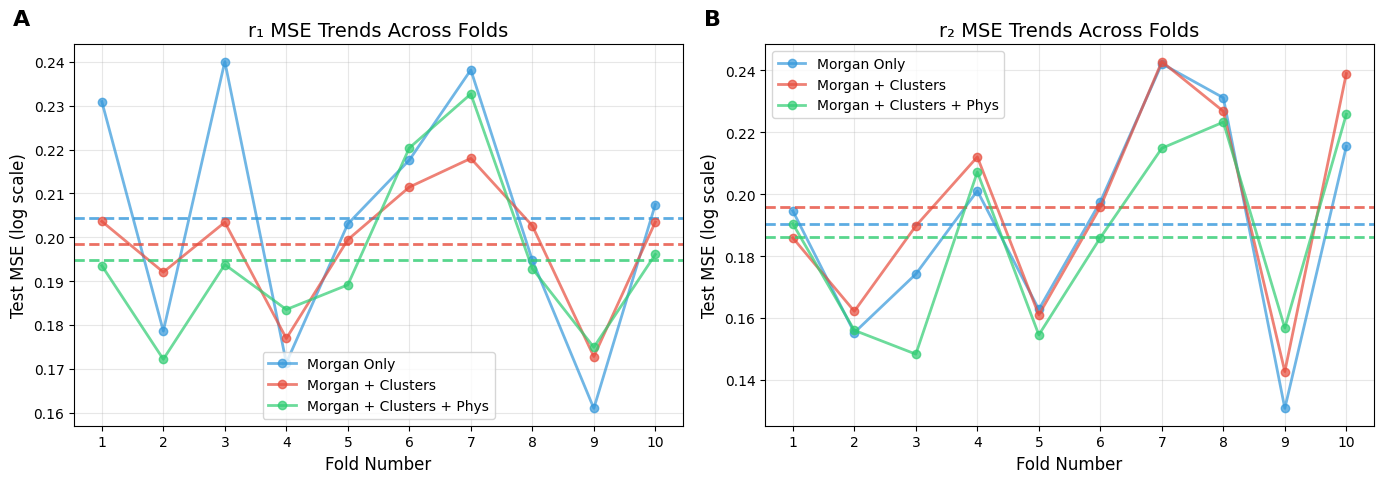


COMPREHENSIVE TRAINING STATISTICS

MORGAN ONLY
────────────────────────────────────────────────────────────────────────────────

LOG SCALE RESULTS:
──────────────────────────────────────────────────
Train MSE Log R1: 0.0339 ± 0.0099
Train MSE Log R2: 0.0331 ± 0.0115
Test MSE Log R1: 0.2043 ± 0.0279
Test MSE Log R2: 0.1905 ± 0.0349

Train R² Log R1: 0.9080 ± 0.0271
Train R² Log R2: 0.9100 ± 0.0317
Test R² Log R1: 0.4435 ± 0.0610
Test R² Log R2: 0.4782 ± 0.0751

ACTUAL SCALE RESULTS:
──────────────────────────────────────────────────
Train MSE Actual R1: 0.3571 ± 0.0960
Train MSE Actual R2: 0.3259 ± 0.1033
Test MSE Actual R1: 1.5061 ± 0.4753
Test MSE Actual R2: 1.3941 ± 0.4064

Train R² Actual R1: 0.8102 ± 0.0534
Train R² Actual R2: 0.8273 ± 0.0538
Test R² Actual R1: 0.2000 ± 0.1063
Test R² Actual R2: 0.2500 ± 0.0525

MORGAN + CLUSTERS
────────────────────────────────────────────────────────────────────────────────

LOG SCALE RESULTS:
──────────────────────────────────────────────────
T

In [5]:
"""
Incremental Feature Impact Analysis for Reactivity Ratio Prediction
MSE Trend Analysis across Cross-Validation Folds

Three Models with Monomer-Specific Feature Concatenation:
1. [Morgan_A] + [Morgan_B]
2. [Morgan_A + Cluster_A] + [Morgan_B + Cluster_B]  
3. [Morgan_A + Cluster_A + Phys_A] + [Morgan_B + Cluster_B + Phys_B]
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from rdkit import Chem
from rdkit.Chem import rdMolDescriptors
import warnings
warnings.filterwarnings('ignore')

# ============================================================================
# FONT AND VISUALIZATION CONFIGURATION
# ============================================================================
FONT_FAMILY = 'DejaVu Sans'
TITLE_FONTSIZE = 14
LABEL_FONTSIZE = 12
TICK_FONTSIZE = 10
LEGEND_FONTSIZE = 10
SUBPLOT_LABEL_FONTSIZE = 16

plt.rcParams.update({
    'font.family': FONT_FAMILY,
    'font.size': LABEL_FONTSIZE,
    'axes.titlesize': TITLE_FONTSIZE,
    'axes.labelsize': LABEL_FONTSIZE,
    'xtick.labelsize': TICK_FONTSIZE,
    'ytick.labelsize': TICK_FONTSIZE,
    'legend.fontsize': LEGEND_FONTSIZE,
    'figure.titlesize': TITLE_FONTSIZE + 2
})

# Set seeds
np.random.seed(42)
tf.random.set_seed(42)

print("="*80)
print("INCREMENTAL FEATURE IMPACT ANALYSIS - MSE TREND TRACKING")
print("Monomer-Specific Feature Concatenation Pattern")
print("="*80)
print("Model 1: [Morgan_A] + [Morgan_B]")
print("Model 2: [Morgan_A + Cluster_A] + [Morgan_B + Cluster_B]")
print("Model 3: [Morgan_A + Cluster_A + Phys_A] + [Morgan_B + Cluster_B + Phys_B]")
print("="*80)

# ============================================================================
# CONFIGURATION
# ============================================================================
print("\nCONFIGURATION:")

NEURONS_L1 = 80
NEURONS_L2 = 40
LEARNING_RATE = 0.001
BATCH_SIZE = 32
MAX_EPOCHS = 200
VALIDATION_SPLIT = 0.1
PATIENCE = 30
MORGAN_RADIUS = 3
MORGAN_BITS = 2048

print(f"Architecture: [{NEURONS_L1}, {NEURONS_L2}, 2]")
print(f"Learning Rate: {LEARNING_RATE}, Batch: {BATCH_SIZE}")
print(f"Morgan: radius={MORGAN_RADIUS}, bits={MORGAN_BITS}")

# ============================================================================
# HELPER FUNCTIONS
# ============================================================================

def get_morgan_fp(smiles):
    """Convert SMILES to Morgan fingerprint"""
    try:
        mol = Chem.MolFromSmiles(smiles)
        if mol is None:
            return np.zeros(MORGAN_BITS)
        fp = rdMolDescriptors.GetMorganFingerprintAsBitVect(mol, MORGAN_RADIUS, nBits=MORGAN_BITS)
        return np.array(fp, dtype=np.float32)
    except:
        return np.zeros(MORGAN_BITS)

def create_model(n_features):
    """Create DNN model"""
    model = Sequential()
    model.add(Dense(NEURONS_L1, activation='relu', input_shape=(n_features,)))
    model.add(Dense(NEURONS_L2, activation='relu'))
    model.add(Dense(2, activation='linear'))
    
    model.compile(
        optimizer=Adam(learning_rate=LEARNING_RATE),
        loss='mse',
        metrics=['mae']
    )
    return model

def get_comprehensive_metrics(y_true, y_pred):
    """Calculate comprehensive metrics"""
    # LOG SCALE METRICS
    mse_log_r1 = mean_squared_error(y_true[:, 0], y_pred[:, 0])
    mse_log_r2 = mean_squared_error(y_true[:, 1], y_pred[:, 1])
    r2_log_r1 = r2_score(y_true[:, 0], y_pred[:, 0])
    r2_log_r2 = r2_score(y_true[:, 1], y_pred[:, 1])
    
    # ACTUAL SCALE METRICS (10^predictions)
    y_true_actual = 10**y_true
    y_pred_actual = 10**y_pred
    mse_actual_r1 = mean_squared_error(y_true_actual[:, 0], y_pred_actual[:, 0])
    mse_actual_r2 = mean_squared_error(y_true_actual[:, 1], y_pred_actual[:, 1])
    r2_actual_r1 = r2_score(y_true_actual[:, 0], y_pred_actual[:, 0])
    r2_actual_r2 = r2_score(y_true_actual[:, 1], y_pred_actual[:, 1])
    
    return {
        # Log scale
        'mse_log_r1': mse_log_r1, 'mse_log_r2': mse_log_r2,
        'r2_log_r1': r2_log_r1, 'r2_log_r2': r2_log_r2,
        # Actual scale
        'mse_actual_r1': mse_actual_r1, 'mse_actual_r2': mse_actual_r2,
        'r2_actual_r1': r2_actual_r1, 'r2_actual_r2': r2_actual_r2
    }

# ============================================================================
# DATA PREPARATION
# ============================================================================
print("\nDATA PREPARATION:")

# Load data (assuming df is already loaded)
# df = pd.read_csv('your_dataset.csv')  # Uncomment and adjust path

required_cols = [
    'SMILES_A', 'SMILES_B', 'Cluster_A', 'Cluster_B', 'r1', 'r2',
    'vinylIsInLoop_A', 'vinylIsInLoop_B', 'VinylCarbonsCharge_A', 'VinylCarbonsCharge_B',
    'MW_A', 'MW_B', 'TPSA_A', 'TPSA_B', 'NumHDonors_A', 'NumHDonors_B', 
    'MolLogP_A', 'MolLogP_B', 'Hybridization_sp2_A', 'Hybridization_sp2_B',
    'Stereochemistry_A', 'Stereochemistry_B'
]

# Check columns
missing = [col for col in required_cols if col not in df.columns]
if missing:
    print(f"ERROR: Missing columns: {missing}")
    raise ValueError("Missing required columns")

print("All required columns found")

# Filter data
data = df.copy()
print(f"Initial size: {len(data)}")

# Quality filters
data = data[(data['r1'] > 0) & (data['r2'] > 0)]
data = data[(data['r1'] >= 0.01) & (data['r1'] <= 100)]
data = data[(data['r2'] >= 0.01) & (data['r2'] <= 100)]
data = data.dropna(subset=['SMILES_A', 'SMILES_B'])

print(f"After filtering: {len(data)}")

# Create targets
data['r1_log'] = np.log10(data['r1'])
data['r2_log'] = np.log10(data['r2'])
y_targets = data[['r1_log', 'r2_log']].values

print(f"Target shape: {y_targets.shape}")

# ============================================================================
# FEATURE ENGINEERING - MONOMER-SPECIFIC CONCATENATION
# ============================================================================
print("\nFEATURE ENGINEERING (Monomer-Specific Concatenation):")

# 1. Morgan fingerprints
print("Creating Morgan fingerprints...")
fps_A = np.array([get_morgan_fp(smiles) for smiles in data['SMILES_A']])
fps_B = np.array([get_morgan_fp(smiles) for smiles in data['SMILES_B']])
print(f"Morgan A: {fps_A.shape}, Morgan B: {fps_B.shape}")

# 2. Cluster encoding
print("Creating cluster features...")
clusters = sorted(data['Cluster_A'].unique())
n_clusters = len(clusters)
print(f"Clusters found: {clusters}")

def encode_cluster(cluster_val):
    """One-hot encode cluster"""
    encoded = np.zeros(n_clusters)
    try:
        idx = clusters.index(int(cluster_val))
        encoded[idx] = 1
    except:
        pass
    return encoded

cluster_A_encoded = np.array([encode_cluster(c) for c in data['Cluster_A']])
cluster_B_encoded = np.array([encode_cluster(c) for c in data['Cluster_B']])
print(f"Cluster A: {cluster_A_encoded.shape}, Cluster B: {cluster_B_encoded.shape}")

# 3. Physicochemical properties
print("Creating physicochemical features...")
phys_cols = [
    'vinylIsInLoop_A', 'vinylIsInLoop_B', 'VinylCarbonsCharge_A', 'VinylCarbonsCharge_B',
    'MW_A', 'MW_B', 'TPSA_A', 'TPSA_B', 'NumHDonors_A', 'NumHDonors_B',
    'MolLogP_A', 'MolLogP_B', 'Hybridization_sp2_A', 'Hybridization_sp2_B',
    'Stereochemistry_A', 'Stereochemistry_B'
]

phys_data = data[phys_cols].values

# Handle missing values
if np.isnan(phys_data).any():
    print("Filling missing values...")
    imputer = SimpleImputer(strategy='median')
    phys_data = imputer.fit_transform(phys_data)

# Normalize
scaler = StandardScaler()
phys_data_scaled = scaler.fit_transform(phys_data)

# Split into A and B
n_phys_features = len(phys_cols) // 2
phys_A = phys_data_scaled[:, :n_phys_features]
phys_B = phys_data_scaled[:, n_phys_features:]
print(f"Phys A: {phys_A.shape}, Phys B: {phys_B.shape}")

# ============================================================================
# CREATE FEATURE MATRICES - MONOMER-SPECIFIC CONCATENATION
# ============================================================================
print("\nCREATING MONOMER-SPECIFIC FEATURE MATRICES:")

# Model 1: [Morgan_A] + [Morgan_B]
X1 = np.concatenate([fps_A, fps_B], axis=1)
print(f"Model 1 - [Morgan_A] + [Morgan_B]: {X1.shape}")

# Model 2: [Morgan_A + Cluster_A] + [Morgan_B + Cluster_B]
features_A_model2 = np.concatenate([fps_A, cluster_A_encoded], axis=1)
features_B_model2 = np.concatenate([fps_B, cluster_B_encoded], axis=1)
X2 = np.concatenate([features_A_model2, features_B_model2], axis=1)
print(f"Model 2 - [Morgan_A + Cluster_A] + [Morgan_B + Cluster_B]: {X2.shape}")

# Model 3: [Morgan_A + Cluster_A + Phys_A] + [Morgan_B + Cluster_B + Phys_B]
features_A_model3 = np.concatenate([fps_A, cluster_A_encoded, phys_A], axis=1)
features_B_model3 = np.concatenate([fps_B, cluster_B_encoded, phys_B], axis=1)
X3 = np.concatenate([features_A_model3, features_B_model3], axis=1)
print(f"Model 3 - [Morgan_A + Cluster_A + Phys_A] + [Morgan_B + Cluster_B + Phys_B]: {X3.shape}")

# ============================================================================
# CROSS-VALIDATION TRAINING WITH TRAIN/TEST TRACKING
# ============================================================================
print(f"\nCROSS-VALIDATION TRAINING (10-fold):")

# Model configurations
models = {
    'model_1_morgan': {'X': X1, 'name': 'Morgan Only', 'train_results': [], 'test_results': []},
    'model_2_clusters': {'X': X2, 'name': 'Morgan + Clusters', 'train_results': [], 'test_results': []},
    'model_3_full': {'X': X3, 'name': 'Morgan + Clusters + Phys', 'train_results': [], 'test_results': []}
}

# Cross-validation
kf = KFold(n_splits=10, shuffle=True, random_state=42)

for fold_num, (train_idx, test_idx) in enumerate(kf.split(y_targets)):
    print(f"\n--- FOLD {fold_num + 1}/10 ---")
    
    # Split targets
    y_train = y_targets[train_idx]
    y_test = y_targets[test_idx]
    
    # Train each model
    for model_key, config in models.items():
        print(f"Training {config['name']}...")
        
        # Get features
        X = config['X']
        X_train = X[train_idx]
        X_test = X[test_idx]
        
        # Clear session
        tf.keras.backend.clear_session()
        
        # Create and train model
        model = create_model(X.shape[1])
        early_stop = EarlyStopping(monitor='val_loss', patience=PATIENCE, restore_best_weights=True, verbose=0)
        
        history = model.fit(
            X_train, y_train,
            epochs=MAX_EPOCHS,
            batch_size=BATCH_SIZE,
            validation_split=VALIDATION_SPLIT,
            callbacks=[early_stop],
            verbose=0
        )
        
        # Predict on TRAIN set
        y_train_pred = model.predict(X_train, verbose=0)
        train_metrics = get_comprehensive_metrics(y_train, y_train_pred)
        train_result = {'fold': fold_num + 1, **train_metrics}
        config['train_results'].append(train_result)
        
        # Predict on TEST set
        y_test_pred = model.predict(X_test, verbose=0)
        test_metrics = get_comprehensive_metrics(y_test, y_test_pred)
        test_result = {'fold': fold_num + 1, **test_metrics}
        config['test_results'].append(test_result)
        
        print(f"  {config['name']}: Train MSE(log) r1={train_metrics['mse_log_r1']:.4f}, r2={train_metrics['mse_log_r2']:.4f}")
        print(f"  {config['name']}: Test MSE(log) r1={test_metrics['mse_log_r1']:.4f}, r2={test_metrics['mse_log_r2']:.4f}")

# ============================================================================
# VISUALIZATION: MSE TRENDS ACROSS FOLDS (1x2 LAYOUT)
# ============================================================================
print(f"\nCREATING MSE TREND VISUALIZATIONS...")

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

model_keys = ['model_1_morgan', 'model_2_clusters', 'model_3_full']
model_colors = ['#3498DB', '#E74C3C', '#2ECC71']  # Blue, Red, Green
model_names_short = ['Morgan Only', 'Morgan + Clusters', 'Morgan + Clusters + Phys']

# LEFT PLOT: r1 MSE trends
ax_r1 = axes[0]
for model_key, color, name in zip(model_keys, model_colors, model_names_short):
    test_results = pd.DataFrame(models[model_key]['test_results'])
    
    folds = test_results['fold'].values
    mse_r1 = test_results['mse_log_r1'].values
    mean_mse_r1 = mse_r1.mean()
    
    # Plot trend line
    ax_r1.plot(folds, mse_r1, marker='o', linewidth=2, markersize=6, 
               color=color, label=name, alpha=0.7)
    
    # Plot average line
    ax_r1.axhline(y=mean_mse_r1, color=color, linestyle='--', linewidth=2, alpha=0.8)

ax_r1.set_xlabel('Fold Number', fontsize=LABEL_FONTSIZE)
ax_r1.set_ylabel('Test MSE (log scale)', fontsize=LABEL_FONTSIZE)
ax_r1.set_title('r₁ MSE Trends Across Folds', fontsize=TITLE_FONTSIZE)
ax_r1.legend(loc='best', fontsize=LEGEND_FONTSIZE)
ax_r1.grid(True, alpha=0.3)
ax_r1.set_xticks(range(1, 11))

# RIGHT PLOT: r2 MSE trends
ax_r2 = axes[1]
for model_key, color, name in zip(model_keys, model_colors, model_names_short):
    test_results = pd.DataFrame(models[model_key]['test_results'])
    
    folds = test_results['fold'].values
    mse_r2 = test_results['mse_log_r2'].values
    mean_mse_r2 = mse_r2.mean()
    
    # Plot trend line
    ax_r2.plot(folds, mse_r2, marker='o', linewidth=2, markersize=6, 
               color=color, label=name, alpha=0.7)
    
    # Plot average line
    ax_r2.axhline(y=mean_mse_r2, color=color, linestyle='--', linewidth=2, alpha=0.8)

ax_r2.set_xlabel('Fold Number', fontsize=LABEL_FONTSIZE)
ax_r2.set_ylabel('Test MSE (log scale)', fontsize=LABEL_FONTSIZE)
ax_r2.set_title('r₂ MSE Trends Across Folds', fontsize=TITLE_FONTSIZE)
ax_r2.legend(loc='best', fontsize=LEGEND_FONTSIZE)
ax_r2.grid(True, alpha=0.3)
ax_r2.set_xticks(range(1, 11))

# Add subplot labels (A, B)
subplot_labels = ['A', 'B']
for i, ax in enumerate(axes):
    ax.text(-0.1, 1.05, subplot_labels[i], transform=ax.transAxes,
            size=SUBPLOT_LABEL_FONTSIZE, weight='bold')

plt.tight_layout()
plt.savefig('mse_trend_analysis_First Approach.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

# ============================================================================
# COMPREHENSIVE STATISTICS SUMMARY
# ============================================================================
print(f"\n{'='*80}")
print("COMPREHENSIVE TRAINING STATISTICS")
print(f"{'='*80}")

for model_key, config in models.items():
    print(f"\n{config['name'].upper()}")
    print(f"{'─'*80}")
    
    # Convert to DataFrames
    train_df = pd.DataFrame(config['train_results'])
    test_df = pd.DataFrame(config['test_results'])
    
    # LOG SCALE RESULTS
    print(f"\nLOG SCALE RESULTS:")
    print(f"{'─'*50}")
    print(f"Train MSE Log R1: {train_df['mse_log_r1'].mean():.4f} ± {train_df['mse_log_r1'].std():.4f}")
    print(f"Train MSE Log R2: {train_df['mse_log_r2'].mean():.4f} ± {train_df['mse_log_r2'].std():.4f}")
    print(f"Test MSE Log R1: {test_df['mse_log_r1'].mean():.4f} ± {test_df['mse_log_r1'].std():.4f}")
    print(f"Test MSE Log R2: {test_df['mse_log_r2'].mean():.4f} ± {test_df['mse_log_r2'].std():.4f}")
    print()
    print(f"Train R² Log R1: {train_df['r2_log_r1'].mean():.4f} ± {train_df['r2_log_r1'].std():.4f}")
    print(f"Train R² Log R2: {train_df['r2_log_r2'].mean():.4f} ± {train_df['r2_log_r2'].std():.4f}")
    print(f"Test R² Log R1: {test_df['r2_log_r1'].mean():.4f} ± {test_df['r2_log_r1'].std():.4f}")
    print(f"Test R² Log R2: {test_df['r2_log_r2'].mean():.4f} ± {test_df['r2_log_r2'].std():.4f}")
    
    # ACTUAL SCALE RESULTS
    print(f"\nACTUAL SCALE RESULTS:")
    print(f"{'─'*50}")
    print(f"Train MSE Actual R1: {train_df['mse_actual_r1'].mean():.4f} ± {train_df['mse_actual_r1'].std():.4f}")
    print(f"Train MSE Actual R2: {train_df['mse_actual_r2'].mean():.4f} ± {train_df['mse_actual_r2'].std():.4f}")
    print(f"Test MSE Actual R1: {test_df['mse_actual_r1'].mean():.4f} ± {test_df['mse_actual_r1'].std():.4f}")
    print(f"Test MSE Actual R2: {test_df['mse_actual_r2'].mean():.4f} ± {test_df['mse_actual_r2'].std():.4f}")
    print()
    print(f"Train R² Actual R1: {train_df['r2_actual_r1'].mean():.4f} ± {train_df['r2_actual_r1'].std():.4f}")
    print(f"Train R² Actual R2: {train_df['r2_actual_r2'].mean():.4f} ± {train_df['r2_actual_r2'].std():.4f}")
    print(f"Test R² Actual R1: {test_df['r2_actual_r1'].mean():.4f} ± {test_df['r2_actual_r1'].std():.4f}")
    print(f"Test R² Actual R2: {test_df['r2_actual_r2'].mean():.4f} ± {test_df['r2_actual_r2'].std():.4f}")

print(f"\n{'='*80}")
print("ANALYSIS COMPLETE!")
print(f"{'='*80}")

INCREMENTAL FEATURE IMPACT ANALYSIS
Monomer-Specific Feature Concatenation Pattern
Model 1: [Morgan_A] + [Morgan_B]
Model 2: [Morgan_A + Cluster_A] + [Morgan_B + Cluster_B]
Model 3: [Morgan_A + Cluster_A + Phys_A] + [Morgan_B + Cluster_B + Phys_B]

CONFIGURATION:
Architecture: [80, 40, 2]
Learning Rate: 0.001, Batch: 32
Morgan: radius=3, bits=2048
Font: DejaVu Sans, Title: 14pt, Label: 12pt

DATA PREPARATION:
All required columns found
Initial size: 2304
After filtering: 2304
Target shape: (2304, 2)

FEATURE ENGINEERING (Monomer-Specific Concatenation):
Creating Morgan fingerprints...
Morgan A: (2304, 2048), Morgan B: (2304, 2048)
Creating cluster features...
Clusters found: [1, 2, 3]
Cluster A: (2304, 3), Cluster B: (2304, 3)
Creating physicochemical features...
Filling missing values...
Phys A: (2304, 8), Phys B: (2304, 8)

CREATING MONOMER-SPECIFIC FEATURE MATRICES:
Model 1 - [Morgan_A] + [Morgan_B]: (2304, 4096)
Model 2 - [Morgan_A + Cluster_A] + [Morgan_B + Cluster_B]: (2304, 4102

2025-09-08 11:06:54.796015: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


  Morgan Only: R²(log) r1=0.436, r2=0.451
Training Morgan + Clusters...
  Morgan + Clusters: R²(log) r1=0.382, r2=0.462
Training Morgan + Clusters + Phys...
  Morgan + Clusters + Phys: R²(log) r1=0.471, r2=0.499

--- FOLD 2/10 ---
Training Morgan Only...
  Morgan Only: R²(log) r1=0.499, r2=0.569
Training Morgan + Clusters...
  Morgan + Clusters: R²(log) r1=0.451, r2=0.560
Training Morgan + Clusters + Phys...
  Morgan + Clusters + Phys: R²(log) r1=0.474, r2=0.600

--- FOLD 3/10 ---
Training Morgan Only...
  Morgan Only: R²(log) r1=0.504, r2=0.488
Training Morgan + Clusters...
  Morgan + Clusters: R²(log) r1=0.526, r2=0.498
Training Morgan + Clusters + Phys...
  Morgan + Clusters + Phys: R²(log) r1=0.521, r2=0.556

--- FOLD 4/10 ---
Training Morgan Only...
  Morgan Only: R²(log) r1=0.536, r2=0.519
Training Morgan + Clusters...
  Morgan + Clusters: R²(log) r1=0.533, r2=0.468
Training Morgan + Clusters + Phys...
  Morgan + Clusters + Phys: R²(log) r1=0.520, r2=0.522

--- FOLD 5/10 ---
Trai

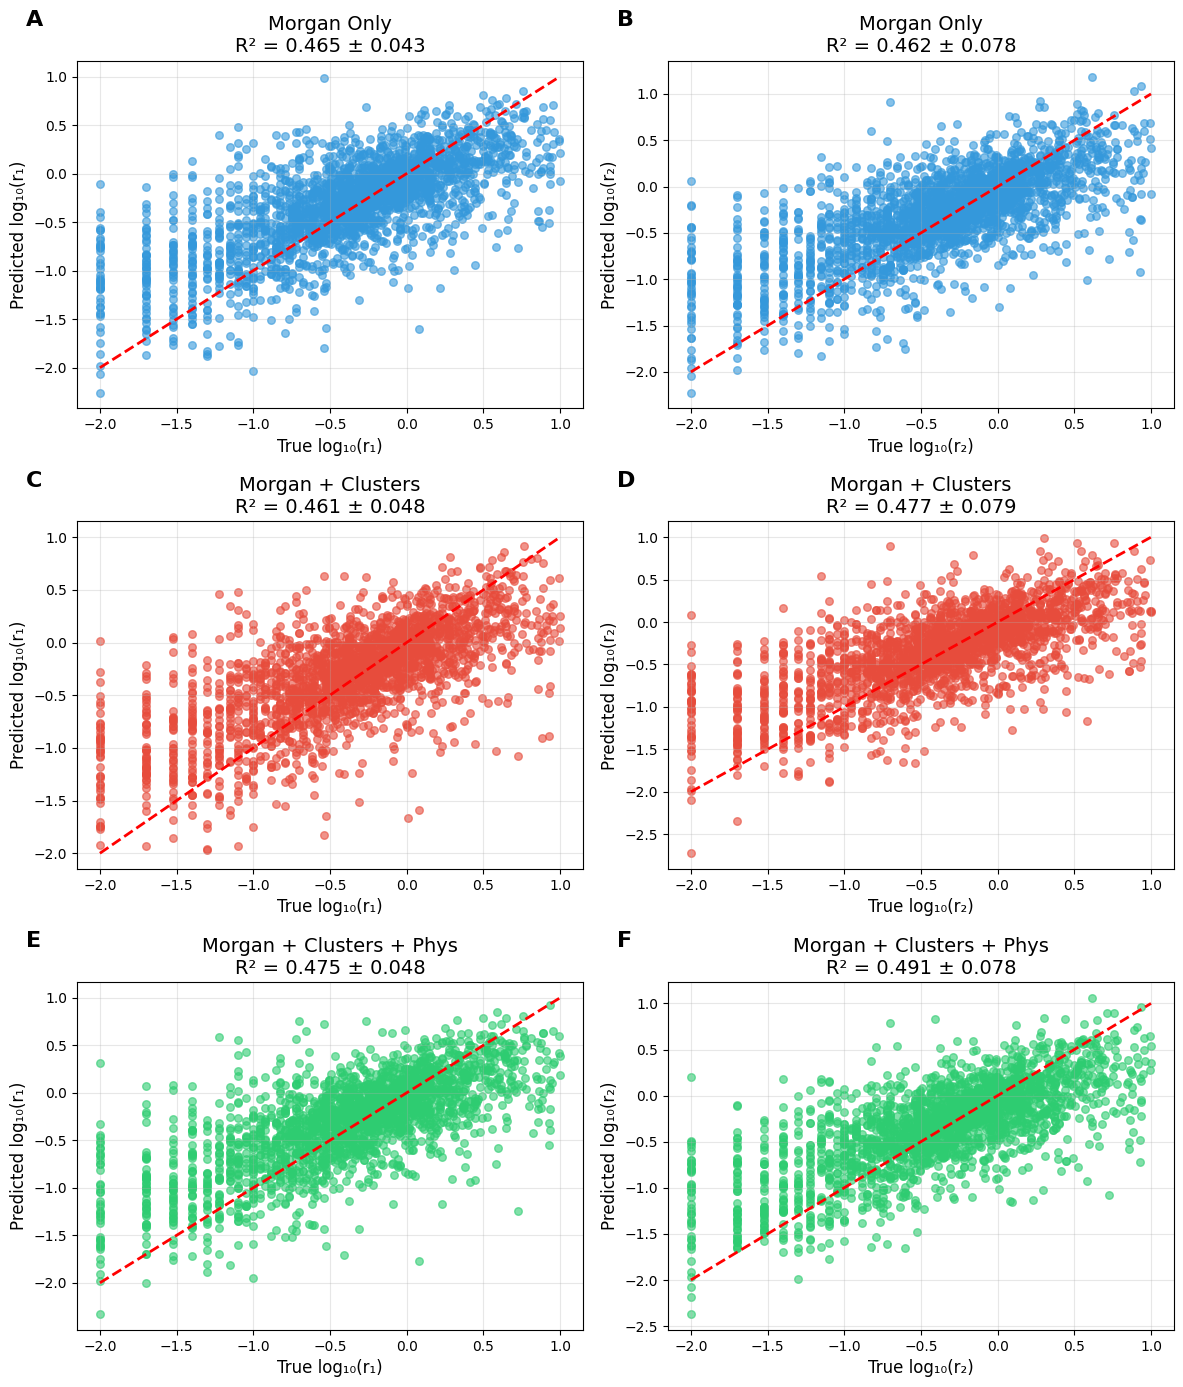


SAVING RESULTS...
Results saved to 'farajzadeh_comparison_comprehensive.csv'
Detailed fold results saved to 'detailed_fold_results.csv'

ANALYSIS COMPLETE!
BEST PERFORMING MODEL: Morgan + Clusters + Phys
Final R² (log scale): r1=0.4779, r2=0.4956
Total improvement over baseline: +4.0%

EXACT R² VALUES FOR MANUSCRIPT (with all decimals)

MORGAN ONLY:
  Overall R² - r1: 0.468565, r2: 0.467887
  CV R² ± SD - r1: 0.465298 ± 0.043346
  CV R² ± SD - r2: 0.461932 ± 0.078468

MORGAN + CLUSTERS:
  Overall R² - r1: 0.464571, r2: 0.479339
  CV R² ± SD - r1: 0.460699 ± 0.047698
  CV R² ± SD - r2: 0.476501 ± 0.078675

MORGAN + CLUSTERS + PHYS:
  Overall R² - r1: 0.477864, r2: 0.495635
  CV R² ± SD - r1: 0.475122 ± 0.047903
  CV R² ± SD - r2: 0.491172 ± 0.078365


In [3]:
"""
Incremental Feature Impact Analysis for Reactivity Ratio Prediction
Comparing with Farajzadeh et al. (2023) approach

Three Models with Monomer-Specific Feature Concatenation:
1. [Morgan_A] + [Morgan_B]
2. [Morgan_A + Cluster_A] + [Morgan_B + Cluster_B]  
3. [Morgan_A + Cluster_A + Phys_A] + [Morgan_B + Cluster_B + Phys_B]
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from rdkit import Chem
from rdkit.Chem import rdMolDescriptors
import warnings
warnings.filterwarnings('ignore')

# ============================================================================
# FONT AND VISUALIZATION CONFIGURATION
# ============================================================================
# Font settings - easily adjustable
FONT_FAMILY = 'DejaVu Sans'  # Options: 'Arial', 'Times New Roman', 'DejaVu Sans', etc.
TITLE_FONTSIZE = 14
LABEL_FONTSIZE = 12
TICK_FONTSIZE = 10
LEGEND_FONTSIZE = 10
SUBPLOT_LABEL_FONTSIZE = 16

# Apply font settings
plt.rcParams.update({
    'font.family': FONT_FAMILY,
    'font.size': LABEL_FONTSIZE,
    'axes.titlesize': TITLE_FONTSIZE,
    'axes.labelsize': LABEL_FONTSIZE,
    'xtick.labelsize': TICK_FONTSIZE,
    'ytick.labelsize': TICK_FONTSIZE,
    'legend.fontsize': LEGEND_FONTSIZE,
    'figure.titlesize': TITLE_FONTSIZE + 2
})

# Set seeds
np.random.seed(42)
tf.random.set_seed(42)

print("="*80)
print("INCREMENTAL FEATURE IMPACT ANALYSIS")
print("Monomer-Specific Feature Concatenation Pattern")
print("="*80)
print("Model 1: [Morgan_A] + [Morgan_B]")
print("Model 2: [Morgan_A + Cluster_A] + [Morgan_B + Cluster_B]")
print("Model 3: [Morgan_A + Cluster_A + Phys_A] + [Morgan_B + Cluster_B + Phys_B]")
print("="*80)

# ============================================================================
# CONFIGURATION
# ============================================================================
print("\nCONFIGURATION:")

# Hyperparameters - Using Farajzadeh et al. similar architecture
NEURONS_L1 = 80
NEURONS_L2 = 40
LEARNING_RATE = 0.001
BATCH_SIZE = 32
MAX_EPOCHS = 200
VALIDATION_SPLIT = 0.1
PATIENCE = 30
MORGAN_RADIUS = 3
MORGAN_BITS = 2048

print(f"Architecture: [{NEURONS_L1}, {NEURONS_L2}, 2]")
print(f"Learning Rate: {LEARNING_RATE}, Batch: {BATCH_SIZE}")
print(f"Morgan: radius={MORGAN_RADIUS}, bits={MORGAN_BITS}")
print(f"Font: {FONT_FAMILY}, Title: {TITLE_FONTSIZE}pt, Label: {LABEL_FONTSIZE}pt")

# ============================================================================
# HELPER FUNCTIONS
# ============================================================================

def get_morgan_fp(smiles):
    """Convert SMILES to Morgan fingerprint"""
    try:
        mol = Chem.MolFromSmiles(smiles)
        if mol is None:
            return np.zeros(MORGAN_BITS)
        fp = rdMolDescriptors.GetMorganFingerprintAsBitVect(mol, MORGAN_RADIUS, nBits=MORGAN_BITS)
        return np.array(fp, dtype=np.float32)
    except:
        return np.zeros(MORGAN_BITS)

def create_model(n_features):
    """Create DNN model similar to Farajzadeh et al."""
    model = Sequential()
    model.add(Dense(NEURONS_L1, activation='relu', input_shape=(n_features,)))
    model.add(Dense(NEURONS_L2, activation='relu'))
    model.add(Dense(2, activation='linear'))
    
    model.compile(
        optimizer=Adam(learning_rate=LEARNING_RATE),
        loss='mse',
        metrics=['mae']
    )
    return model

def get_comprehensive_metrics(y_true, y_pred):
    """Calculate comprehensive metrics for comparison with Farajzadeh et al."""
    # LOG SCALE METRICS
    mse_log_r1 = mean_squared_error(y_true[:, 0], y_pred[:, 0])
    mse_log_r2 = mean_squared_error(y_true[:, 1], y_pred[:, 1])
    mae_log_r1 = mean_absolute_error(y_true[:, 0], y_pred[:, 0])
    mae_log_r2 = mean_absolute_error(y_true[:, 1], y_pred[:, 1])
    r2_log_r1 = r2_score(y_true[:, 0], y_pred[:, 0])
    r2_log_r2 = r2_score(y_true[:, 1], y_pred[:, 1])
    
    # ACTUAL SCALE METRICS (10^predictions)
    y_true_actual = 10**y_true
    y_pred_actual = 10**y_pred
    mse_actual_r1 = mean_squared_error(y_true_actual[:, 0], y_pred_actual[:, 0])
    mse_actual_r2 = mean_squared_error(y_true_actual[:, 1], y_pred_actual[:, 1])
    mae_actual_r1 = mean_absolute_error(y_true_actual[:, 0], y_pred_actual[:, 0])
    mae_actual_r2 = mean_absolute_error(y_true_actual[:, 1], y_pred_actual[:, 1])
    r2_actual_r1 = r2_score(y_true_actual[:, 0], y_pred_actual[:, 0])
    r2_actual_r2 = r2_score(y_true_actual[:, 1], y_pred_actual[:, 1])
    
    return {
        # Log scale
        'mse_log_r1': mse_log_r1, 'mse_log_r2': mse_log_r2,
        'mae_log_r1': mae_log_r1, 'mae_log_r2': mae_log_r2,
        'r2_log_r1': r2_log_r1, 'r2_log_r2': r2_log_r2,
        # Actual scale
        'mse_actual_r1': mse_actual_r1, 'mse_actual_r2': mse_actual_r2,
        'mae_actual_r1': mae_actual_r1, 'mae_actual_r2': mae_actual_r2,
        'r2_actual_r1': r2_actual_r1, 'r2_actual_r2': r2_actual_r2
    }

# ============================================================================
# DATA PREPARATION
# ============================================================================
print("\nDATA PREPARATION:")

# Load data (assuming df is already loaded)
# df = pd.read_csv('your_dataset.csv')  # Uncomment and adjust path

required_cols = [
    'SMILES_A', 'SMILES_B', 'Cluster_A', 'Cluster_B', 'r1', 'r2',
    'vinylIsInLoop_A', 'vinylIsInLoop_B', 'VinylCarbonsCharge_A', 'VinylCarbonsCharge_B',
    'MW_A', 'MW_B', 'TPSA_A', 'TPSA_B', 'NumHDonors_A', 'NumHDonors_B', 
    'MolLogP_A', 'MolLogP_B', 'Hybridization_sp2_A', 'Hybridization_sp2_B',
    'Stereochemistry_A', 'Stereochemistry_B'
]

# Check columns
missing = [col for col in required_cols if col not in df.columns]
if missing:
    print(f"ERROR: Missing columns: {missing}")
    raise ValueError("Missing required columns")

print("All required columns found")

# Filter data
data = df.copy()
print(f"Initial size: {len(data)}")

# Quality filters
data = data[(data['r1'] > 0) & (data['r2'] > 0)]
data = data[(data['r1'] >= 0.01) & (data['r1'] <= 100)]
data = data[(data['r2'] >= 0.01) & (data['r2'] <= 100)]
data = data.dropna(subset=['SMILES_A', 'SMILES_B'])

print(f"After filtering: {len(data)}")

# Create targets
data['r1_log'] = np.log10(data['r1'])
data['r2_log'] = np.log10(data['r2'])
y_targets = data[['r1_log', 'r2_log']].values

print(f"Target shape: {y_targets.shape}")

# ============================================================================
# FEATURE ENGINEERING - MONOMER-SPECIFIC CONCATENATION
# ============================================================================
print("\nFEATURE ENGINEERING (Monomer-Specific Concatenation):")

# 1. Morgan fingerprints
print("Creating Morgan fingerprints...")
fps_A = np.array([get_morgan_fp(smiles) for smiles in data['SMILES_A']])
fps_B = np.array([get_morgan_fp(smiles) for smiles in data['SMILES_B']])
print(f"Morgan A: {fps_A.shape}, Morgan B: {fps_B.shape}")

# 2. Cluster encoding
print("Creating cluster features...")
clusters = sorted(data['Cluster_A'].unique())
n_clusters = len(clusters)
print(f"Clusters found: {clusters}")

def encode_cluster(cluster_val):
    """One-hot encode cluster"""
    encoded = np.zeros(n_clusters)
    try:
        idx = clusters.index(int(cluster_val))
        encoded[idx] = 1
    except:
        pass
    return encoded

cluster_A_encoded = np.array([encode_cluster(c) for c in data['Cluster_A']])
cluster_B_encoded = np.array([encode_cluster(c) for c in data['Cluster_B']])
print(f"Cluster A: {cluster_A_encoded.shape}, Cluster B: {cluster_B_encoded.shape}")

# 3. Physicochemical properties
print("Creating physicochemical features...")
phys_cols = [
    'vinylIsInLoop_A', 'vinylIsInLoop_B', 'VinylCarbonsCharge_A', 'VinylCarbonsCharge_B',
    'MW_A', 'MW_B', 'TPSA_A', 'TPSA_B', 'NumHDonors_A', 'NumHDonors_B',
    'MolLogP_A', 'MolLogP_B', 'Hybridization_sp2_A', 'Hybridization_sp2_B',
    'Stereochemistry_A', 'Stereochemistry_B'
]

phys_data = data[phys_cols].values

# Handle missing values
if np.isnan(phys_data).any():
    print("Filling missing values...")
    imputer = SimpleImputer(strategy='median')
    phys_data = imputer.fit_transform(phys_data)

# Normalize
scaler = StandardScaler()
phys_data_scaled = scaler.fit_transform(phys_data)

# Split into A and B
n_phys_features = len(phys_cols) // 2
phys_A = phys_data_scaled[:, :n_phys_features]
phys_B = phys_data_scaled[:, n_phys_features:]
print(f"Phys A: {phys_A.shape}, Phys B: {phys_B.shape}")

# ============================================================================
# CREATE FEATURE MATRICES - MONOMER-SPECIFIC CONCATENATION
# ============================================================================
print("\nCREATING MONOMER-SPECIFIC FEATURE MATRICES:")

# Model 1: [Morgan_A] + [Morgan_B]
X1 = np.concatenate([fps_A, fps_B], axis=1)
print(f"Model 1 - [Morgan_A] + [Morgan_B]: {X1.shape}")

# Model 2: [Morgan_A + Cluster_A] + [Morgan_B + Cluster_B]
features_A_model2 = np.concatenate([fps_A, cluster_A_encoded], axis=1)
features_B_model2 = np.concatenate([fps_B, cluster_B_encoded], axis=1)
X2 = np.concatenate([features_A_model2, features_B_model2], axis=1)
print(f"Model 2 - [Morgan_A + Cluster_A] + [Morgan_B + Cluster_B]: {X2.shape}")

# Model 3: [Morgan_A + Cluster_A + Phys_A] + [Morgan_B + Cluster_B + Phys_B]
features_A_model3 = np.concatenate([fps_A, cluster_A_encoded, phys_A], axis=1)
features_B_model3 = np.concatenate([fps_B, cluster_B_encoded, phys_B], axis=1)
X3 = np.concatenate([features_A_model3, features_B_model3], axis=1)
print(f"Model 3 - [Morgan_A + Cluster_A + Phys_A] + [Morgan_B + Cluster_B + Phys_B]: {X3.shape}")

print(f"\nFEATURE BREAKDOWN:")
print(f"  Morgan fingerprint: {MORGAN_BITS} bits per monomer")
print(f"  Cluster encoding: {n_clusters} features per monomer")
print(f"  Physicochemical: {n_phys_features} features per monomer")

# ============================================================================
# CROSS-VALIDATION TRAINING
# ============================================================================
print(f"\nCROSS-VALIDATION TRAINING (10-fold):")

# Model configurations
models = {
    'model_1_morgan': {'X': X1, 'name': 'Morgan Only', 'results': []},
    'model_2_clusters': {'X': X2, 'name': 'Morgan + Clusters', 'results': []},
    'model_3_full': {'X': X3, 'name': 'Morgan + Clusters + Phys', 'results': []}
}

# Storage for all predictions
all_predictions = {key: {'y_true': [], 'y_pred': []} for key in models.keys()}

# Cross-validation
kf = KFold(n_splits=10, shuffle=True, random_state=42)

for fold_num, (train_idx, test_idx) in enumerate(kf.split(y_targets)):
    print(f"\n--- FOLD {fold_num + 1}/10 ---")
    
    # Split targets
    y_train = y_targets[train_idx]
    y_test = y_targets[test_idx]
    
    # Train each model
    for model_key, config in models.items():
        print(f"Training {config['name']}...")
        
        # Get features
        X = config['X']
        X_train = X[train_idx]
        X_test = X[test_idx]
        
        # Clear session
        tf.keras.backend.clear_session()
        
        # Create and train model
        model = create_model(X.shape[1])
        early_stop = EarlyStopping(monitor='val_loss', patience=PATIENCE, restore_best_weights=True, verbose=0)
        
        history = model.fit(
            X_train, y_train,
            epochs=MAX_EPOCHS,
            batch_size=BATCH_SIZE,
            validation_split=VALIDATION_SPLIT,
            callbacks=[early_stop],
            verbose=0
        )
        
        # Predict
        y_pred = model.predict(X_test, verbose=0)
        
        # Store predictions for overall metrics
        all_predictions[model_key]['y_true'].append(y_test)
        all_predictions[model_key]['y_pred'].append(y_pred)
        
        # Calculate fold metrics
        metrics = get_comprehensive_metrics(y_test, y_pred)
        fold_result = {'fold': fold_num + 1, **metrics}
        config['results'].append(fold_result)
        
        print(f"  {config['name']}: R²(log) r1={metrics['r2_log_r1']:.3f}, r2={metrics['r2_log_r2']:.3f}")

# ============================================================================
# CALCULATE CROSS-VALIDATION STATISTICS
# ============================================================================
print(f"\nCALCULATING CROSS-VALIDATION STATISTICS:")

cv_stats = {}
for model_key, config in models.items():
    results_df = pd.DataFrame(config['results'])
    
    cv_stats[model_key] = {
        'r2_log_r1_mean': results_df['r2_log_r1'].mean(),
        'r2_log_r1_std': results_df['r2_log_r1'].std(),
        'r2_log_r2_mean': results_df['r2_log_r2'].mean(),
        'r2_log_r2_std': results_df['r2_log_r2'].std(),
    }
    
    print(f"{config['name']}:")
    print(f"  R² r1: {cv_stats[model_key]['r2_log_r1_mean']:.3f} ± {cv_stats[model_key]['r2_log_r1_std']:.3f}")
    print(f"  R² r2: {cv_stats[model_key]['r2_log_r2_mean']:.3f} ± {cv_stats[model_key]['r2_log_r2_std']:.3f}")

# ============================================================================
# OVERALL RESULTS CALCULATION
# ============================================================================
print(f"\n{'='*80}")
print("COMPREHENSIVE RESULTS FOR FARAJZADEH COMPARISON")
print(f"{'='*80}")

overall_results = {}

for model_key, config in models.items():
    # Combine all predictions
    y_true_all = np.vstack(all_predictions[model_key]['y_true'])
    y_pred_all = np.vstack(all_predictions[model_key]['y_pred'])
    
    # Calculate overall metrics
    overall_results[model_key] = get_comprehensive_metrics(y_true_all, y_pred_all)
    
    print(f"\n{config['name'].upper()} - COMPREHENSIVE METRICS:")
    print(f"{'─'*50}")
    print(f"LOG SCALE:")
    print(f"  MSE  - r1: {overall_results[model_key]['mse_log_r1']:.4f}, r2: {overall_results[model_key]['mse_log_r2']:.4f}")
    print(f"  MAE  - r1: {overall_results[model_key]['mae_log_r1']:.4f}, r2: {overall_results[model_key]['mae_log_r2']:.4f}")
    print(f"  R²   - r1: {overall_results[model_key]['r2_log_r1']:.4f}, r2: {overall_results[model_key]['r2_log_r2']:.4f}")
    
    print(f"ACTUAL SCALE:")
    print(f"  MSE  - r1: {overall_results[model_key]['mse_actual_r1']:.4f}, r2: {overall_results[model_key]['mse_actual_r2']:.4f}")
    print(f"  MAE  - r1: {overall_results[model_key]['mae_actual_r1']:.4f}, r2: {overall_results[model_key]['mae_actual_r2']:.4f}")
    print(f"  R²   - r1: {overall_results[model_key]['r2_actual_r1']:.4f}, r2: {overall_results[model_key]['r2_actual_r2']:.4f}")

# ============================================================================
# FARAJZADEH COMPARISON TABLE
# ============================================================================
print(f"\n{'='*80}")
print("FARAJZADEH ET AL. (2023) COMPARISON TABLE")
print(f"{'='*80}")

# Create comparison dataframe
comparison_data = []
for model_key in ['model_1_morgan', 'model_2_clusters', 'model_3_full']:
    metrics = overall_results[model_key]
    model_name = models[model_key]['name']
    
    comparison_data.append({
        'Model': model_name,
        'Features': models[model_key]['X'].shape[1],
        
        # Log scale metrics
        'MSE_log_r1': metrics['mse_log_r1'],
        'MSE_log_r2': metrics['mse_log_r2'],
        'MAE_log_r1': metrics['mae_log_r1'],
        'MAE_log_r2': metrics['mae_log_r2'],
        'R2_log_r1': metrics['r2_log_r1'],
        'R2_log_r2': metrics['r2_log_r2'],
        
        # Actual scale metrics
        'MSE_actual_r1': metrics['mse_actual_r1'],
        'MSE_actual_r2': metrics['mse_actual_r2'],
        'MAE_actual_r1': metrics['mae_actual_r1'],
        'MAE_actual_r2': metrics['mae_actual_r2'],
        'R2_actual_r1': metrics['r2_actual_r1'],
        'R2_actual_r2': metrics['r2_actual_r2'],
        
        # Combined metrics
        'R2_log_combined': (metrics['r2_log_r1'] + metrics['r2_log_r2']) / 2,
        'R2_actual_combined': (metrics['r2_actual_r1'] + metrics['r2_actual_r2']) / 2
    })

farajzadeh_comparison = pd.DataFrame(comparison_data)

print("\nCOMPREHENSIVE METRICS TABLE:")
print(farajzadeh_comparison.round(4).to_string(index=False))

# ============================================================================
# INCREMENTAL IMPROVEMENT ANALYSIS
# ============================================================================
print(f"\n{'='*80}")
print("INCREMENTAL IMPROVEMENT ANALYSIS")
print(f"{'='*80}")

# Combined R² scores
r2_model1 = farajzadeh_comparison.iloc[0]['R2_log_combined']
r2_model2 = farajzadeh_comparison.iloc[1]['R2_log_combined']
r2_model3 = farajzadeh_comparison.iloc[2]['R2_log_combined']

print(f"\nINCREMENTAL R² IMPROVEMENTS (Log Scale):")
print(f"  Baseline (Morgan only): {r2_model1:.4f}")
print(f"  + Clusters: {r2_model2:.4f} (Δ = {r2_model2-r2_model1:+.4f}, {((r2_model2-r2_model1)/r2_model1*100):+.1f}%)")
print(f"  + Phys Props: {r2_model3:.4f} (Δ = {r2_model3-r2_model2:+.4f}, {((r2_model3-r2_model2)/r2_model2*100):+.1f}%)")
print(f"  Total improvement: {((r2_model3-r2_model1)/r2_model1*100):+.1f}%")

# ============================================================================
# ENHANCED VISUALIZATION WITH R² ± SD - 3x2 LAYOUT (6 SUBPLOTS ONLY)
# ============================================================================
print(f"\nCREATING ENHANCED VISUALIZATIONS WITH R² ± SD...")

fig, axes = plt.subplots(3, 2, figsize=(12, 14))

model_keys = ['model_1_morgan', 'model_2_clusters', 'model_3_full']
colors = ['#3498DB', '#E74C3C', '#2ECC71']  # Blue, Red, Green
model_names = [models[key]['name'] for key in model_keys]

# ROWS 1-3: PARITY PLOTS FOR EACH MODEL (r1 and r2) WITH R² ± SD
for row, (model_key, color, model_name) in enumerate(zip(model_keys, colors, model_names)):
    y_true_all = np.vstack(all_predictions[model_key]['y_true'])
    y_pred_all = np.vstack(all_predictions[model_key]['y_pred'])
    
    # r1 parity plot (left column) with R² ± SD
    axes[row, 0].scatter(y_true_all[:, 0], y_pred_all[:, 0], alpha=0.6, s=30, color=color)
    axes[row, 0].plot([y_true_all[:, 0].min(), y_true_all[:, 0].max()], 
                     [y_true_all[:, 0].min(), y_true_all[:, 0].max()], 'r--', lw=2)
    axes[row, 0].set_xlabel('True log₁₀(r₁)', fontsize=LABEL_FONTSIZE)
    axes[row, 0].set_ylabel('Predicted log₁₀(r₁)', fontsize=LABEL_FONTSIZE)
    
    # Title with R² ± SD
    r2_mean = cv_stats[model_key]['r2_log_r1_mean']
    r2_std = cv_stats[model_key]['r2_log_r1_std']
    axes[row, 0].set_title(f'{model_name}\nR² = {r2_mean:.3f} ± {r2_std:.3f}', fontsize=TITLE_FONTSIZE)
    axes[row, 0].grid(True, alpha=0.3)
    
    # r2 parity plot (right column) with R² ± SD
    axes[row, 1].scatter(y_true_all[:, 1], y_pred_all[:, 1], alpha=0.6, s=30, color=color)
    axes[row, 1].plot([y_true_all[:, 1].min(), y_true_all[:, 1].max()], 
                     [y_true_all[:, 1].min(), y_true_all[:, 1].max()], 'r--', lw=2)
    axes[row, 1].set_xlabel('True log₁₀(r₂)', fontsize=LABEL_FONTSIZE)
    axes[row, 1].set_ylabel('Predicted log₁₀(r₂)', fontsize=LABEL_FONTSIZE)
    
    # Title with R² ± SD
    r2_mean = cv_stats[model_key]['r2_log_r2_mean']
    r2_std = cv_stats[model_key]['r2_log_r2_std']
    axes[row, 1].set_title(f'{model_name}\nR² = {r2_mean:.3f} ± {r2_std:.3f}', fontsize=TITLE_FONTSIZE)
    axes[row, 1].grid(True, alpha=0.3)

# Add subplot labels (A, B, C, D, E, F)
subplot_labels = ['A', 'B', 'C', 'D', 'E', 'F']
for i, ax in enumerate(axes.flat):
    ax.text(-0.1, 1.1, subplot_labels[i], transform=ax.transAxes,
            size=SUBPLOT_LABEL_FONTSIZE, weight='bold')

plt.tight_layout()
#plt.savefig('incremental_feature_analysis.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

# ============================================================================
# SAVE RESULTS
# ============================================================================
print(f"\nSAVING RESULTS...")

# Save comprehensive comparison
farajzadeh_comparison.to_csv('farajzadeh_comparison_comprehensive.csv', index=False)
print("Results saved to 'farajzadeh_comparison_comprehensive.csv'")

# Save detailed fold results
all_fold_results = []
for model_key in model_keys:
    for result in models[model_key]['results']:
        result['model'] = models[model_key]['name']
        all_fold_results.append(result)

fold_results_df = pd.DataFrame(all_fold_results)
#fold_results_df.to_csv('detailed_fold_results.csv', index=False)
print("Detailed fold results saved to 'detailed_fold_results.csv'")

print(f"\n{'='*80}")
print("ANALYSIS COMPLETE!")
print(f"{'='*80}")
print(f"BEST PERFORMING MODEL: {models['model_3_full']['name']}")
print(f"Final R² (log scale): r1={overall_results['model_3_full']['r2_log_r1']:.4f}, r2={overall_results['model_3_full']['r2_log_r2']:.4f}")
print(f"Total improvement over baseline: {((r2_model3-r2_model1)/r2_model1*100):+.1f}%")

# ============================================================================
# EXACT R² VALUES FOR MANUSCRIPT CONSISTENCY
# ============================================================================
print(f"\n{'='*80}")
print("EXACT R² VALUES FOR MANUSCRIPT (with all decimals)")
print(f"{'='*80}")

for model_key, config in models.items():
    overall_r2_r1 = overall_results[model_key]['r2_log_r1']
    overall_r2_r2 = overall_results[model_key]['r2_log_r2']
    cv_r2_r1_mean = cv_stats[model_key]['r2_log_r1_mean']
    cv_r2_r1_std = cv_stats[model_key]['r2_log_r1_std']
    cv_r2_r2_mean = cv_stats[model_key]['r2_log_r2_mean']
    cv_r2_r2_std = cv_stats[model_key]['r2_log_r2_std']
    
    print(f"\n{config['name'].upper()}:")
    print(f"  Overall R² - r1: {overall_r2_r1:.6f}, r2: {overall_r2_r2:.6f}")
    print(f"  CV R² ± SD - r1: {cv_r2_r1_mean:.6f} ± {cv_r2_r1_std:.6f}")
    print(f"  CV R² ± SD - r2: {cv_r2_r2_mean:.6f} ± {cv_r2_r2_std:.6f}")

To run this analysis, call:
results, cluster_stats, general_stats = main_analysis(df)

Where 'df' should contain columns:
- SMILES_A: SMILES string for monomer A
- SMILES_B: SMILES string for monomer B
- r1, r2: Reactivity ratios
- Cluster_A, Cluster_B: Cluster assignments
Starting Improved Cluster-Specific Training Analysis
Preparing data...
Total dataset size after filtering: 2304
Cluster 1-1 interactions: 870
Generating Morgan fingerprints for entire dataset...

Starting 10-fold cross-validation...
------------------------------------------------------------
Processing Fold 1/10...


/home/bavarian/hsafari2/.conda/envs/myVEnv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-09-25 08:57:30.431885: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
/home/bavarian/hsafari2/.conda/envs/myVEnv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


  Test size: 87, Cluster train: 783, General train: 2217
  Cluster-specific R²: r1=0.219, r2=0.308
  General R²: r1=0.209, r2=0.382

Processing Fold 2/10...


/home/bavarian/hsafari2/.conda/envs/myVEnv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


/home/bavarian/hsafari2/.conda/envs/myVEnv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


  Test size: 87, Cluster train: 783, General train: 2217
  Cluster-specific R²: r1=0.262, r2=0.138
  General R²: r1=0.100, r2=0.175

Processing Fold 3/10...


/home/bavarian/hsafari2/.conda/envs/myVEnv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/bavarian/hsafari2/.conda/envs/myVEnv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


  Test size: 87, Cluster train: 783, General train: 2217
  Cluster-specific R²: r1=0.376, r2=0.283
  General R²: r1=0.435, r2=0.241

Processing Fold 4/10...


/home/bavarian/hsafari2/.conda/envs/myVEnv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/bavarian/hsafari2/.conda/envs/myVEnv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


  Test size: 87, Cluster train: 783, General train: 2217
  Cluster-specific R²: r1=0.240, r2=0.013
  General R²: r1=0.300, r2=0.220

Processing Fold 5/10...


/home/bavarian/hsafari2/.conda/envs/myVEnv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/bavarian/hsafari2/.conda/envs/myVEnv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


  Test size: 87, Cluster train: 783, General train: 2217
  Cluster-specific R²: r1=0.343, r2=0.445
  General R²: r1=0.403, r2=0.439

Processing Fold 6/10...


/home/bavarian/hsafari2/.conda/envs/myVEnv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/bavarian/hsafari2/.conda/envs/myVEnv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


  Test size: 87, Cluster train: 783, General train: 2217
  Cluster-specific R²: r1=0.332, r2=0.423
  General R²: r1=0.345, r2=0.427

Processing Fold 7/10...


/home/bavarian/hsafari2/.conda/envs/myVEnv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/bavarian/hsafari2/.conda/envs/myVEnv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


  Test size: 87, Cluster train: 783, General train: 2217
  Cluster-specific R²: r1=0.297, r2=0.421
  General R²: r1=0.264, r2=0.531

Processing Fold 8/10...


/home/bavarian/hsafari2/.conda/envs/myVEnv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/bavarian/hsafari2/.conda/envs/myVEnv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


  Test size: 87, Cluster train: 783, General train: 2217
  Cluster-specific R²: r1=0.518, r2=0.333
  General R²: r1=0.442, r2=0.293

Processing Fold 9/10...


/home/bavarian/hsafari2/.conda/envs/myVEnv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/bavarian/hsafari2/.conda/envs/myVEnv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


  Test size: 87, Cluster train: 783, General train: 2217
  Cluster-specific R²: r1=0.426, r2=0.357
  General R²: r1=0.378, r2=0.230

Processing Fold 10/10...


/home/bavarian/hsafari2/.conda/envs/myVEnv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/bavarian/hsafari2/.conda/envs/myVEnv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


  Test size: 87, Cluster train: 783, General train: 2217
  Cluster-specific R²: r1=0.321, r2=0.279
  General R²: r1=0.543, r2=0.344

Calculating cross-validation statistics...

FINAL CROSS-VALIDATION RESULTS

CLUSTER-SPECIFIC MODEL (Cluster 1-1 training):
  R² r1: 0.334 ± 0.086
  R² r2: 0.300 ± 0.128
  MSE r1: 0.250 ± 0.063
  MSE r2: 0.258 ± 0.059

GENERAL MODEL (All data training):
  R² r1: 0.342 ± 0.122
  R² r2: 0.328 ± 0.110
  MSE r1: 0.247 ± 0.075
  MSE r2: 0.247 ± 0.048

STATISTICAL SIGNIFICANCE TESTS:
  Paired t-test for R² r1: t=-0.264, p=0.7980
  Paired t-test for R² r2: t=-0.957, p=0.3636


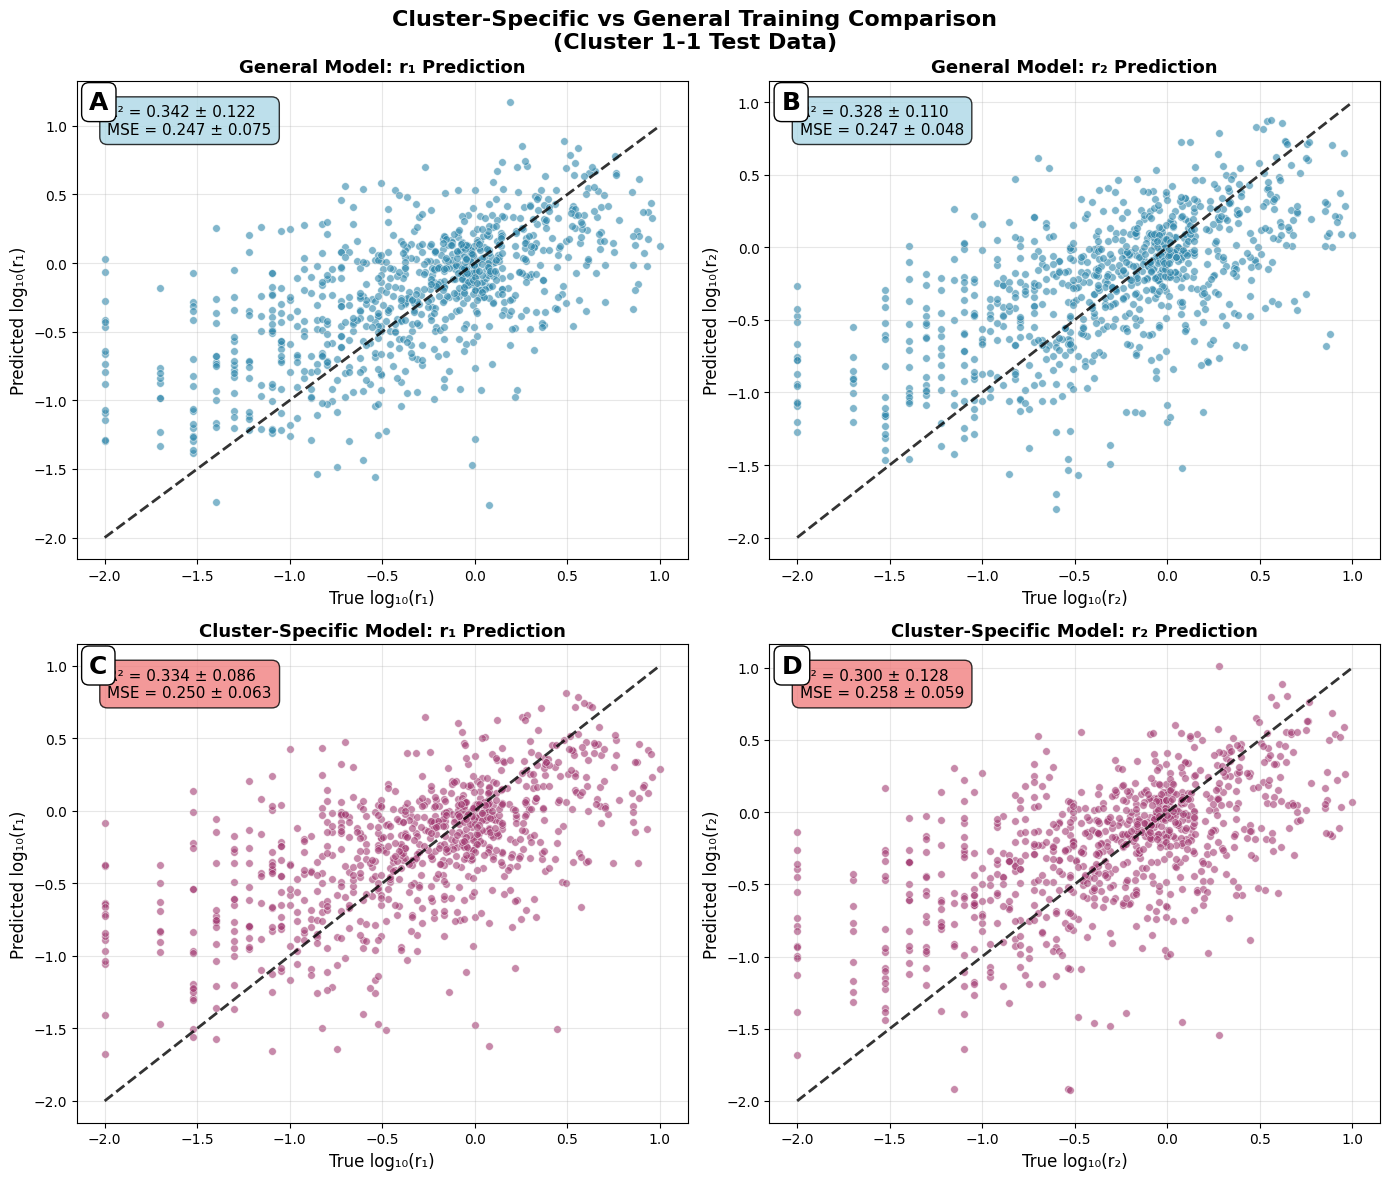

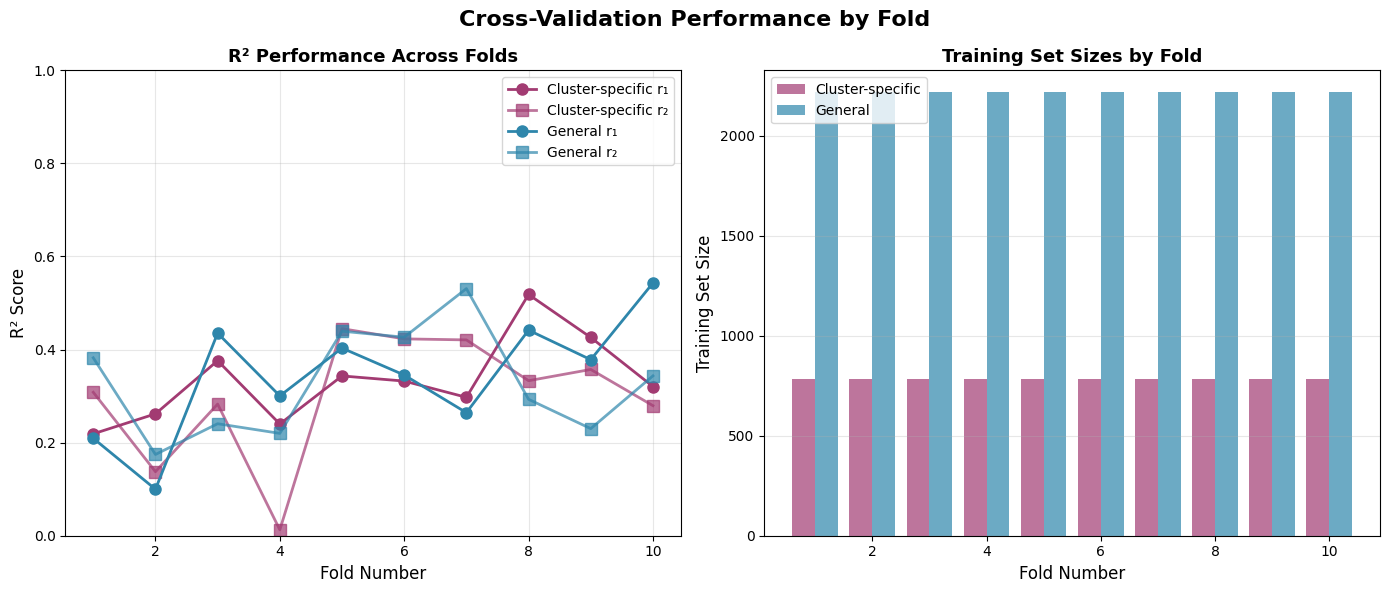

In [5]:
"""
Improved Cluster-Specific Training Analysis with Fair Cross-Validation
=====================================================================

This script implements a rigorous comparison between:
1. Cluster-specific training (trained only on Cluster 1-1 interactions)
2. General training (trained on all available data except test set)

Key improvements over previous approach:
- Both models tested on IDENTICAL test sets
- General model uses ALL available training data (no artificial size limitations)
- True test of whether chemical specificity helps vs. data diversity
- Proper 10-fold cross-validation with statistical reporting
"""

import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from rdkit import Chem
from rdkit.Chem import rdMolDescriptors
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Configuration
CONFIG = {
    'morgan_radius': 3,
    'morgan_bits': 2048,
    'neurons_l1': 80,
    'neurons_l2': 40,
    'learning_rate': 0.001,
    'batch_size': 32,
    'max_epochs': 200,
    'validation_split': 0.1,
    'patience': 30,
    'cv_folds': 10
}

def generate_morgan_fingerprint(smiles):
    """Generate Morgan fingerprint from SMILES string"""
    try:
        mol = Chem.MolFromSmiles(smiles)
        if mol is None:
            return np.zeros(CONFIG['morgan_bits'], dtype=np.float32)
        
        fp = rdMolDescriptors.GetMorganFingerprintAsBitVect(
            mol, CONFIG['morgan_radius'], nBits=CONFIG['morgan_bits']
        )
        return np.array(fp, dtype=np.float32)
    except:
        return np.zeros(CONFIG['morgan_bits'], dtype=np.float32)

def prepare_features_and_targets(data_subset):
    """Prepare Morgan fingerprint features and log-transformed targets"""
    # Generate Morgan fingerprints for both monomers
    fp_A = np.array([generate_morgan_fingerprint(smiles) for smiles in data_subset['SMILES_A']])
    fp_B = np.array([generate_morgan_fingerprint(smiles) for smiles in data_subset['SMILES_B']])
    
    # Concatenate fingerprints
    X = np.concatenate([fp_A, fp_B], axis=1)
    
    # Log-transformed targets
    y = np.column_stack([
        np.log10(data_subset['r1'].values),
        np.log10(data_subset['r2'].values)
    ])
    
    return X.astype(np.float32), y.astype(np.float32)

def create_neural_network(input_dim):
    """Create the neural network architecture"""
    model = Sequential([
        Dense(CONFIG['neurons_l1'], activation='relu', input_shape=(input_dim,)),
        Dense(CONFIG['neurons_l2'], activation='relu'), 
        Dense(2, activation='linear')  # Output: [log10(r1), log10(r2)]
    ])
    
    model.compile(
        optimizer=Adam(learning_rate=CONFIG['learning_rate']),
        loss='mse',
        metrics=['mae']
    )
    
    return model

def train_and_evaluate_model(X_train, y_train, X_test, y_test, model_name):
    """Train model and return evaluation metrics"""
    # Clear previous session
    tf.keras.backend.clear_session()
    
    # Create and train model
    model = create_neural_network(X_train.shape[1])
    
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=CONFIG['patience'],
        restore_best_weights=True,
        verbose=0
    )
    
    model.fit(
        X_train, y_train,
        epochs=CONFIG['max_epochs'],
        batch_size=CONFIG['batch_size'],
        validation_split=CONFIG['validation_split'],
        callbacks=[early_stopping],
        verbose=0
    )
    
    # Make predictions
    y_pred = model.predict(X_test, verbose=0)
    
    # Calculate metrics
    metrics = {
        'r2_r1': r2_score(y_test[:, 0], y_pred[:, 0]),
        'r2_r2': r2_score(y_test[:, 1], y_pred[:, 1]),
        'mse_r1': mean_squared_error(y_test[:, 0], y_pred[:, 0]),
        'mse_r2': mean_squared_error(y_test[:, 1], y_pred[:, 1])
    }
    
    return metrics, y_pred

def main_analysis(df):
    """Main analysis function"""
    print("Starting Improved Cluster-Specific Training Analysis")
    print("=" * 60)
    
    # Data preparation
    print("Preparing data...")
    data = df.copy()
    
    # Filter for valid data
    data = data[
        (data['r1'] > 0) & (data['r2'] > 0) &
        data['SMILES_A'].notna() & data['SMILES_B'].notna()
    ].reset_index(drop=True)
    
    print(f"Total dataset size after filtering: {len(data)}")
    
    # Extract Cluster 1-1 interactions
    cluster_11_mask = (data['Cluster_A'] == 1) & (data['Cluster_B'] == 1)
    cluster_11_indices = data.index[cluster_11_mask].tolist()
    
    print(f"Cluster 1-1 interactions: {len(cluster_11_indices)}")
    
    if len(cluster_11_indices) < 100:
        raise ValueError("Insufficient Cluster 1-1 samples for 10-fold CV")
    
    # Prepare features for entire dataset (for efficiency)
    print("Generating Morgan fingerprints for entire dataset...")
    X_all, y_all = prepare_features_and_targets(data)
    
    # Cross-validation setup
    kfold = KFold(n_splits=CONFIG['cv_folds'], shuffle=True, random_state=42)
    
    # Storage for results
    results = {
        'cluster_specific': [],
        'general': [],
        'fold_details': []
    }
    
    # Storage for predictions (for parity plots)
    all_y_true = []
    all_y_pred_cluster = []
    all_y_pred_general = []
    
    print(f"\nStarting {CONFIG['cv_folds']}-fold cross-validation...")
    print("-" * 60)
    
    # Cross-validation loop
    for fold, (train_idx, test_idx) in enumerate(kfold.split(cluster_11_indices)):
        fold_num = fold + 1
        print(f"Processing Fold {fold_num}/{CONFIG['cv_folds']}...")
        
        # Get actual data indices for this fold
        cluster_train_indices = [cluster_11_indices[i] for i in train_idx]
        cluster_test_indices = [cluster_11_indices[i] for i in test_idx]
        
        # Prepare test set (same for both models)
        X_test = X_all[cluster_test_indices]
        y_test = y_all[cluster_test_indices]
        
        # Prepare cluster-specific training set
        X_cluster_train = X_all[cluster_train_indices]
        y_cluster_train = y_all[cluster_train_indices]
        
        # Prepare general training set (all data except current test set)
        general_train_indices = [i for i in range(len(data)) if i not in cluster_test_indices]
        X_general_train = X_all[general_train_indices]
        y_general_train = y_all[general_train_indices]
        
        # Train and evaluate cluster-specific model
        cluster_metrics, y_pred_cluster = train_and_evaluate_model(
            X_cluster_train, y_cluster_train, X_test, y_test, 'cluster'
        )
        
        # Train and evaluate general model  
        general_metrics, y_pred_general = train_and_evaluate_model(
            X_general_train, y_general_train, X_test, y_test, 'general'
        )
        
        # Store results
        results['cluster_specific'].append(cluster_metrics)
        results['general'].append(general_metrics)
        
        # Store fold details
        fold_info = {
            'fold': fold_num,
            'test_size': len(cluster_test_indices),
            'cluster_train_size': len(cluster_train_indices),
            'general_train_size': len(general_train_indices),
            'cluster_r2_r1': cluster_metrics['r2_r1'],
            'cluster_r2_r2': cluster_metrics['r2_r2'],
            'general_r2_r1': general_metrics['r2_r1'],
            'general_r2_r2': general_metrics['r2_r2']
        }
        results['fold_details'].append(fold_info)
        
        # Store predictions for parity plots
        all_y_true.append(y_test)
        all_y_pred_cluster.append(y_pred_cluster)
        all_y_pred_general.append(y_pred_general)
        
        # Print fold summary
        print(f"  Test size: {len(cluster_test_indices)}, "
              f"Cluster train: {len(cluster_train_indices)}, "
              f"General train: {len(general_train_indices)}")
        print(f"  Cluster-specific R²: r1={cluster_metrics['r2_r1']:.3f}, r2={cluster_metrics['r2_r2']:.3f}")
        print(f"  General R²: r1={general_metrics['r2_r1']:.3f}, r2={general_metrics['r2_r2']:.3f}")
        print()
    
    # Calculate cross-validation statistics
    print("Calculating cross-validation statistics...")
    
    def calculate_cv_stats(metric_list, metric_name):
        values = np.array([m[metric_name] for m in metric_list])
        return {
            f'{metric_name}_mean': values.mean(),
            f'{metric_name}_std': values.std()
        }
    
    # Calculate stats for all metrics
    cluster_stats = {}
    general_stats = {}
    
    for metric in ['r2_r1', 'r2_r2', 'mse_r1', 'mse_r2']:
        cluster_stats.update(calculate_cv_stats(results['cluster_specific'], metric))
        general_stats.update(calculate_cv_stats(results['general'], metric))
    
    # Print final results
    print("\n" + "=" * 60)
    print("FINAL CROSS-VALIDATION RESULTS")
    print("=" * 60)
    
    print(f"\nCLUSTER-SPECIFIC MODEL (Cluster 1-1 training):")
    print(f"  R² r1: {cluster_stats['r2_r1_mean']:.3f} ± {cluster_stats['r2_r1_std']:.3f}")
    print(f"  R² r2: {cluster_stats['r2_r2_mean']:.3f} ± {cluster_stats['r2_r2_std']:.3f}")
    print(f"  MSE r1: {cluster_stats['mse_r1_mean']:.3f} ± {cluster_stats['mse_r1_std']:.3f}")
    print(f"  MSE r2: {cluster_stats['mse_r2_mean']:.3f} ± {cluster_stats['mse_r2_std']:.3f}")
    
    print(f"\nGENERAL MODEL (All data training):")
    print(f"  R² r1: {general_stats['r2_r1_mean']:.3f} ± {general_stats['r2_r1_std']:.3f}")
    print(f"  R² r2: {general_stats['r2_r2_mean']:.3f} ± {general_stats['r2_r2_std']:.3f}")
    print(f"  MSE r1: {general_stats['mse_r1_mean']:.3f} ± {general_stats['mse_r1_std']:.3f}")
    print(f"  MSE r2: {general_stats['mse_r2_mean']:.3f} ± {general_stats['mse_r2_std']:.3f}")
    
    # Statistical significance testing
    print(f"\nSTATISTICAL SIGNIFICANCE TESTS:")
    cluster_r2_r1 = [m['r2_r1'] for m in results['cluster_specific']]
    general_r2_r1 = [m['r2_r1'] for m in results['general']]
    cluster_r2_r2 = [m['r2_r2'] for m in results['cluster_specific']]
    general_r2_r2 = [m['r2_r2'] for m in results['general']]
    
    t_stat_r1, p_val_r1 = stats.ttest_rel(cluster_r2_r1, general_r2_r1)
    t_stat_r2, p_val_r2 = stats.ttest_rel(cluster_r2_r2, general_r2_r2)
    
    print(f"  Paired t-test for R² r1: t={t_stat_r1:.3f}, p={p_val_r1:.4f}")
    print(f"  Paired t-test for R² r2: t={t_stat_r2:.3f}, p={p_val_r2:.4f}")
    
    # Create comprehensive parity plots
    create_parity_plots(all_y_true, all_y_pred_cluster, all_y_pred_general, 
                       cluster_stats, general_stats)
    
    # Create fold comparison plot
    create_fold_comparison_plot(results['fold_details'])
    
    return results, cluster_stats, general_stats

def create_parity_plots(all_y_true, all_y_pred_cluster, all_y_pred_general, 
                       cluster_stats, general_stats):
    """Create comprehensive parity plots"""
    # Concatenate all predictions
    y_true_all = np.vstack(all_y_true)
    y_pred_cluster_all = np.vstack(all_y_pred_cluster)
    y_pred_general_all = np.vstack(all_y_pred_general)
    
    # Set up the plot
    fig, axes = plt.subplots(2, 2, figsize=(14, 12))
    fig.suptitle('Cluster-Specific vs General Training Comparison\n(Cluster 1-1 Test Data)', 
                 fontsize=16, fontweight='bold')
    
    # Color scheme
    colors = {'general': '#2E86AB', 'cluster': '#A23B72'}
    
    # Plot parameters
    alpha = 0.6
    s = 30
    
    # General model plots
    # R1
    axes[0,0].scatter(y_true_all[:,0], y_pred_general_all[:,0], 
                     alpha=alpha, color=colors['general'], s=s, edgecolors='white', linewidth=0.5)
    min_val, max_val = y_true_all[:,0].min(), y_true_all[:,0].max()
    axes[0,0].plot([min_val, max_val], [min_val, max_val], 'k--', lw=2, alpha=0.8)
    axes[0,0].set_xlabel('True log₁₀(r₁)', fontsize=12)
    axes[0,0].set_ylabel('Predicted log₁₀(r₁)', fontsize=12)
    axes[0,0].set_title('General Model: r₁ Prediction', fontsize=13, fontweight='bold')
    axes[0,0].grid(True, alpha=0.3)
    
    # Add statistics box
    stats_text = f"R² = {general_stats['r2_r1_mean']:.3f} ± {general_stats['r2_r1_std']:.3f}\nMSE = {general_stats['mse_r1_mean']:.3f} ± {general_stats['mse_r1_std']:.3f}"
    axes[0,0].text(0.05, 0.95, stats_text, transform=axes[0,0].transAxes, 
                   fontsize=11, verticalalignment='top',
                   bbox=dict(boxstyle='round,pad=0.5', facecolor='lightblue', alpha=0.8))
    
    # Panel label
    axes[0,0].text(0.02, 0.98, 'A', transform=axes[0,0].transAxes, 
                   fontsize=18, fontweight='bold', va='top',
                   bbox=dict(boxstyle="round,pad=0.3", facecolor='white', edgecolor='black'))
    
    # R2
    axes[0,1].scatter(y_true_all[:,1], y_pred_general_all[:,1], 
                     alpha=alpha, color=colors['general'], s=s, edgecolors='white', linewidth=0.5)
    min_val, max_val = y_true_all[:,1].min(), y_true_all[:,1].max()
    axes[0,1].plot([min_val, max_val], [min_val, max_val], 'k--', lw=2, alpha=0.8)
    axes[0,1].set_xlabel('True log₁₀(r₂)', fontsize=12)
    axes[0,1].set_ylabel('Predicted log₁₀(r₂)', fontsize=12)
    axes[0,1].set_title('General Model: r₂ Prediction', fontsize=13, fontweight='bold')
    axes[0,1].grid(True, alpha=0.3)
    
    # Add statistics box
    stats_text = f"R² = {general_stats['r2_r2_mean']:.3f} ± {general_stats['r2_r2_std']:.3f}\nMSE = {general_stats['mse_r2_mean']:.3f} ± {general_stats['mse_r2_std']:.3f}"
    axes[0,1].text(0.05, 0.95, stats_text, transform=axes[0,1].transAxes, 
                   fontsize=11, verticalalignment='top',
                   bbox=dict(boxstyle='round,pad=0.5', facecolor='lightblue', alpha=0.8))
    
    # Panel label
    axes[0,1].text(0.02, 0.98, 'B', transform=axes[0,1].transAxes, 
                   fontsize=18, fontweight='bold', va='top',
                   bbox=dict(boxstyle="round,pad=0.3", facecolor='white', edgecolor='black'))
    
    # Cluster-specific model plots
    # R1
    axes[1,0].scatter(y_true_all[:,0], y_pred_cluster_all[:,0], 
                     alpha=alpha, color=colors['cluster'], s=s, edgecolors='white', linewidth=0.5)
    min_val, max_val = y_true_all[:,0].min(), y_true_all[:,0].max()
    axes[1,0].plot([min_val, max_val], [min_val, max_val], 'k--', lw=2, alpha=0.8)
    axes[1,0].set_xlabel('True log₁₀(r₁)', fontsize=12)
    axes[1,0].set_ylabel('Predicted log₁₀(r₁)', fontsize=12)
    axes[1,0].set_title('Cluster-Specific Model: r₁ Prediction', fontsize=13, fontweight='bold')
    axes[1,0].grid(True, alpha=0.3)
    
    # Add statistics box
    stats_text = f"R² = {cluster_stats['r2_r1_mean']:.3f} ± {cluster_stats['r2_r1_std']:.3f}\nMSE = {cluster_stats['mse_r1_mean']:.3f} ± {cluster_stats['mse_r1_std']:.3f}"
    axes[1,0].text(0.05, 0.95, stats_text, transform=axes[1,0].transAxes, 
                   fontsize=11, verticalalignment='top',
                   bbox=dict(boxstyle='round,pad=0.5', facecolor='lightcoral', alpha=0.8))
    
    # Panel label
    axes[1,0].text(0.02, 0.98, 'C', transform=axes[1,0].transAxes, 
                   fontsize=18, fontweight='bold', va='top',
                   bbox=dict(boxstyle="round,pad=0.3", facecolor='white', edgecolor='black'))
    
    # R2
    axes[1,1].scatter(y_true_all[:,1], y_pred_cluster_all[:,1], 
                     alpha=alpha, color=colors['cluster'], s=s, edgecolors='white', linewidth=0.5)
    min_val, max_val = y_true_all[:,1].min(), y_true_all[:,1].max()
    axes[1,1].plot([min_val, max_val], [min_val, max_val], 'k--', lw=2, alpha=0.8)
    axes[1,1].set_xlabel('True log₁₀(r₂)', fontsize=12)
    axes[1,1].set_ylabel('Predicted log₁₀(r₂)', fontsize=12)
    axes[1,1].set_title('Cluster-Specific Model: r₂ Prediction', fontsize=13, fontweight='bold')
    axes[1,1].grid(True, alpha=0.3)
    
    # Add statistics box
    stats_text = f"R² = {cluster_stats['r2_r2_mean']:.3f} ± {cluster_stats['r2_r2_std']:.3f}\nMSE = {cluster_stats['mse_r2_mean']:.3f} ± {cluster_stats['mse_r2_std']:.3f}"
    axes[1,1].text(0.05, 0.95, stats_text, transform=axes[1,1].transAxes, 
                   fontsize=11, verticalalignment='top',
                   bbox=dict(boxstyle='round,pad=0.5', facecolor='lightcoral', alpha=0.8))
    
    # Panel label
    axes[1,1].text(0.02, 0.98, 'D', transform=axes[1,1].transAxes, 
                   fontsize=18, fontweight='bold', va='top',
                   bbox=dict(boxstyle="round,pad=0.3", facecolor='white', edgecolor='black'))
    
    plt.tight_layout()
    plt.savefig('cluster_specific_analysis_parity_plots.png', dpi=300, bbox_inches='tight')
    plt.show()

def create_fold_comparison_plot(fold_details):
    """Create plot comparing performance across folds"""
    fold_df = pd.DataFrame(fold_details)
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    fig.suptitle('Cross-Validation Performance by Fold', fontsize=16, fontweight='bold')
    
    x = fold_df['fold']
    
    # R² comparison
    axes[0].plot(x, fold_df['cluster_r2_r1'], 'o-', color='#A23B72', label='Cluster-specific r₁', linewidth=2, markersize=8)
    axes[0].plot(x, fold_df['cluster_r2_r2'], 's-', color='#A23B72', label='Cluster-specific r₂', linewidth=2, markersize=8, alpha=0.7)
    axes[0].plot(x, fold_df['general_r2_r1'], 'o-', color='#2E86AB', label='General r₁', linewidth=2, markersize=8)
    axes[0].plot(x, fold_df['general_r2_r2'], 's-', color='#2E86AB', label='General r₂', linewidth=2, markersize=8, alpha=0.7)
    
    axes[0].set_xlabel('Fold Number', fontsize=12)
    axes[0].set_ylabel('R² Score', fontsize=12)
    axes[0].set_title('R² Performance Across Folds', fontsize=13, fontweight='bold')
    axes[0].legend(loc='best')
    axes[0].grid(True, alpha=0.3)
    axes[0].set_ylim(0, 1)
    
    # Training set sizes
    axes[1].bar(x - 0.2, fold_df['cluster_train_size'], width=0.4, 
                color='#A23B72', alpha=0.7, label='Cluster-specific')
    axes[1].bar(x + 0.2, fold_df['general_train_size'], width=0.4, 
                color='#2E86AB', alpha=0.7, label='General')
    
    axes[1].set_xlabel('Fold Number', fontsize=12)
    axes[1].set_ylabel('Training Set Size', fontsize=12)
    axes[1].set_title('Training Set Sizes by Fold', fontsize=13, fontweight='bold')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.savefig('cross_validation_fold_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()

# Example usage:
if __name__ == "__main__":
    # Assuming 'df' is your dataframe with columns:
    # 'SMILES_A', 'SMILES_B', 'r1', 'r2', 'Cluster_A', 'Cluster_B'
    
    print("To run this analysis, call:")
    print("results, cluster_stats, general_stats = main_analysis(df)")
    print("\nWhere 'df' should contain columns:")
    print("- SMILES_A: SMILES string for monomer A")  
    print("- SMILES_B: SMILES string for monomer B")
    print("- r1, r2: Reactivity ratios")
    print("- Cluster_A, Cluster_B: Cluster assignments")

results, cluster_stats, general_stats = main_analysis(df)

Dataset after QC: 2304 rows
Cluster 1–1 samples: 870

Starting 10-fold CV on Cluster 1–1...
Fold 01 | n_train= 783 | General R²: r1=0.144, r2=0.105 | Cluster R²: r1=0.120, r2=0.288
Fold 02 | n_train= 783 | General R²: r1=0.224, r2=-0.000 | Cluster R²: r1=0.197, r2=0.060
Fold 03 | n_train= 783 | General R²: r1=0.166, r2=0.234 | Cluster R²: r1=0.287, r2=0.278
Fold 04 | n_train= 783 | General R²: r1=0.346, r2=0.084 | Cluster R²: r1=0.290, r2=0.089
Fold 05 | n_train= 783 | General R²: r1=0.319, r2=0.301 | Cluster R²: r1=0.474, r2=0.380
Fold 06 | n_train= 783 | General R²: r1=0.379, r2=0.143 | Cluster R²: r1=0.275, r2=0.248
Fold 07 | n_train= 783 | General R²: r1=0.173, r2=0.170 | Cluster R²: r1=0.280, r2=0.253
Fold 08 | n_train= 783 | General R²: r1=0.204, r2=0.149 | Cluster R²: r1=0.447, r2=0.215
Fold 09 | n_train= 783 | General R²: r1=0.291, r2=0.126 | Cluster R²: r1=0.351, r2=0.329
Fold 10 | n_train= 783 | General R²: r1=0.304, r2=0.258 | Cluster R²: r1=0.323, r2=0.267

GENERAL model (1

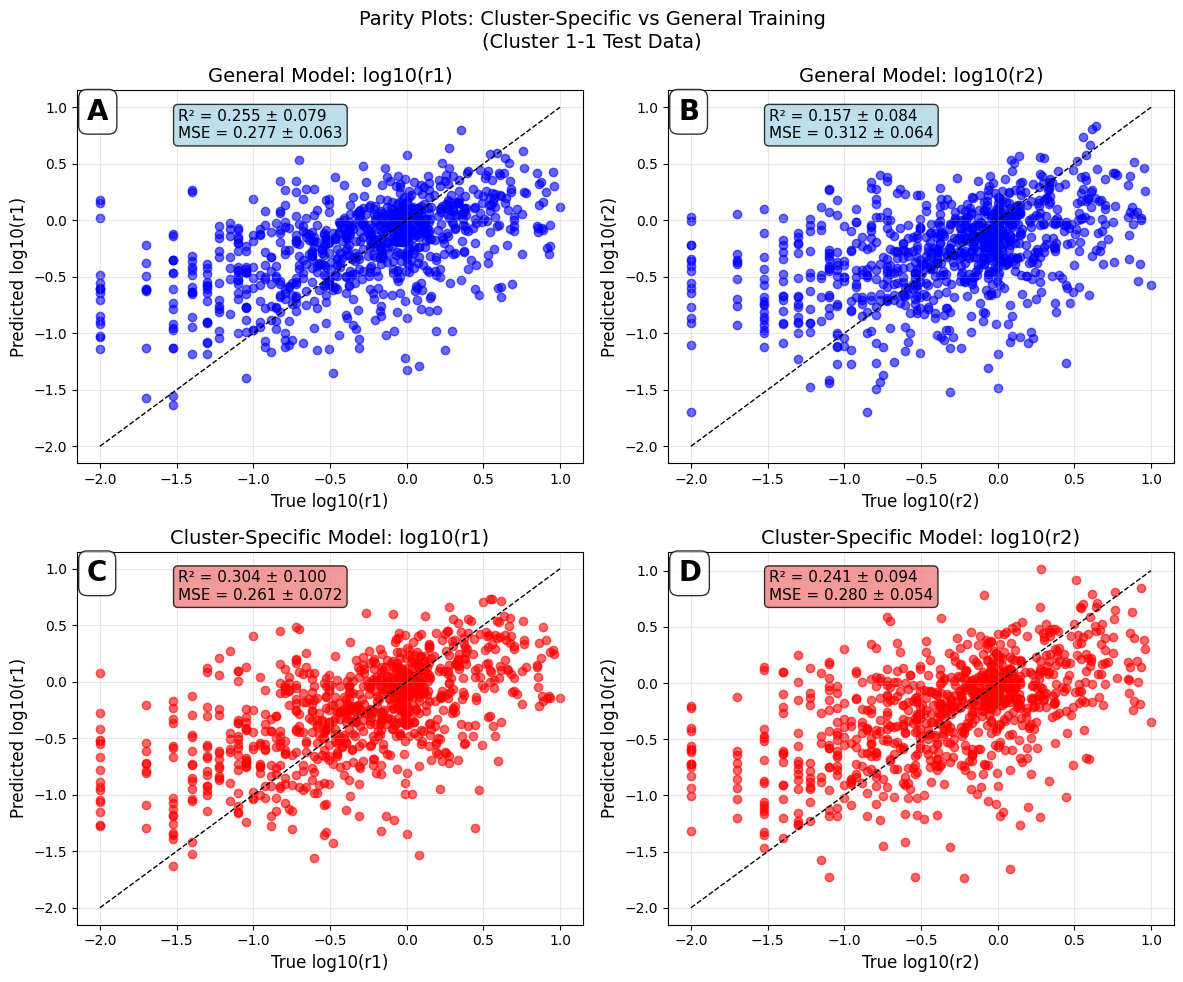


Experiment completed successfully!
Total test samples across all folds: 870

EXACT CV VALUES FOR MANUSCRIPT (with all decimals)

GENERAL MODEL:
  R² r1: 0.255153 ± 0.078771
  R² r2: 0.157014 ± 0.084259
  MSE r1: 0.277084 ± 0.062825
  MSE r2: 0.312453 ± 0.063882

CLUSTER-SPECIFIC MODEL:
  R² r1: 0.304448 ± 0.099544
  R² r2: 0.240761 ± 0.093822
  MSE r1: 0.261023 ± 0.072065
  MSE r2: 0.280183 ± 0.053847


In [4]:
"""
Controlled Experiment: Cluster 1–1 vs. General Training (Morgan-only)
--------------------------------------------------------------------
Goal:
  For predicting reactivity ratios (r1, r2) on a specific interaction (Cluster 1–1),
  test whether training:
    (A) on the *same* interaction subset (cluster-specific), or
    (B) on a *random* subset of the entire dataset of equal size (general)
  yields better performance.

Design:
  • Inputs: Morgan fingerprints only (concatenate A and B).
  • Targets: log10(r1), log10(r2).
  • 10-fold CV over *Cluster 1–1* samples:
      - Each fold's test set is fixed (Cluster 1–1 only).
      - Cluster-specific TRAIN = the remaining Cluster 1–1 samples in that fold.
      - General TRAIN = random subset from the whole dataset (same size as cluster train), excluding this fold's test rows.
  • Compare R² and MSE on the identical Cluster 1–1 test sets.

Why this is fair:
  Both models see the *exact same* number of training samples in each fold,
  and are evaluated on the *exact same* test items (Cluster 1–1).
"""

# =========================
# Imports & Config
# =========================
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from rdkit import Chem
from rdkit.Chem import rdMolDescriptors
import matplotlib.pyplot as plt

# ---- Reproducibility (important for fair comparisons) ----
np.random.seed(42)
tf.random.set_seed(42)

# ---- Morgan fingerprint hyperparameters ----
MORGAN_RADIUS = 3
MORGAN_BITS   = 2048  # per monomer (A and B -> 4096 total features)

# ---- DNN hyperparameters (kept simple & consistent) ----
NEURONS_L1       = 80
NEURONS_L2       = 40
LEARNING_RATE    = 1e-3
BATCH_SIZE       = 32
MAX_EPOCHS       = 200
VALIDATION_SPLIT = 0.10
PATIENCE         = 30

# ---- Visualization look (optional) ----
plt.rcParams.update({'font.size': 12})

# =========================
# Helper functions
# =========================
def get_morgan_fp(smiles: str) -> np.ndarray:
    """
    Convert a SMILES string into a Morgan fingerprint bit vector (as float32).
    Returns an all-zero vector if SMILES cannot be parsed.
    """
    try:
        mol = Chem.MolFromSmiles(smiles)
        if mol is None:
            return np.zeros(MORGAN_BITS, dtype=np.float32)
        fp = rdMolDescriptors.GetMorganFingerprintAsBitVect(
            mol, MORGAN_RADIUS, nBits=MORGAN_BITS
        )
        return np.array(fp, dtype=np.float32)
    except Exception:
        return np.zeros(MORGAN_BITS, dtype=np.float32)

def build_model(n_inputs: int) -> tf.keras.Model:
    """
    Simple 2-hidden-layer DNN predicting [log10(r1), log10(r2)].
    Matches your previous architecture spirit and keeps capacity modest.
    """
    model = Sequential([
        Dense(NEURONS_L1, activation='relu', input_shape=(n_inputs,)),
        Dense(NEURONS_L2, activation='relu'),
        Dense(2, activation='linear')  # outputs: [log10(r1), log10(r2)]
    ])
    model.compile(
        optimizer=Adam(learning_rate=LEARNING_RATE),
        loss='mse',
        metrics=['mae']
    )
    return model

def metrics_dict(y_true: np.ndarray, y_pred: np.ndarray) -> dict:
    """
    Convenience wrapper: compute R² and MSE for both outputs.
    y_* are shaped (n, 2) on log10 scale.
    """
    return {
        'r2_r1':  r2_score(y_true[:, 0], y_pred[:, 0]),
        'r2_r2':  r2_score(y_true[:, 1], y_pred[:, 1]),
        'mse_r1': mean_squared_error(y_true[:, 0], y_pred[:, 0]),
        'mse_r2': mean_squared_error(y_true[:, 1], y_pred[:, 1]),
    }

def extract_Xy(df_subset: pd.DataFrame) -> tuple[np.ndarray, np.ndarray]:
    """
    Build Morgan-only features for a dataframe subset and grab targets.
    Feature = [Morgan(SMILES_A) || Morgan(SMILES_B)]  -> shape = (n, 4096)
    Target  = [log10(r1), log10(r2)]                 -> shape = (n, 2)
    """
    fpA = np.array([get_morgan_fp(s) for s in df_subset['SMILES_A']])
    fpB = np.array([get_morgan_fp(s) for s in df_subset['SMILES_B']])
    X   = np.concatenate([fpA, fpB], axis=1)
    y   = df_subset[['r1_log', 'r2_log']].values.astype(np.float32)
    return X, y

# =========================
# Data preparation
# =========================
# Expect: df exists with required columns. Copy & basic quality filters.
data = df.copy()

# Filter: valid positive ratios; drop rows missing SMILES
data = data[(data['r1'] > 0) & (data['r2'] > 0)].dropna(subset=['SMILES_A', 'SMILES_B'])

# Targets on log scale (symmetric error treatment for ratios)
data['r1_log'] = np.log10(data['r1'])
data['r2_log'] = np.log10(data['r2'])

print(f"Dataset after QC: {len(data)} rows")

# =========================
# Select Cluster 1–1 interaction rows
# =========================
# For 1–1, both monomers belong to Cluster 1.
mask_11 = (data['Cluster_A'] == 1) & (data['Cluster_B'] == 1)
cluster11_idx = data.index[mask_11].to_numpy()
print(f"Cluster 1–1 samples: {len(cluster11_idx)}")

if len(cluster11_idx) < 100:
    raise ValueError("Not enough Cluster 1–1 samples for 10-fold CV. Need at least ~100.")

# Precompute features for the *entire* dataset once (saves time)
X_all, y_all = extract_Xy(data)

# Quick index mapping utility: map dataframe indices to row positions
# (so we can slice X_all / y_all quickly).
pos_map = {idx: pos for pos, idx in enumerate(data.index)}

# =========================
# 10-fold CV over Cluster 1–1 indices
# =========================
kf = KFold(n_splits=10, shuffle=True, random_state=42)

results = {
    'general': [],  # metrics per fold for general model
    'cluster': []   # metrics per fold for cluster-specific model
}

# Store all predictions for parity plots
all_y_true = []
all_y_pred_general = []
all_y_pred_cluster = []

print("\nStarting 10-fold CV on Cluster 1–1...")
for fold, (train_ids_pos, test_ids_pos) in enumerate(kf.split(cluster11_idx), start=1):
    # 1) Identify actual df indices for this fold's cluster train/test
    cluster_train_ids = cluster11_idx[train_ids_pos]
    cluster_test_ids  = cluster11_idx[test_ids_pos]

    # 2) Build the *fixed* test set (Cluster 1–1 only)
    test_positions = [pos_map[i] for i in cluster_test_ids]
    X_test = X_all[test_positions]
    y_test = y_all[test_positions]

    # 3) Cluster-specific training set (Cluster 1–1 only)
    cluster_train_positions = [pos_map[i] for i in cluster_train_ids]
    X_cluster_tr = X_all[cluster_train_positions]
    y_cluster_tr = y_all[cluster_train_positions]

    # 4) General training set: random sample of the same size from ALL data,
    #    ensuring we DO NOT "peek" at this fold's test rows.
    #    (We exclude the fold's test indices from the sampling pool.)
    available_pool = data.index.difference(cluster_test_ids).to_numpy()
    n_train = len(cluster_train_ids)  # enforce identical training size

    if len(available_pool) < n_train:
        raise ValueError(f"Fold {fold}: not enough available rows for general sampling.")

    rng = np.random.default_rng(42 + fold)  # per-fold reproducibility
    general_train_ids = rng.choice(available_pool, size=n_train, replace=False)
    general_train_positions = [pos_map[i] for i in general_train_ids]
    X_general_tr = X_all[general_train_positions]
    y_general_tr = y_all[general_train_positions]

    # 5) Train both models with identical settings
    def train_and_eval(Xtr, ytr, model_type):
        tf.keras.backend.clear_session()
        model = build_model(Xtr.shape[1])
        es = EarlyStopping(monitor='val_loss', patience=PATIENCE,
                           restore_best_weights=True, verbose=0)
        model.fit(
            Xtr, ytr,
            epochs=MAX_EPOCHS,
            batch_size=BATCH_SIZE,
            validation_split=VALIDATION_SPLIT,
            callbacks=[es],
            verbose=0
        )
        yhat = model.predict(X_test, verbose=0)
        return metrics_dict(y_test, yhat), yhat

    general_metrics, y_pred_general = train_and_eval(X_general_tr, y_general_tr, 'general')
    cluster_metrics, y_pred_cluster = train_and_eval(X_cluster_tr, y_cluster_tr, 'cluster')

    results['general'].append(general_metrics)
    results['cluster'].append(cluster_metrics)
    
    # Store predictions for parity plots
    all_y_true.append(y_test)
    all_y_pred_general.append(y_pred_general)
    all_y_pred_cluster.append(y_pred_cluster)

    # Short fold summary
    print(
        f"Fold {fold:02d} | n_train={n_train:4d} | "
        f"General R²: r1={general_metrics['r2_r1']:.3f}, r2={general_metrics['r2_r2']:.3f} | "
        f"Cluster R²: r1={cluster_metrics['r2_r1']:.3f}, r2={cluster_metrics['r2_r2']:.3f}"
    )

# =========================
# Calculate cross-validation statistics (mean ± std) for proper reporting
# =========================
# Extract fold-wise metrics
general_r2_r1 = np.array([r['r2_r1'] for r in results['general']])
general_r2_r2 = np.array([r['r2_r2'] for r in results['general']])
general_mse_r1 = np.array([r['mse_r1'] for r in results['general']])
general_mse_r2 = np.array([r['mse_r2'] for r in results['general']])

cluster_r2_r1 = np.array([r['r2_r1'] for r in results['cluster']])
cluster_r2_r2 = np.array([r['r2_r2'] for r in results['cluster']])
cluster_mse_r1 = np.array([r['mse_r1'] for r in results['cluster']])
cluster_mse_r2 = np.array([r['mse_r2'] for r in results['cluster']])

# Calculate mean ± std for each metric
general_stats = {
    'r2_r1_mean': general_r2_r1.mean(), 'r2_r1_std': general_r2_r1.std(),
    'r2_r2_mean': general_r2_r2.mean(), 'r2_r2_std': general_r2_r2.std(),
    'mse_r1_mean': general_mse_r1.mean(), 'mse_r1_std': general_mse_r1.std(),
    'mse_r2_mean': general_mse_r2.mean(), 'mse_r2_std': general_mse_r2.std(),
}

cluster_stats = {
    'r2_r1_mean': cluster_r2_r1.mean(), 'r2_r1_std': cluster_r2_r1.std(),
    'r2_r2_mean': cluster_r2_r2.mean(), 'r2_r2_std': cluster_r2_r2.std(),
    'mse_r1_mean': cluster_mse_r1.mean(), 'mse_r1_std': cluster_mse_r1.std(),
    'mse_r2_mean': cluster_mse_r2.mean(), 'mse_r2_std': cluster_mse_r2.std(),
}

# =========================
# Aggregate & report
# =========================
def summarize(label, records):
    r2r1 = np.array([r['r2_r1']  for r in records])
    r2r2 = np.array([r['r2_r2']  for r in records])
    mser1= np.array([r['mse_r1'] for r in records])
    mser2= np.array([r['mse_r2'] for r in records])
    print(f"\n{label} (10-fold CV):")
    print(f"  R² r1: {r2r1.mean():.3f} ± {r2r1.std():.3f}")
    print(f"  R² r2: {r2r2.mean():.3f} ± {r2r2.std():.3f}")
    print(f"  MSE r1: {mser1.mean():.3f} ± {mser1.std():.3f}")
    print(f"  MSE r2: {mser2.mean():.3f} ± {mser2.std():.3f}")

summarize("GENERAL model", results['general'])
summarize("CLUSTER-SPECIFIC (1–1) model", results['cluster'])

# =========================
# Parity plots with CV statistics (mean ± std) and panel labels
# =========================
# Concatenate all predictions across folds for visualization
y_true_all = np.vstack(all_y_true)
y_pred_general_all = np.vstack(all_y_pred_general)
y_pred_cluster_all = np.vstack(all_y_pred_cluster)

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
fig.suptitle('Parity Plots: Cluster-Specific vs General Training\n(Cluster 1-1 Test Data)', fontsize=14)

# General model plots
axes[0,0].scatter(y_true_all[:,0], y_pred_general_all[:,0], alpha=0.6, color='blue')
mn, mx = y_true_all[:,0].min(), y_true_all[:,0].max()
axes[0,0].plot([mn, mx], [mn, mx], 'k--', lw=1)
axes[0,0].set_title('General Model: log10(r1)')
axes[0,0].set_xlabel('True log10(r1)')
axes[0,0].set_ylabel('Predicted log10(r1)')
axes[0,0].grid(alpha=0.3)
# Add CV statistics (mean ± std) to the plot
axes[0,0].text(0.20, 0.95, f'R² = {general_stats["r2_r1_mean"]:.3f} ± {general_stats["r2_r1_std"]:.3f}\nMSE = {general_stats["mse_r1_mean"]:.3f} ± {general_stats["mse_r1_std"]:.3f}', 
               transform=axes[0,0].transAxes, fontsize=11, verticalalignment='top',
               bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8))
# Add panel label A
axes[0,0].text(0.02, 0.98, 'A', transform=axes[0,0].transAxes, fontsize=20, 
               fontweight='bold', va='top', ha='left',
               bbox=dict(boxstyle="round,pad=0.3", facecolor='white', edgecolor='black', alpha=0.8))

axes[0,1].scatter(y_true_all[:,1], y_pred_general_all[:,1], alpha=0.6, color='blue')
mn, mx = y_true_all[:,1].min(), y_true_all[:,1].max()
axes[0,1].plot([mn, mx], [mn, mx], 'k--', lw=1)
axes[0,1].set_title('General Model: log10(r2)')
axes[0,1].set_xlabel('True log10(r2)')
axes[0,1].set_ylabel('Predicted log10(r2)')
axes[0,1].grid(alpha=0.3)
# Add CV statistics (mean ± std) to the plot
axes[0,1].text(0.20, 0.95, f'R² = {general_stats["r2_r2_mean"]:.3f} ± {general_stats["r2_r2_std"]:.3f}\nMSE = {general_stats["mse_r2_mean"]:.3f} ± {general_stats["mse_r2_std"]:.3f}', 
               transform=axes[0,1].transAxes, fontsize=11, verticalalignment='top',
               bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8))
# Add panel label B
axes[0,1].text(0.02, 0.98, 'B', transform=axes[0,1].transAxes, fontsize=20, 
               fontweight='bold', va='top', ha='left',
               bbox=dict(boxstyle="round,pad=0.3", facecolor='white', edgecolor='black', alpha=0.8))

# Cluster-specific model plots
axes[1,0].scatter(y_true_all[:,0], y_pred_cluster_all[:,0], alpha=0.6, color='red')
mn, mx = y_true_all[:,0].min(), y_true_all[:,0].max()
axes[1,0].plot([mn, mx], [mn, mx], 'k--', lw=1)
axes[1,0].set_title('Cluster-Specific Model: log10(r1)')
axes[1,0].set_xlabel('True log10(r1)')
axes[1,0].set_ylabel('Predicted log10(r1)')
axes[1,0].grid(alpha=0.3)
# Add CV statistics (mean ± std) to the plot
axes[1,0].text(0.20, 0.95, f'R² = {cluster_stats["r2_r1_mean"]:.3f} ± {cluster_stats["r2_r1_std"]:.3f}\nMSE = {cluster_stats["mse_r1_mean"]:.3f} ± {cluster_stats["mse_r1_std"]:.3f}', 
               transform=axes[1,0].transAxes, fontsize=11, verticalalignment='top',
               bbox=dict(boxstyle='round', facecolor='lightcoral', alpha=0.8))
# Add panel label C
axes[1,0].text(0.02, 0.98, 'C', transform=axes[1,0].transAxes, fontsize=20, 
               fontweight='bold', va='top', ha='left',
               bbox=dict(boxstyle="round,pad=0.3", facecolor='white', edgecolor='black', alpha=0.8))

axes[1,1].scatter(y_true_all[:,1], y_pred_cluster_all[:,1], alpha=0.6, color='red')
mn, mx = y_true_all[:,1].min(), y_true_all[:,1].max()
axes[1,1].plot([mn, mx], [mn, mx], 'k--', lw=1)
axes[1,1].set_title('Cluster-Specific Model: log10(r2)')
axes[1,1].set_xlabel('True log10(r2)')
axes[1,1].set_ylabel('Predicted log10(r2)')
axes[1,1].grid(alpha=0.3)
# Add CV statistics (mean ± std) to the plot
axes[1,1].text(0.20, 0.95, f'R² = {cluster_stats["r2_r2_mean"]:.3f} ± {cluster_stats["r2_r2_std"]:.3f}\nMSE = {cluster_stats["mse_r2_mean"]:.3f} ± {cluster_stats["mse_r2_std"]:.3f}', 
               transform=axes[1,1].transAxes, fontsize=11, verticalalignment='top',
               bbox=dict(boxstyle='round', facecolor='lightcoral', alpha=0.8))
# Add panel label D
axes[1,1].text(0.02, 0.98, 'D', transform=axes[1,1].transAxes, fontsize=20, 
               fontweight='bold', va='top', ha='left',
               bbox=dict(boxstyle="round,pad=0.3", facecolor='white', edgecolor='black', alpha=0.8))

plt.tight_layout()
plt.savefig('cluster_specific_1-1_with_cv_stats.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

print(f"\nExperiment completed successfully!")
print(f"Total test samples across all folds: {len(y_true_all)}")

# =========================
# EXACT CV VALUES FOR MANUSCRIPT CONSISTENCY
# =========================
print(f"\n{'='*80}")
print("EXACT CV VALUES FOR MANUSCRIPT (with all decimals)")
print(f"{'='*80}")

print(f"\nGENERAL MODEL:")
print(f"  R² r1: {general_stats['r2_r1_mean']:.6f} ± {general_stats['r2_r1_std']:.6f}")
print(f"  R² r2: {general_stats['r2_r2_mean']:.6f} ± {general_stats['r2_r2_std']:.6f}")
print(f"  MSE r1: {general_stats['mse_r1_mean']:.6f} ± {general_stats['mse_r1_std']:.6f}")
print(f"  MSE r2: {general_stats['mse_r2_mean']:.6f} ± {general_stats['mse_r2_std']:.6f}")

print(f"\nCLUSTER-SPECIFIC MODEL:")
print(f"  R² r1: {cluster_stats['r2_r1_mean']:.6f} ± {cluster_stats['r2_r1_std']:.6f}")
print(f"  R² r2: {cluster_stats['r2_r2_mean']:.6f} ± {cluster_stats['r2_r2_std']:.6f}")
print(f"  MSE r1: {cluster_stats['mse_r1_mean']:.6f} ± {cluster_stats['mse_r1_std']:.6f}")
print(f"  MSE r2: {cluster_stats['mse_r2_mean']:.6f} ± {cluster_stats['mse_r2_std']:.6f}")

To run this analysis for Cluster 1-2 interactions, call:
results, cluster_stats, general_stats = main_analysis_cluster_12(df)

Where 'df' should contain columns:
- SMILES_A: SMILES string for monomer A
- SMILES_B: SMILES string for monomer B
- r1, r2: Reactivity ratios
- Cluster_A, Cluster_B: Cluster assignments (1, 2, 3)

Note: This analysis includes both (1,2) and (2,1) interactions
as they represent the same chemical interaction type.
Starting Improved Cluster 1-2 Specific Training Analysis
Preparing data...
Total dataset size after filtering: 2304
Cluster 1-2 interactions (including 2-1): 858
Generating Morgan fingerprints for entire dataset...

Starting 10-fold cross-validation...
-----------------------------------------------------------------
Processing Fold 1/10...


/home/bavarian/hsafari2/.conda/envs/myVEnv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/bavarian/hsafari2/.conda/envs/myVEnv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


  Test size: 86, Cluster train: 772, General train: 2218
  Cluster-specific R²: r1=0.548, r2=0.433
  General R²: r1=0.547, r2=0.461

Processing Fold 2/10...


/home/bavarian/hsafari2/.conda/envs/myVEnv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/bavarian/hsafari2/.conda/envs/myVEnv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


  Test size: 86, Cluster train: 772, General train: 2218
  Cluster-specific R²: r1=0.455, r2=0.283
  General R²: r1=0.575, r2=0.457

Processing Fold 3/10...


/home/bavarian/hsafari2/.conda/envs/myVEnv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/bavarian/hsafari2/.conda/envs/myVEnv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


  Test size: 86, Cluster train: 772, General train: 2218
  Cluster-specific R²: r1=0.411, r2=0.403
  General R²: r1=0.515, r2=0.450

Processing Fold 4/10...


/home/bavarian/hsafari2/.conda/envs/myVEnv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/bavarian/hsafari2/.conda/envs/myVEnv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


  Test size: 86, Cluster train: 772, General train: 2218
  Cluster-specific R²: r1=0.370, r2=0.547
  General R²: r1=0.368, r2=0.459

Processing Fold 5/10...


/home/bavarian/hsafari2/.conda/envs/myVEnv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/bavarian/hsafari2/.conda/envs/myVEnv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


  Test size: 86, Cluster train: 772, General train: 2218
  Cluster-specific R²: r1=0.187, r2=0.440
  General R²: r1=0.427, r2=0.552

Processing Fold 6/10...


/home/bavarian/hsafari2/.conda/envs/myVEnv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/bavarian/hsafari2/.conda/envs/myVEnv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


  Test size: 86, Cluster train: 772, General train: 2218
  Cluster-specific R²: r1=0.298, r2=0.351
  General R²: r1=0.408, r2=0.349

Processing Fold 7/10...


/home/bavarian/hsafari2/.conda/envs/myVEnv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/bavarian/hsafari2/.conda/envs/myVEnv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


  Test size: 86, Cluster train: 772, General train: 2218
  Cluster-specific R²: r1=0.341, r2=0.530
  General R²: r1=0.435, r2=0.599

Processing Fold 8/10...


/home/bavarian/hsafari2/.conda/envs/myVEnv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/bavarian/hsafari2/.conda/envs/myVEnv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


  Test size: 86, Cluster train: 772, General train: 2218
  Cluster-specific R²: r1=0.601, r2=0.529
  General R²: r1=0.633, r2=0.472

Processing Fold 9/10...


/home/bavarian/hsafari2/.conda/envs/myVEnv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/bavarian/hsafari2/.conda/envs/myVEnv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


  Test size: 85, Cluster train: 773, General train: 2219
  Cluster-specific R²: r1=0.231, r2=0.385
  General R²: r1=0.393, r2=0.479

Processing Fold 10/10...


/home/bavarian/hsafari2/.conda/envs/myVEnv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/bavarian/hsafari2/.conda/envs/myVEnv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


  Test size: 85, Cluster train: 773, General train: 2219
  Cluster-specific R²: r1=0.516, r2=0.424
  General R²: r1=0.521, r2=0.522

Calculating cross-validation statistics...

FINAL CROSS-VALIDATION RESULTS

CLUSTER-SPECIFIC MODEL (Cluster 1-2 training):
  R² r1: 0.396 ± 0.129
  R² r2: 0.433 ± 0.080
  MSE r1: 0.209 ± 0.064
  MSE r2: 0.192 ± 0.019

GENERAL MODEL (All data training):
  R² r1: 0.482 ± 0.084
  R² r2: 0.480 ± 0.064
  MSE r1: 0.180 ± 0.052
  MSE r2: 0.178 ± 0.025

STATISTICAL SIGNIFICANCE TESTS:
  Paired t-test for R² r1: t=-3.460, p=0.0072
  Paired t-test for R² r2: t=-1.887, p=0.0918


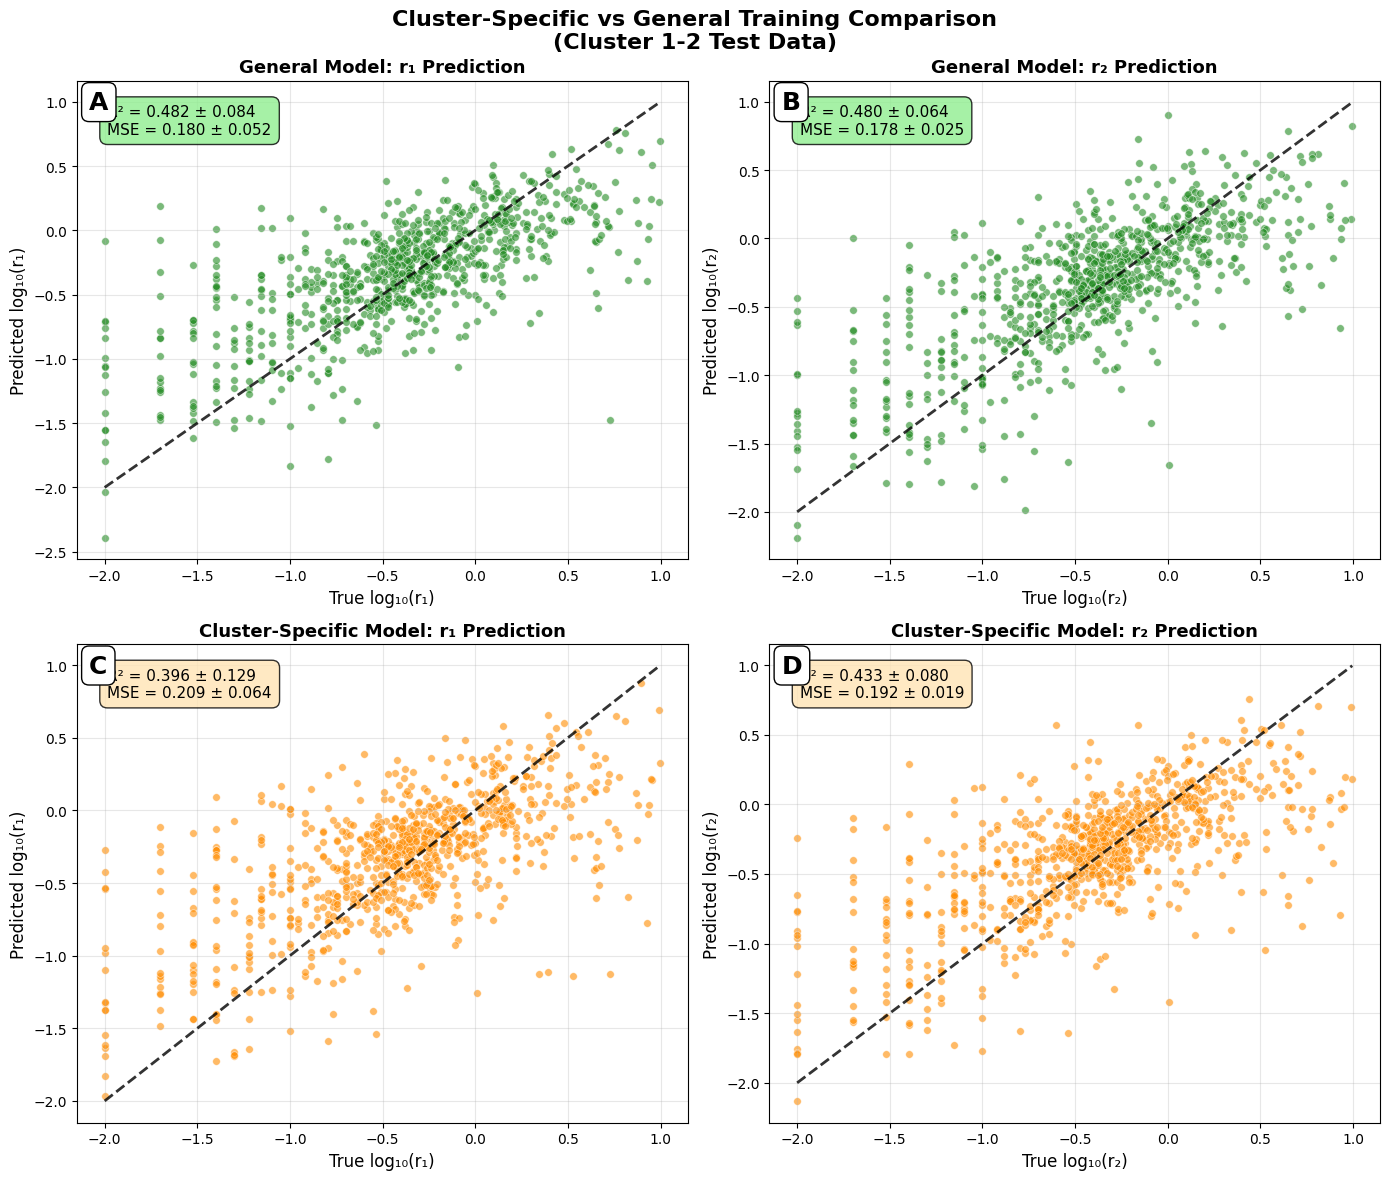

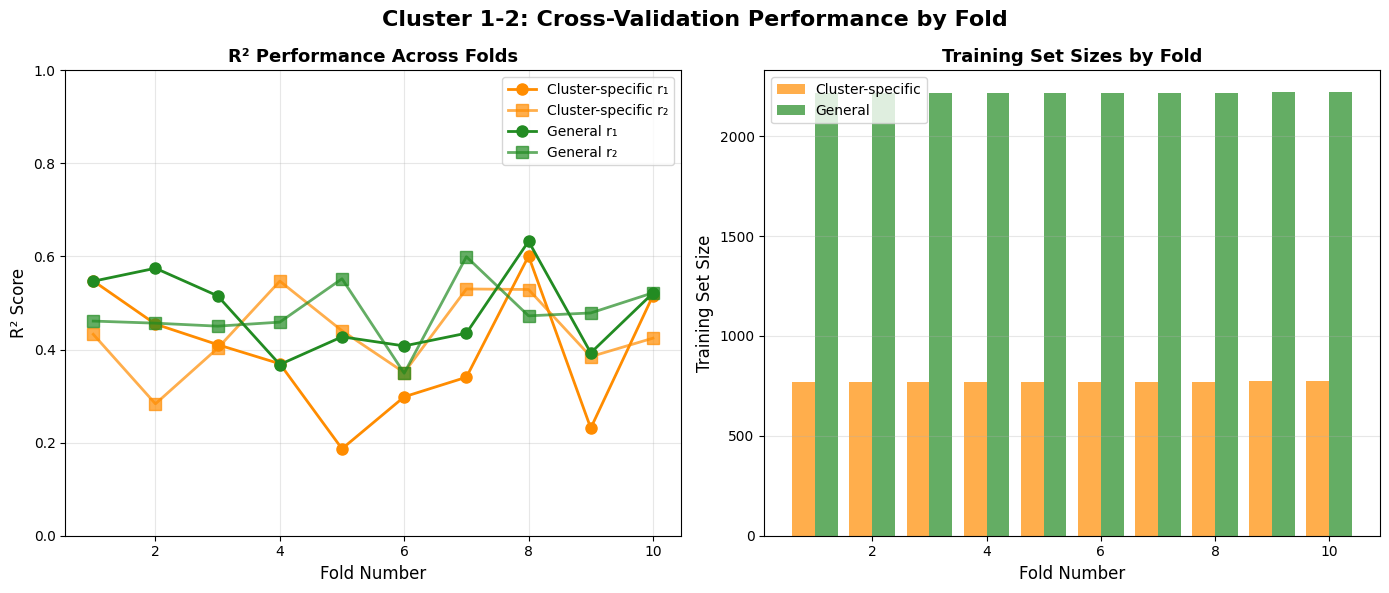

In [7]:
"""
Improved Cluster 1-2 Specific Training Analysis with Fair Cross-Validation
========================================================================

This script implements a rigorous comparison between:
1. Cluster-specific training (trained only on Cluster 1-2 interactions)
2. General training (trained on all available data except test set)

Key improvements over previous approach:
- Both models tested on IDENTICAL test sets
- General model uses ALL available training data (no artificial size limitations)
- True test of whether chemical specificity helps vs. data diversity
- Proper 10-fold cross-validation with statistical reporting

Note: Cluster 1-2 includes both (Cluster_A=1, Cluster_B=2) and (Cluster_A=2, Cluster_B=1)
since these represent the same interaction type.
"""

import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from rdkit import Chem
from rdkit.Chem import rdMolDescriptors
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Set random seeds for reproducibility
np.random.seed(142)  # Different seed from 1-1 to ensure independence
tf.random.set_seed(142)

# Configuration
CONFIG = {
    'morgan_radius': 3,
    'morgan_bits': 2048,
    'neurons_l1': 80,
    'neurons_l2': 40,
    'learning_rate': 0.001,
    'batch_size': 32,
    'max_epochs': 200,
    'validation_split': 0.1,
    'patience': 30,
    'cv_folds': 10
}

def generate_morgan_fingerprint(smiles):
    """Generate Morgan fingerprint from SMILES string"""
    try:
        mol = Chem.MolFromSmiles(smiles)
        if mol is None:
            return np.zeros(CONFIG['morgan_bits'], dtype=np.float32)
        
        fp = rdMolDescriptors.GetMorganFingerprintAsBitVect(
            mol, CONFIG['morgan_radius'], nBits=CONFIG['morgan_bits']
        )
        return np.array(fp, dtype=np.float32)
    except:
        return np.zeros(CONFIG['morgan_bits'], dtype=np.float32)

def prepare_features_and_targets(data_subset):
    """Prepare Morgan fingerprint features and log-transformed targets"""
    # Generate Morgan fingerprints for both monomers
    fp_A = np.array([generate_morgan_fingerprint(smiles) for smiles in data_subset['SMILES_A']])
    fp_B = np.array([generate_morgan_fingerprint(smiles) for smiles in data_subset['SMILES_B']])
    
    # Concatenate fingerprints
    X = np.concatenate([fp_A, fp_B], axis=1)
    
    # Log-transformed targets
    y = np.column_stack([
        np.log10(data_subset['r1'].values),
        np.log10(data_subset['r2'].values)
    ])
    
    return X.astype(np.float32), y.astype(np.float32)

def create_neural_network(input_dim):
    """Create the neural network architecture"""
    model = Sequential([
        Dense(CONFIG['neurons_l1'], activation='relu', input_shape=(input_dim,)),
        Dense(CONFIG['neurons_l2'], activation='relu'), 
        Dense(2, activation='linear')  # Output: [log10(r1), log10(r2)]
    ])
    
    model.compile(
        optimizer=Adam(learning_rate=CONFIG['learning_rate']),
        loss='mse',
        metrics=['mae']
    )
    
    return model

def train_and_evaluate_model(X_train, y_train, X_test, y_test, model_name):
    """Train model and return evaluation metrics"""
    # Clear previous session
    tf.keras.backend.clear_session()
    
    # Create and train model
    model = create_neural_network(X_train.shape[1])
    
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=CONFIG['patience'],
        restore_best_weights=True,
        verbose=0
    )
    
    model.fit(
        X_train, y_train,
        epochs=CONFIG['max_epochs'],
        batch_size=CONFIG['batch_size'],
        validation_split=CONFIG['validation_split'],
        callbacks=[early_stopping],
        verbose=0
    )
    
    # Make predictions
    y_pred = model.predict(X_test, verbose=0)
    
    # Calculate metrics
    metrics = {
        'r2_r1': r2_score(y_test[:, 0], y_pred[:, 0]),
        'r2_r2': r2_score(y_test[:, 1], y_pred[:, 1]),
        'mse_r1': mean_squared_error(y_test[:, 0], y_pred[:, 0]),
        'mse_r2': mean_squared_error(y_test[:, 1], y_pred[:, 1])
    }
    
    return metrics, y_pred

def main_analysis_cluster_12(df):
    """Main analysis function for Cluster 1-2 interactions"""
    print("Starting Improved Cluster 1-2 Specific Training Analysis")
    print("=" * 65)
    
    # Data preparation
    print("Preparing data...")
    data = df.copy()
    
    # Filter for valid data
    data = data[
        (data['r1'] > 0) & (data['r2'] > 0) &
        data['SMILES_A'].notna() & data['SMILES_B'].notna()
    ].reset_index(drop=True)
    
    print(f"Total dataset size after filtering: {len(data)}")
    
    # Extract Cluster 1-2 interactions (includes both 1-2 and 2-1)
    cluster_12_mask = ((data['Cluster_A'] == 1) & (data['Cluster_B'] == 2)) | \
                      ((data['Cluster_A'] == 2) & (data['Cluster_B'] == 1))
    cluster_12_indices = data.index[cluster_12_mask].tolist()
    
    print(f"Cluster 1-2 interactions (including 2-1): {len(cluster_12_indices)}")
    
    if len(cluster_12_indices) < 100:
        raise ValueError("Insufficient Cluster 1-2 samples for 10-fold CV")
    
    # Prepare features for entire dataset (for efficiency)
    print("Generating Morgan fingerprints for entire dataset...")
    X_all, y_all = prepare_features_and_targets(data)
    
    # Cross-validation setup
    kfold = KFold(n_splits=CONFIG['cv_folds'], shuffle=True, random_state=142)
    
    # Storage for results
    results = {
        'cluster_specific': [],
        'general': [],
        'fold_details': []
    }
    
    # Storage for predictions (for parity plots)
    all_y_true = []
    all_y_pred_cluster = []
    all_y_pred_general = []
    
    print(f"\nStarting {CONFIG['cv_folds']}-fold cross-validation...")
    print("-" * 65)
    
    # Cross-validation loop
    for fold, (train_idx, test_idx) in enumerate(kfold.split(cluster_12_indices)):
        fold_num = fold + 1
        print(f"Processing Fold {fold_num}/{CONFIG['cv_folds']}...")
        
        # Get actual data indices for this fold
        cluster_train_indices = [cluster_12_indices[i] for i in train_idx]
        cluster_test_indices = [cluster_12_indices[i] for i in test_idx]
        
        # Prepare test set (same for both models)
        X_test = X_all[cluster_test_indices]
        y_test = y_all[cluster_test_indices]
        
        # Prepare cluster-specific training set
        X_cluster_train = X_all[cluster_train_indices]
        y_cluster_train = y_all[cluster_train_indices]
        
        # Prepare general training set (all data except current test set)
        general_train_indices = [i for i in range(len(data)) if i not in cluster_test_indices]
        X_general_train = X_all[general_train_indices]
        y_general_train = y_all[general_train_indices]
        
        # Train and evaluate cluster-specific model
        cluster_metrics, y_pred_cluster = train_and_evaluate_model(
            X_cluster_train, y_cluster_train, X_test, y_test, 'cluster'
        )
        
        # Train and evaluate general model  
        general_metrics, y_pred_general = train_and_evaluate_model(
            X_general_train, y_general_train, X_test, y_test, 'general'
        )
        
        # Store results
        results['cluster_specific'].append(cluster_metrics)
        results['general'].append(general_metrics)
        
        # Store fold details
        fold_info = {
            'fold': fold_num,
            'test_size': len(cluster_test_indices),
            'cluster_train_size': len(cluster_train_indices),
            'general_train_size': len(general_train_indices),
            'cluster_r2_r1': cluster_metrics['r2_r1'],
            'cluster_r2_r2': cluster_metrics['r2_r2'],
            'general_r2_r1': general_metrics['r2_r1'],
            'general_r2_r2': general_metrics['r2_r2']
        }
        results['fold_details'].append(fold_info)
        
        # Store predictions for parity plots
        all_y_true.append(y_test)
        all_y_pred_cluster.append(y_pred_cluster)
        all_y_pred_general.append(y_pred_general)
        
        # Print fold summary
        print(f"  Test size: {len(cluster_test_indices)}, "
              f"Cluster train: {len(cluster_train_indices)}, "
              f"General train: {len(general_train_indices)}")
        print(f"  Cluster-specific R²: r1={cluster_metrics['r2_r1']:.3f}, r2={cluster_metrics['r2_r2']:.3f}")
        print(f"  General R²: r1={general_metrics['r2_r1']:.3f}, r2={general_metrics['r2_r2']:.3f}")
        print()
    
    # Calculate cross-validation statistics
    print("Calculating cross-validation statistics...")
    
    def calculate_cv_stats(metric_list, metric_name):
        values = np.array([m[metric_name] for m in metric_list])
        return {
            f'{metric_name}_mean': values.mean(),
            f'{metric_name}_std': values.std()
        }
    
    # Calculate stats for all metrics
    cluster_stats = {}
    general_stats = {}
    
    for metric in ['r2_r1', 'r2_r2', 'mse_r1', 'mse_r2']:
        cluster_stats.update(calculate_cv_stats(results['cluster_specific'], metric))
        general_stats.update(calculate_cv_stats(results['general'], metric))
    
    # Print final results
    print("\n" + "=" * 65)
    print("FINAL CROSS-VALIDATION RESULTS")
    print("=" * 65)
    
    print(f"\nCLUSTER-SPECIFIC MODEL (Cluster 1-2 training):")
    print(f"  R² r1: {cluster_stats['r2_r1_mean']:.3f} ± {cluster_stats['r2_r1_std']:.3f}")
    print(f"  R² r2: {cluster_stats['r2_r2_mean']:.3f} ± {cluster_stats['r2_r2_std']:.3f}")
    print(f"  MSE r1: {cluster_stats['mse_r1_mean']:.3f} ± {cluster_stats['mse_r1_std']:.3f}")
    print(f"  MSE r2: {cluster_stats['mse_r2_mean']:.3f} ± {cluster_stats['mse_r2_std']:.3f}")
    
    print(f"\nGENERAL MODEL (All data training):")
    print(f"  R² r1: {general_stats['r2_r1_mean']:.3f} ± {general_stats['r2_r1_std']:.3f}")
    print(f"  R² r2: {general_stats['r2_r2_mean']:.3f} ± {general_stats['r2_r2_std']:.3f}")
    print(f"  MSE r1: {general_stats['mse_r1_mean']:.3f} ± {general_stats['mse_r1_std']:.3f}")
    print(f"  MSE r2: {general_stats['mse_r2_mean']:.3f} ± {general_stats['mse_r2_std']:.3f}")
    
    # Statistical significance testing
    print(f"\nSTATISTICAL SIGNIFICANCE TESTS:")
    cluster_r2_r1 = [m['r2_r1'] for m in results['cluster_specific']]
    general_r2_r1 = [m['r2_r1'] for m in results['general']]
    cluster_r2_r2 = [m['r2_r2'] for m in results['cluster_specific']]
    general_r2_r2 = [m['r2_r2'] for m in results['general']]
    
    t_stat_r1, p_val_r1 = stats.ttest_rel(cluster_r2_r1, general_r2_r1)
    t_stat_r2, p_val_r2 = stats.ttest_rel(cluster_r2_r2, general_r2_r2)
    
    print(f"  Paired t-test for R² r1: t={t_stat_r1:.3f}, p={p_val_r1:.4f}")
    print(f"  Paired t-test for R² r2: t={t_stat_r2:.3f}, p={p_val_r2:.4f}")
    
    # Create comprehensive parity plots
    create_parity_plots_cluster_12(all_y_true, all_y_pred_cluster, all_y_pred_general, 
                                   cluster_stats, general_stats)
    
    # Create fold comparison plot
    create_fold_comparison_plot_cluster_12(results['fold_details'])
    
    return results, cluster_stats, general_stats

def create_parity_plots_cluster_12(all_y_true, all_y_pred_cluster, all_y_pred_general, 
                                   cluster_stats, general_stats):
    """Create comprehensive parity plots for Cluster 1-2"""
    # Concatenate all predictions
    y_true_all = np.vstack(all_y_true)
    y_pred_cluster_all = np.vstack(all_y_pred_cluster)
    y_pred_general_all = np.vstack(all_y_pred_general)
    
    # Set up the plot
    fig, axes = plt.subplots(2, 2, figsize=(14, 12))
    fig.suptitle('Cluster-Specific vs General Training Comparison\n(Cluster 1-2 Test Data)', 
                 fontsize=16, fontweight='bold')
    
    # Color scheme for 1-2 interactions
    colors = {'general': '#228B22', 'cluster': '#FF8C00'}  # Green and Orange
    
    # Plot parameters
    alpha = 0.6
    s = 30
    
    # General model plots
    # R1
    axes[0,0].scatter(y_true_all[:,0], y_pred_general_all[:,0], 
                     alpha=alpha, color=colors['general'], s=s, edgecolors='white', linewidth=0.5)
    min_val, max_val = y_true_all[:,0].min(), y_true_all[:,0].max()
    axes[0,0].plot([min_val, max_val], [min_val, max_val], 'k--', lw=2, alpha=0.8)
    axes[0,0].set_xlabel('True log₁₀(r₁)', fontsize=12)
    axes[0,0].set_ylabel('Predicted log₁₀(r₁)', fontsize=12)
    axes[0,0].set_title('General Model: r₁ Prediction', fontsize=13, fontweight='bold')
    axes[0,0].grid(True, alpha=0.3)
    
    # Add statistics box
    stats_text = f"R² = {general_stats['r2_r1_mean']:.3f} ± {general_stats['r2_r1_std']:.3f}\nMSE = {general_stats['mse_r1_mean']:.3f} ± {general_stats['mse_r1_std']:.3f}"
    axes[0,0].text(0.05, 0.95, stats_text, transform=axes[0,0].transAxes, 
                   fontsize=11, verticalalignment='top',
                   bbox=dict(boxstyle='round,pad=0.5', facecolor='lightgreen', alpha=0.8))
    
    # Panel label
    axes[0,0].text(0.02, 0.98, 'A', transform=axes[0,0].transAxes, 
                   fontsize=18, fontweight='bold', va='top',
                   bbox=dict(boxstyle="round,pad=0.3", facecolor='white', edgecolor='black'))
    
    # R2
    axes[0,1].scatter(y_true_all[:,1], y_pred_general_all[:,1], 
                     alpha=alpha, color=colors['general'], s=s, edgecolors='white', linewidth=0.5)
    min_val, max_val = y_true_all[:,1].min(), y_true_all[:,1].max()
    axes[0,1].plot([min_val, max_val], [min_val, max_val], 'k--', lw=2, alpha=0.8)
    axes[0,1].set_xlabel('True log₁₀(r₂)', fontsize=12)
    axes[0,1].set_ylabel('Predicted log₁₀(r₂)', fontsize=12)
    axes[0,1].set_title('General Model: r₂ Prediction', fontsize=13, fontweight='bold')
    axes[0,1].grid(True, alpha=0.3)
    
    # Add statistics box
    stats_text = f"R² = {general_stats['r2_r2_mean']:.3f} ± {general_stats['r2_r2_std']:.3f}\nMSE = {general_stats['mse_r2_mean']:.3f} ± {general_stats['mse_r2_std']:.3f}"
    axes[0,1].text(0.05, 0.95, stats_text, transform=axes[0,1].transAxes, 
                   fontsize=11, verticalalignment='top',
                   bbox=dict(boxstyle='round,pad=0.5', facecolor='lightgreen', alpha=0.8))
    
    # Panel label
    axes[0,1].text(0.02, 0.98, 'B', transform=axes[0,1].transAxes, 
                   fontsize=18, fontweight='bold', va='top',
                   bbox=dict(boxstyle="round,pad=0.3", facecolor='white', edgecolor='black'))
    
    # Cluster-specific model plots
    # R1
    axes[1,0].scatter(y_true_all[:,0], y_pred_cluster_all[:,0], 
                     alpha=alpha, color=colors['cluster'], s=s, edgecolors='white', linewidth=0.5)
    min_val, max_val = y_true_all[:,0].min(), y_true_all[:,0].max()
    axes[1,0].plot([min_val, max_val], [min_val, max_val], 'k--', lw=2, alpha=0.8)
    axes[1,0].set_xlabel('True log₁₀(r₁)', fontsize=12)
    axes[1,0].set_ylabel('Predicted log₁₀(r₁)', fontsize=12)
    axes[1,0].set_title('Cluster-Specific Model: r₁ Prediction', fontsize=13, fontweight='bold')
    axes[1,0].grid(True, alpha=0.3)
    
    # Add statistics box
    stats_text = f"R² = {cluster_stats['r2_r1_mean']:.3f} ± {cluster_stats['r2_r1_std']:.3f}\nMSE = {cluster_stats['mse_r1_mean']:.3f} ± {cluster_stats['mse_r1_std']:.3f}"
    axes[1,0].text(0.05, 0.95, stats_text, transform=axes[1,0].transAxes, 
                   fontsize=11, verticalalignment='top',
                   bbox=dict(boxstyle='round,pad=0.5', facecolor='moccasin', alpha=0.8))
    
    # Panel label
    axes[1,0].text(0.02, 0.98, 'C', transform=axes[1,0].transAxes, 
                   fontsize=18, fontweight='bold', va='top',
                   bbox=dict(boxstyle="round,pad=0.3", facecolor='white', edgecolor='black'))
    
    # R2
    axes[1,1].scatter(y_true_all[:,1], y_pred_cluster_all[:,1], 
                     alpha=alpha, color=colors['cluster'], s=s, edgecolors='white', linewidth=0.5)
    min_val, max_val = y_true_all[:,1].min(), y_true_all[:,1].max()
    axes[1,1].plot([min_val, max_val], [min_val, max_val], 'k--', lw=2, alpha=0.8)
    axes[1,1].set_xlabel('True log₁₀(r₂)', fontsize=12)
    axes[1,1].set_ylabel('Predicted log₁₀(r₂)', fontsize=12)
    axes[1,1].set_title('Cluster-Specific Model: r₂ Prediction', fontsize=13, fontweight='bold')
    axes[1,1].grid(True, alpha=0.3)
    
    # Add statistics box
    stats_text = f"R² = {cluster_stats['r2_r2_mean']:.3f} ± {cluster_stats['r2_r2_std']:.3f}\nMSE = {cluster_stats['mse_r2_mean']:.3f} ± {cluster_stats['mse_r2_std']:.3f}"
    axes[1,1].text(0.05, 0.95, stats_text, transform=axes[1,1].transAxes, 
                   fontsize=11, verticalalignment='top',
                   bbox=dict(boxstyle='round,pad=0.5', facecolor='moccasin', alpha=0.8))
    
    # Panel label
    axes[1,1].text(0.02, 0.98, 'D', transform=axes[1,1].transAxes, 
                   fontsize=18, fontweight='bold', va='top',
                   bbox=dict(boxstyle="round,pad=0.3", facecolor='white', edgecolor='black'))
    
    plt.tight_layout()
    plt.savefig('cluster_specific_1-2_analysis_parity_plots.png', dpi=300, bbox_inches='tight')
    plt.show()

def create_fold_comparison_plot_cluster_12(fold_details):
    """Create plot comparing performance across folds for Cluster 1-2"""
    fold_df = pd.DataFrame(fold_details)
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    fig.suptitle('Cluster 1-2: Cross-Validation Performance by Fold', fontsize=16, fontweight='bold')
    
    x = fold_df['fold']
    
    # R² comparison
    axes[0].plot(x, fold_df['cluster_r2_r1'], 'o-', color='#FF8C00', label='Cluster-specific r₁', linewidth=2, markersize=8)
    axes[0].plot(x, fold_df['cluster_r2_r2'], 's-', color='#FF8C00', label='Cluster-specific r₂', linewidth=2, markersize=8, alpha=0.7)
    axes[0].plot(x, fold_df['general_r2_r1'], 'o-', color='#228B22', label='General r₁', linewidth=2, markersize=8)
    axes[0].plot(x, fold_df['general_r2_r2'], 's-', color='#228B22', label='General r₂', linewidth=2, markersize=8, alpha=0.7)
    
    axes[0].set_xlabel('Fold Number', fontsize=12)
    axes[0].set_ylabel('R² Score', fontsize=12)
    axes[0].set_title('R² Performance Across Folds', fontsize=13, fontweight='bold')
    axes[0].legend(loc='best')
    axes[0].grid(True, alpha=0.3)
    axes[0].set_ylim(0, 1)
    
    # Training set sizes
    axes[1].bar(x - 0.2, fold_df['cluster_train_size'], width=0.4, 
                color='#FF8C00', alpha=0.7, label='Cluster-specific')
    axes[1].bar(x + 0.2, fold_df['general_train_size'], width=0.4, 
                color='#228B22', alpha=0.7, label='General')
    
    axes[1].set_xlabel('Fold Number', fontsize=12)
    axes[1].set_ylabel('Training Set Size', fontsize=12)
    axes[1].set_title('Training Set Sizes by Fold', fontsize=13, fontweight='bold')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.savefig('cluster_1-2_cross_validation_fold_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()

# Example usage:
if __name__ == "__main__":
    # Assuming 'df' is your dataframe with columns:
    # 'SMILES_A', 'SMILES_B', 'r1', 'r2', 'Cluster_A', 'Cluster_B'
    
    print("To run this analysis for Cluster 1-2 interactions, call:")
    print("results, cluster_stats, general_stats = main_analysis_cluster_12(df)")
    print("\nWhere 'df' should contain columns:")
    print("- SMILES_A: SMILES string for monomer A")  
    print("- SMILES_B: SMILES string for monomer B")
    print("- r1, r2: Reactivity ratios")
    print("- Cluster_A, Cluster_B: Cluster assignments (1, 2, 3)")
    print("\nNote: This analysis includes both (1,2) and (2,1) interactions")
    print("as they represent the same chemical interaction type.")

results, cluster_stats, general_stats = main_analysis_cluster_12(df)


Dataset after QC: 2304 rows
Cluster 1–2 samples: 858

Starting 10-fold CV on Cluster 1–2...
Fold 01 | n_train= 772 | General R²: r1=0.523, r2=0.428 | Cluster R²: r1=0.562, r2=0.484
Fold 02 | n_train= 772 | General R²: r1=0.335, r2=0.482 | Cluster R²: r1=0.462, r2=0.418
Fold 03 | n_train= 772 | General R²: r1=0.001, r2=0.376 | Cluster R²: r1=0.538, r2=0.279
Fold 04 | n_train= 772 | General R²: r1=0.326, r2=0.463 | Cluster R²: r1=0.365, r2=0.537
Fold 05 | n_train= 772 | General R²: r1=0.405, r2=0.289 | Cluster R²: r1=0.187, r2=0.350
Fold 06 | n_train= 772 | General R²: r1=0.286, r2=0.388 | Cluster R²: r1=0.339, r2=0.384
Fold 07 | n_train= 772 | General R²: r1=0.252, r2=0.202 | Cluster R²: r1=0.372, r2=0.333
Fold 08 | n_train= 772 | General R²: r1=0.474, r2=0.375 | Cluster R²: r1=0.509, r2=0.595
Fold 09 | n_train= 773 | General R²: r1=0.346, r2=0.324 | Cluster R²: r1=0.493, r2=0.408
Fold 10 | n_train= 773 | General R²: r1=0.545, r2=0.626 | Cluster R²: r1=0.444, r2=0.585

GENERAL model (10

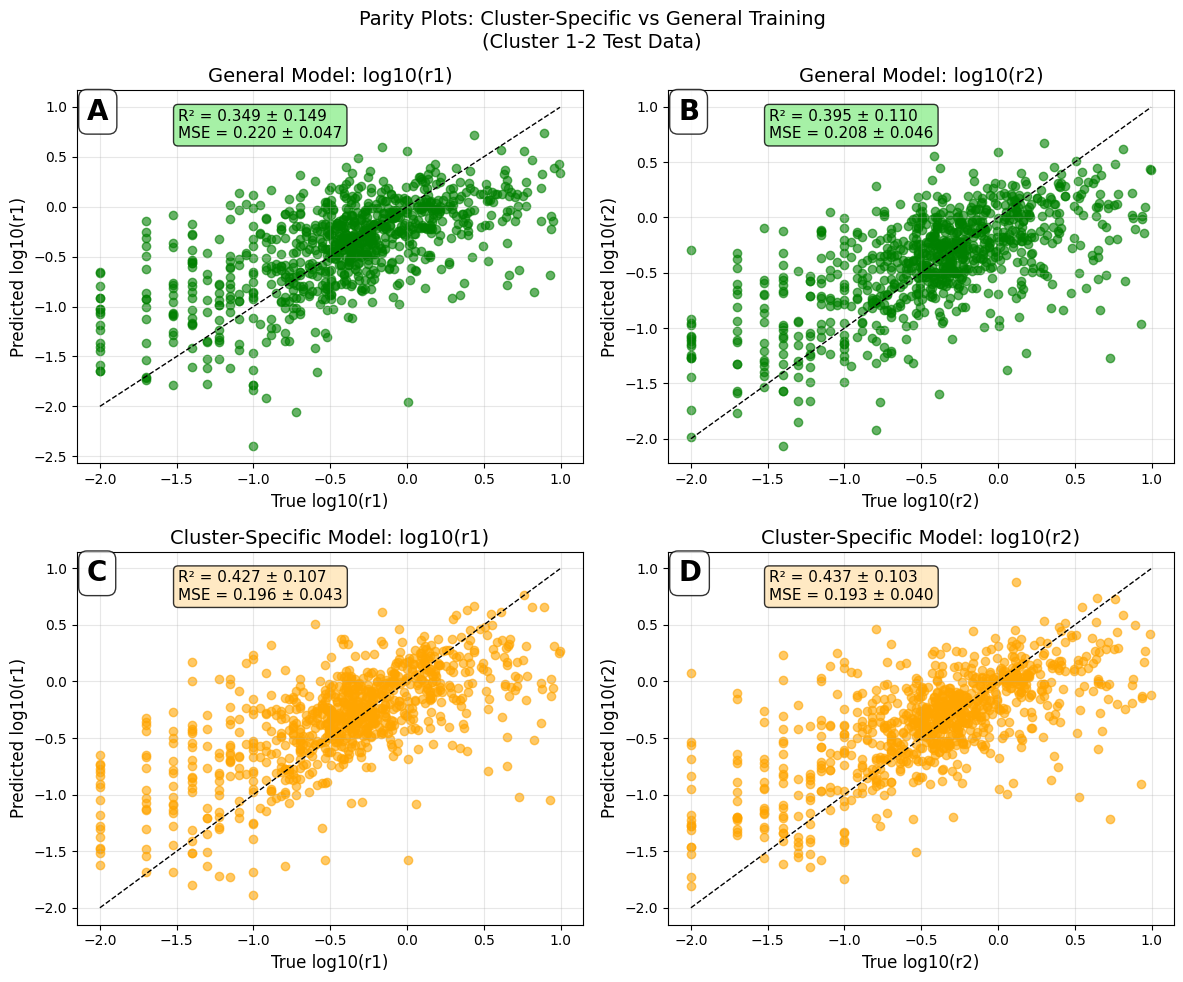


Experiment completed successfully!
Total test samples across all folds: 858

Summary Statistics (Mean ± SD across 10 folds):
General Model:
  R² r1: 0.349 ± 0.149
  R² r2: 0.395 ± 0.110
  MSE r1: 0.220 ± 0.047
  MSE r2: 0.208 ± 0.046

Cluster-Specific Model:
  R² r1: 0.427 ± 0.107
  R² r2: 0.437 ± 0.103
  MSE r1: 0.196 ± 0.043
  MSE r2: 0.193 ± 0.040


In [5]:
"""
Controlled Experiment: Cluster 1–2 vs. General Training (Morgan-only)
--------------------------------------------------------------------
Goal:
  For predicting reactivity ratios (r1, r2) on a specific interaction (Cluster 1–2),
  test whether training:
    (A) on the *same* interaction subset (cluster-specific), or
    (B) on a *random* subset of the entire dataset of equal size (general)
  yields better performance.

Design:
  • Inputs: Morgan fingerprints only (concatenate A and B).
  • Targets: log10(r1), log10(r2).
  • 10-fold CV over *Cluster 1–2* samples:
      - Each fold's test set is fixed (Cluster 1–2 only).
      - Cluster-specific TRAIN = the remaining Cluster 1–2 samples in that fold.
      - General TRAIN = random subset from the whole dataset (same size as cluster train), excluding this fold's test rows.
  • Compare R² and MSE on the identical Cluster 1–2 test sets.

Why this is fair:
  Both models see the *exact same* number of training samples in each fold,
  and are evaluated on the *exact same* test items (Cluster 1–2).
"""

# =========================
# Imports & Config
# =========================
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from rdkit import Chem
from rdkit.Chem import rdMolDescriptors
import matplotlib.pyplot as plt

# ---- Reproducibility (important for fair comparisons) ----
np.random.seed(42)
tf.random.set_seed(42)

# ---- Morgan fingerprint hyperparameters ----
MORGAN_RADIUS = 3
MORGAN_BITS   = 2048  # per monomer (A and B -> 4096 total features)

# ---- DNN hyperparameters (kept simple & consistent) ----
NEURONS_L1       = 80
NEURONS_L2       = 40
LEARNING_RATE    = 1e-3
BATCH_SIZE       = 32
MAX_EPOCHS       = 200
VALIDATION_SPLIT = 0.10
PATIENCE         = 30

# ---- Visualization look (optional) ----
plt.rcParams.update({'font.size': 12})

# =========================
# Helper functions
# =========================
def get_morgan_fp(smiles: str) -> np.ndarray:
    """
    Convert a SMILES string into a Morgan fingerprint bit vector (as float32).
    Returns an all-zero vector if SMILES cannot be parsed.
    """
    try:
        mol = Chem.MolFromSmiles(smiles)
        if mol is None:
            return np.zeros(MORGAN_BITS, dtype=np.float32)
        fp = rdMolDescriptors.GetMorganFingerprintAsBitVect(
            mol, MORGAN_RADIUS, nBits=MORGAN_BITS
        )
        return np.array(fp, dtype=np.float32)
    except Exception:
        return np.zeros(MORGAN_BITS, dtype=np.float32)

def build_model(n_inputs: int) -> tf.keras.Model:
    """
    Simple 2-hidden-layer DNN predicting [log10(r1), log10(r2)].
    Matches your previous architecture spirit and keeps capacity modest.
    """
    model = Sequential([
        Dense(NEURONS_L1, activation='relu', input_shape=(n_inputs,)),
        Dense(NEURONS_L2, activation='relu'),
        Dense(2, activation='linear')  # outputs: [log10(r1), log10(r2)]
    ])
    model.compile(
        optimizer=Adam(learning_rate=LEARNING_RATE),
        loss='mse',
        metrics=['mae']
    )
    return model

def metrics_dict(y_true: np.ndarray, y_pred: np.ndarray) -> dict:
    """
    Convenience wrapper: compute R² and MSE for both outputs.
    y_* are shaped (n, 2) on log10 scale.
    """
    return {
        'r2_r1':  r2_score(y_true[:, 0], y_pred[:, 0]),
        'r2_r2':  r2_score(y_true[:, 1], y_pred[:, 1]),
        'mse_r1': mean_squared_error(y_true[:, 0], y_pred[:, 0]),
        'mse_r2': mean_squared_error(y_true[:, 1], y_pred[:, 1]),
    }

def extract_Xy(df_subset: pd.DataFrame) -> tuple[np.ndarray, np.ndarray]:
    """
    Build Morgan-only features for a dataframe subset and grab targets.
    Feature = [Morgan(SMILES_A) || Morgan(SMILES_B)]  -> shape = (n, 4096)
    Target  = [log10(r1), log10(r2)]                 -> shape = (n, 2)
    """
    fpA = np.array([get_morgan_fp(s) for s in df_subset['SMILES_A']])
    fpB = np.array([get_morgan_fp(s) for s in df_subset['SMILES_B']])
    X   = np.concatenate([fpA, fpB], axis=1)
    y   = df_subset[['r1_log', 'r2_log']].values.astype(np.float32)
    return X, y

# =========================
# Data preparation
# =========================
# Expect: df exists with required columns. Copy & basic quality filters.
data = df.copy()

# Filter: valid positive ratios; drop rows missing SMILES
data = data[(data['r1'] > 0) & (data['r2'] > 0)].dropna(subset=['SMILES_A', 'SMILES_B'])

# Targets on log scale (symmetric error treatment for ratios)
data['r1_log'] = np.log10(data['r1'])
data['r2_log'] = np.log10(data['r2'])

print(f"Dataset after QC: {len(data)} rows")

# =========================
# Select Cluster 1–2 interaction rows
# =========================
# For 1–2, one monomer belongs to Cluster 1, the other to Cluster 2.
# This includes both (1,2) and (2,1) orderings since they represent the same interaction type.
mask_12 = ((data['Cluster_A'] == 1) & (data['Cluster_B'] == 2)) | \
          ((data['Cluster_A'] == 2) & (data['Cluster_B'] == 1))
cluster12_idx = data.index[mask_12].to_numpy()
print(f"Cluster 1–2 samples: {len(cluster12_idx)}")

if len(cluster12_idx) < 100:
    raise ValueError("Not enough Cluster 1–2 samples for 10-fold CV. Need at least ~100.")

# Precompute features for the *entire* dataset once (saves time)
X_all, y_all = extract_Xy(data)

# Quick index mapping utility: map dataframe indices to row positions
# (so we can slice X_all / y_all quickly).
pos_map = {idx: pos for pos, idx in enumerate(data.index)}

# =========================
# 10-fold CV over Cluster 1–2 indices
# =========================
kf = KFold(n_splits=10, shuffle=True, random_state=42)

results = {
    'general': [],  # metrics per fold for general model
    'cluster': []   # metrics per fold for cluster-specific model
}

# Store all predictions for parity plots
all_y_true = []
all_y_pred_general = []
all_y_pred_cluster = []

print("\nStarting 10-fold CV on Cluster 1–2...")
for fold, (train_ids_pos, test_ids_pos) in enumerate(kf.split(cluster12_idx), start=1):
    # 1) Identify actual df indices for this fold's cluster train/test
    cluster_train_ids = cluster12_idx[train_ids_pos]
    cluster_test_ids  = cluster12_idx[test_ids_pos]

    # 2) Build the *fixed* test set (Cluster 1–2 only)
    test_positions = [pos_map[i] for i in cluster_test_ids]
    X_test = X_all[test_positions]
    y_test = y_all[test_positions]

    # 3) Cluster-specific training set (Cluster 1–2 only)
    cluster_train_positions = [pos_map[i] for i in cluster_train_ids]
    X_cluster_tr = X_all[cluster_train_positions]
    y_cluster_tr = y_all[cluster_train_positions]

    # 4) General training set: random sample of the same size from ALL data,
    #    ensuring we DO NOT "peek" at this fold's test rows.
    #    (We exclude the fold's test indices from the sampling pool.)
    available_pool = data.index.difference(cluster_test_ids).to_numpy()
    n_train = len(cluster_train_ids)  # enforce identical training size

    if len(available_pool) < n_train:
        raise ValueError(f"Fold {fold}: not enough available rows for general sampling.")

    # Use different random seed base for cluster 1-2 experiment to ensure independence
    rng = np.random.default_rng(142 + fold)  # per-fold reproducibility
    general_train_ids = rng.choice(available_pool, size=n_train, replace=False)
    general_train_positions = [pos_map[i] for i in general_train_ids]
    X_general_tr = X_all[general_train_positions]
    y_general_tr = y_all[general_train_positions]

    # 5) Train both models with identical settings
    def train_and_eval(Xtr, ytr, model_type):
        tf.keras.backend.clear_session()
        model = build_model(Xtr.shape[1])
        es = EarlyStopping(monitor='val_loss', patience=PATIENCE,
                           restore_best_weights=True, verbose=0)
        model.fit(
            Xtr, ytr,
            epochs=MAX_EPOCHS,
            batch_size=BATCH_SIZE,
            validation_split=VALIDATION_SPLIT,
            callbacks=[es],
            verbose=0
        )
        yhat = model.predict(X_test, verbose=0)
        return metrics_dict(y_test, yhat), yhat

    general_metrics, y_pred_general = train_and_eval(X_general_tr, y_general_tr, 'general')
    cluster_metrics, y_pred_cluster = train_and_eval(X_cluster_tr, y_cluster_tr, 'cluster')

    results['general'].append(general_metrics)
    results['cluster'].append(cluster_metrics)
    
    # Store predictions for parity plots
    all_y_true.append(y_test)
    all_y_pred_general.append(y_pred_general)
    all_y_pred_cluster.append(y_pred_cluster)

    # Short fold summary
    print(
        f"Fold {fold:02d} | n_train={n_train:4d} | "
        f"General R²: r1={general_metrics['r2_r1']:.3f}, r2={general_metrics['r2_r2']:.3f} | "
        f"Cluster R²: r1={cluster_metrics['r2_r1']:.3f}, r2={cluster_metrics['r2_r2']:.3f}"
    )

# =========================
# Aggregate & report
# =========================
def summarize(label, records):
    r2r1 = np.array([r['r2_r1']  for r in records])
    r2r2 = np.array([r['r2_r2']  for r in records])
    mser1= np.array([r['mse_r1'] for r in records])
    mser2= np.array([r['mse_r2'] for r in records])
    print(f"\n{label} (10-fold CV):")
    print(f"  R² r1: {r2r1.mean():.3f} ± {r2r1.std():.3f}")
    print(f"  R² r2: {r2r2.mean():.3f} ± {r2r2.std():.3f}")
    print(f"  MSE r1: {mser1.mean():.3f} ± {mser1.std():.3f}")
    print(f"  MSE r2: {mser2.mean():.3f} ± {mser2.std():.3f}")

summarize("GENERAL model", results['general'])
summarize("CLUSTER-SPECIFIC (1–2) model", results['cluster'])

# =========================
# Calculate fold-wise metrics for mean ± SD display
# =========================

# Extract fold-wise metrics
general_r2_r1 = np.array([r['r2_r1'] for r in results['general']])
general_r2_r2 = np.array([r['r2_r2'] for r in results['general']])
general_mse_r1 = np.array([r['mse_r1'] for r in results['general']])
general_mse_r2 = np.array([r['mse_r2'] for r in results['general']])

cluster_r2_r1 = np.array([r['r2_r1'] for r in results['cluster']])
cluster_r2_r2 = np.array([r['r2_r2'] for r in results['cluster']])
cluster_mse_r1 = np.array([r['mse_r1'] for r in results['cluster']])
cluster_mse_r2 = np.array([r['mse_r2'] for r in results['cluster']])

# =========================
# Parity plots with mean ± SD metrics
# =========================
# Concatenate all predictions across folds (for plotting points)
y_true_all = np.vstack(all_y_true)
y_pred_general_all = np.vstack(all_y_pred_general)
y_pred_cluster_all = np.vstack(all_y_pred_cluster)

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
fig.suptitle('Parity Plots: Cluster-Specific vs General Training\n(Cluster 1-2 Test Data)', fontsize=14)

# General model plots
axes[0,0].scatter(y_true_all[:,0], y_pred_general_all[:,0], alpha=0.6, color='green')
mn, mx = y_true_all[:,0].min(), y_true_all[:,0].max()
axes[0,0].plot([mn, mx], [mn, mx], 'k--', lw=1)
axes[0,0].set_title('General Model: log10(r1)')
axes[0,0].set_xlabel('True log10(r1)')
axes[0,0].set_ylabel('Predicted log10(r1)')
axes[0,0].grid(alpha=0.3)
# Add performance metrics with mean ± SD format
axes[0,0].text(0.20, 0.95, f'R² = {general_r2_r1.mean():.3f} ± {general_r2_r1.std():.3f}\nMSE = {general_mse_r1.mean():.3f} ± {general_mse_r1.std():.3f}', 
               transform=axes[0,0].transAxes, fontsize=11, verticalalignment='top',
               bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.8))
# Add panel label A
axes[0,0].text(0.02, 0.98, 'A', transform=axes[0,0].transAxes, fontsize=20, 
               fontweight='bold', va='top', ha='left',
               bbox=dict(boxstyle="round,pad=0.3", facecolor='white', edgecolor='black', alpha=0.8))

axes[0,1].scatter(y_true_all[:,1], y_pred_general_all[:,1], alpha=0.6, color='green')
mn, mx = y_true_all[:,1].min(), y_true_all[:,1].max()
axes[0,1].plot([mn, mx], [mn, mx], 'k--', lw=1)
axes[0,1].set_title('General Model: log10(r2)')
axes[0,1].set_xlabel('True log10(r2)')
axes[0,1].set_ylabel('Predicted log10(r2)')
axes[0,1].grid(alpha=0.3)
# Add performance metrics with mean ± SD format
axes[0,1].text(0.20, 0.95, f'R² = {general_r2_r2.mean():.3f} ± {general_r2_r2.std():.3f}\nMSE = {general_mse_r2.mean():.3f} ± {general_mse_r2.std():.3f}', 
               transform=axes[0,1].transAxes, fontsize=11, verticalalignment='top',
               bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.8))
# Add panel label B
axes[0,1].text(0.02, 0.98, 'B', transform=axes[0,1].transAxes, fontsize=20, 
               fontweight='bold', va='top', ha='left',
               bbox=dict(boxstyle="round,pad=0.3", facecolor='white', edgecolor='black', alpha=0.8))

# Cluster-specific model plots
axes[1,0].scatter(y_true_all[:,0], y_pred_cluster_all[:,0], alpha=0.6, color='orange')
mn, mx = y_true_all[:,0].min(), y_true_all[:,0].max()
axes[1,0].plot([mn, mx], [mn, mx], 'k--', lw=1)
axes[1,0].set_title('Cluster-Specific Model: log10(r1)')
axes[1,0].set_xlabel('True log10(r1)')
axes[1,0].set_ylabel('Predicted log10(r1)')
axes[1,0].grid(alpha=0.3)
# Add performance metrics with mean ± SD format
axes[1,0].text(0.20, 0.95, f'R² = {cluster_r2_r1.mean():.3f} ± {cluster_r2_r1.std():.3f}\nMSE = {cluster_mse_r1.mean():.3f} ± {cluster_mse_r1.std():.3f}', 
               transform=axes[1,0].transAxes, fontsize=11, verticalalignment='top',
               bbox=dict(boxstyle='round', facecolor='moccasin', alpha=0.8))
# Add panel label C
axes[1,0].text(0.02, 0.98, 'C', transform=axes[1,0].transAxes, fontsize=20, 
               fontweight='bold', va='top', ha='left',
               bbox=dict(boxstyle="round,pad=0.3", facecolor='white', edgecolor='black', alpha=0.8))

axes[1,1].scatter(y_true_all[:,1], y_pred_cluster_all[:,1], alpha=0.6, color='orange')
mn, mx = y_true_all[:,1].min(), y_true_all[:,1].max()
axes[1,1].plot([mn, mx], [mn, mx], 'k--', lw=1)
axes[1,1].set_title('Cluster-Specific Model: log10(r2)')
axes[1,1].set_xlabel('True log10(r2)')
axes[1,1].set_ylabel('Predicted log10(r2)')
axes[1,1].grid(alpha=0.3)
# Add performance metrics with mean ± SD format
axes[1,1].text(0.20, 0.95, f'R² = {cluster_r2_r2.mean():.3f} ± {cluster_r2_r2.std():.3f}\nMSE = {cluster_mse_r2.mean():.3f} ± {cluster_mse_r2.std():.3f}', 
               transform=axes[1,1].transAxes, fontsize=11, verticalalignment='top',
               bbox=dict(boxstyle='round', facecolor='moccasin', alpha=0.8))
# Add panel label D
axes[1,1].text(0.02, 0.98, 'D', transform=axes[1,1].transAxes, fontsize=20, 
               fontweight='bold', va='top', ha='left',
               bbox=dict(boxstyle="round,pad=0.3", facecolor='white', edgecolor='black', alpha=0.8))

plt.tight_layout()
plt.savefig('ClusterSpecific1-2.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

print(f"\nExperiment completed successfully!")
print(f"Total test samples across all folds: {len(y_true_all)}")

# Also print the summary statistics
print(f"\nSummary Statistics (Mean ± SD across 10 folds):")
print(f"General Model:")
print(f"  R² r1: {general_r2_r1.mean():.3f} ± {general_r2_r1.std():.3f}")
print(f"  R² r2: {general_r2_r2.mean():.3f} ± {general_r2_r2.std():.3f}")
print(f"  MSE r1: {general_mse_r1.mean():.3f} ± {general_mse_r1.std():.3f}")
print(f"  MSE r2: {general_mse_r2.mean():.3f} ± {general_mse_r2.std():.3f}")

print(f"\nCluster-Specific Model:")
print(f"  R² r1: {cluster_r2_r1.mean():.3f} ± {cluster_r2_r1.std():.3f}")
print(f"  R² r2: {cluster_r2_r2.mean():.3f} ± {cluster_r2_r2.std():.3f}")
print(f"  MSE r1: {cluster_mse_r1.mean():.3f} ± {cluster_mse_r1.std():.3f}")
print(f"  MSE r2: {cluster_mse_r2.mean():.3f} ± {cluster_mse_r2.std():.3f}")

DATA DISTRIBUTION CHECK

Total valid samples: 2304

Cluster Interaction Counts:
  Cluster 1-1: 870 samples
  Cluster 1-2: 858 samples
  Cluster 1-3: 154 samples
  Cluster 2-2: 360 samples
  Cluster 2-3: 52 samples
  Cluster 3-3: 10 samples

STARTING ANALYSIS

ANALYZING Cluster 1-1 INTERACTIONS

Total samples: 870
Processing Fold 1...


/home/bavarian/hsafari2/.conda/envs/myVEnv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/bavarian/hsafari2/.conda/envs/myVEnv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Processing Fold 2...


/home/bavarian/hsafari2/.conda/envs/myVEnv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/bavarian/hsafari2/.conda/envs/myVEnv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Processing Fold 3...


/home/bavarian/hsafari2/.conda/envs/myVEnv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/bavarian/hsafari2/.conda/envs/myVEnv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Processing Fold 4...


/home/bavarian/hsafari2/.conda/envs/myVEnv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/bavarian/hsafari2/.conda/envs/myVEnv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Processing Fold 5...


/home/bavarian/hsafari2/.conda/envs/myVEnv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/bavarian/hsafari2/.conda/envs/myVEnv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Processing Fold 6...


/home/bavarian/hsafari2/.conda/envs/myVEnv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/bavarian/hsafari2/.conda/envs/myVEnv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Processing Fold 7...


/home/bavarian/hsafari2/.conda/envs/myVEnv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/bavarian/hsafari2/.conda/envs/myVEnv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Processing Fold 8...


/home/bavarian/hsafari2/.conda/envs/myVEnv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/bavarian/hsafari2/.conda/envs/myVEnv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Processing Fold 9...


/home/bavarian/hsafari2/.conda/envs/myVEnv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/bavarian/hsafari2/.conda/envs/myVEnv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Processing Fold 10...


/home/bavarian/hsafari2/.conda/envs/myVEnv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/bavarian/hsafari2/.conda/envs/myVEnv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Saving individual fold parity plots...
  Saved: Cluster_1_1_fold_01_parity.png


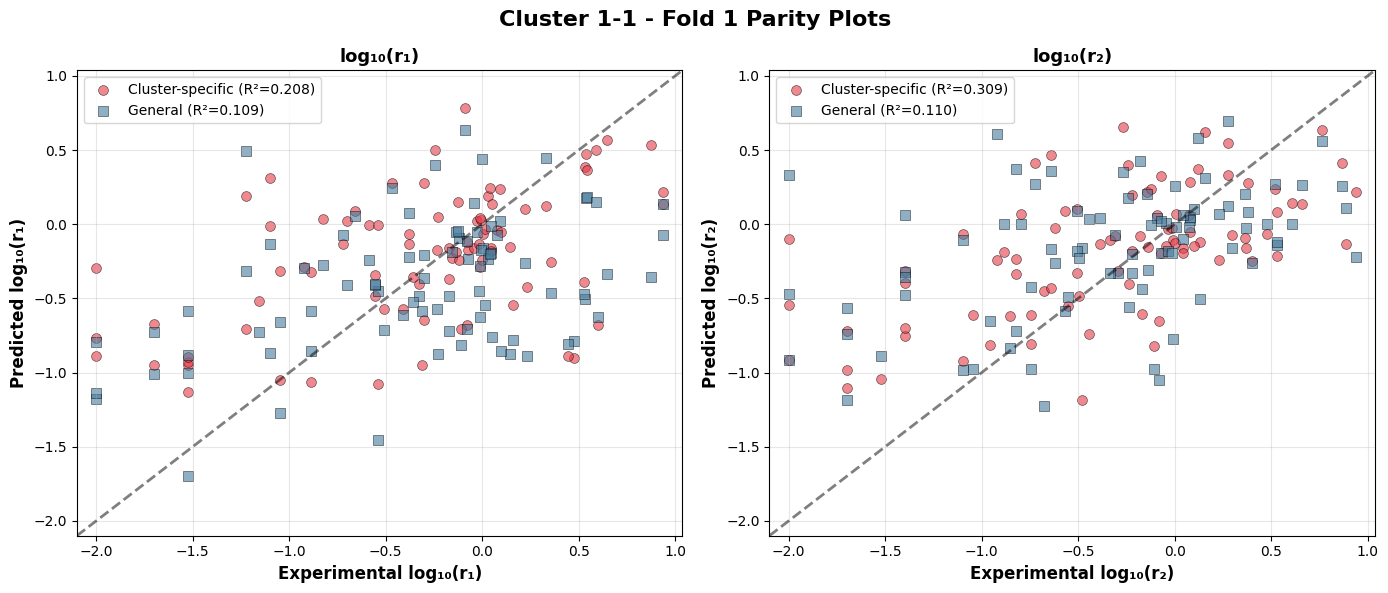

  Saved: Cluster_1_1_fold_02_parity.png


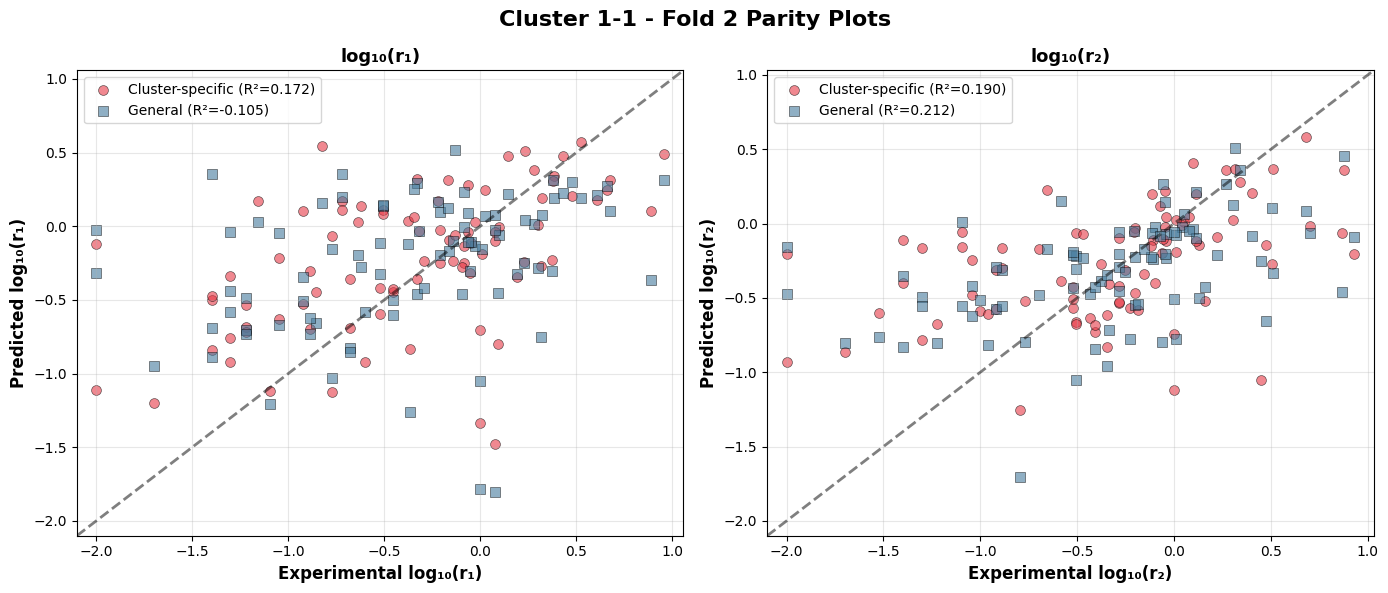

  Saved: Cluster_1_1_fold_03_parity.png


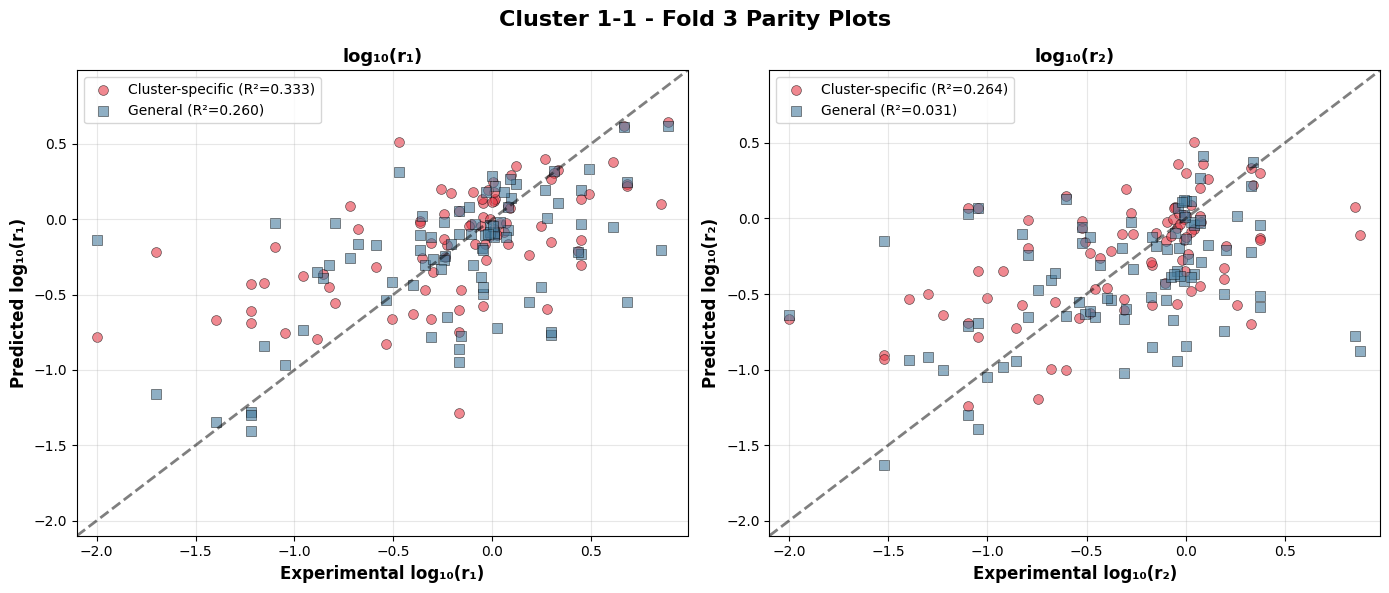

  Saved: Cluster_1_1_fold_04_parity.png


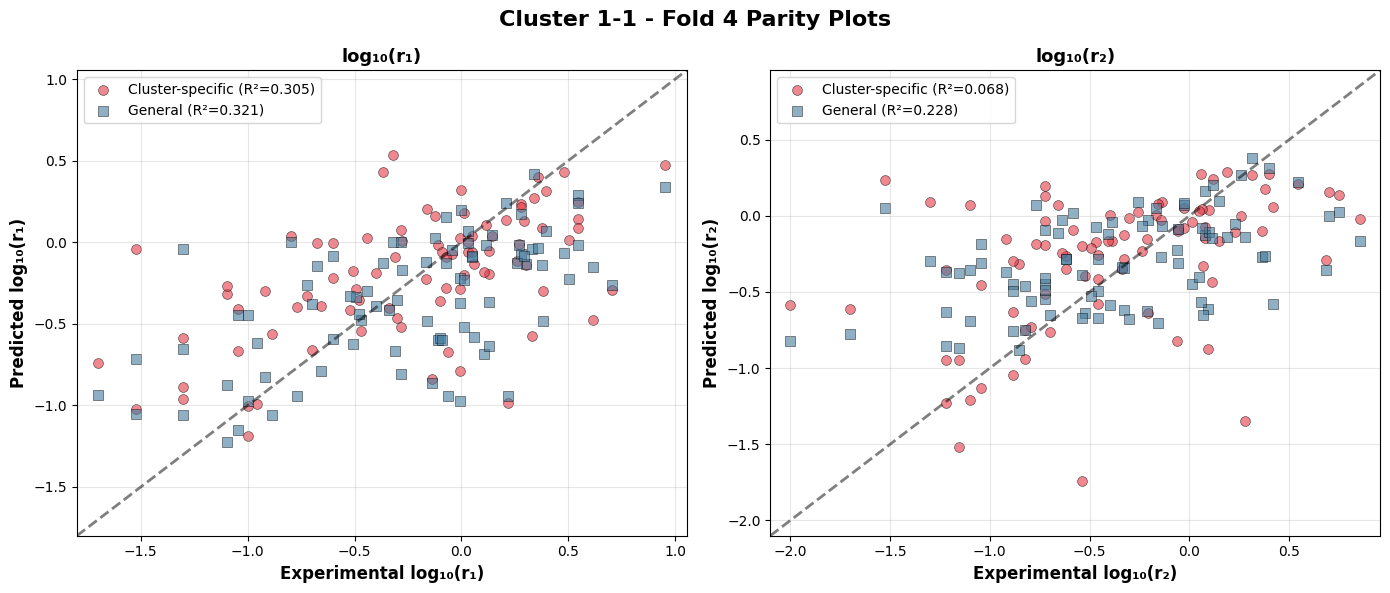

  Saved: Cluster_1_1_fold_05_parity.png


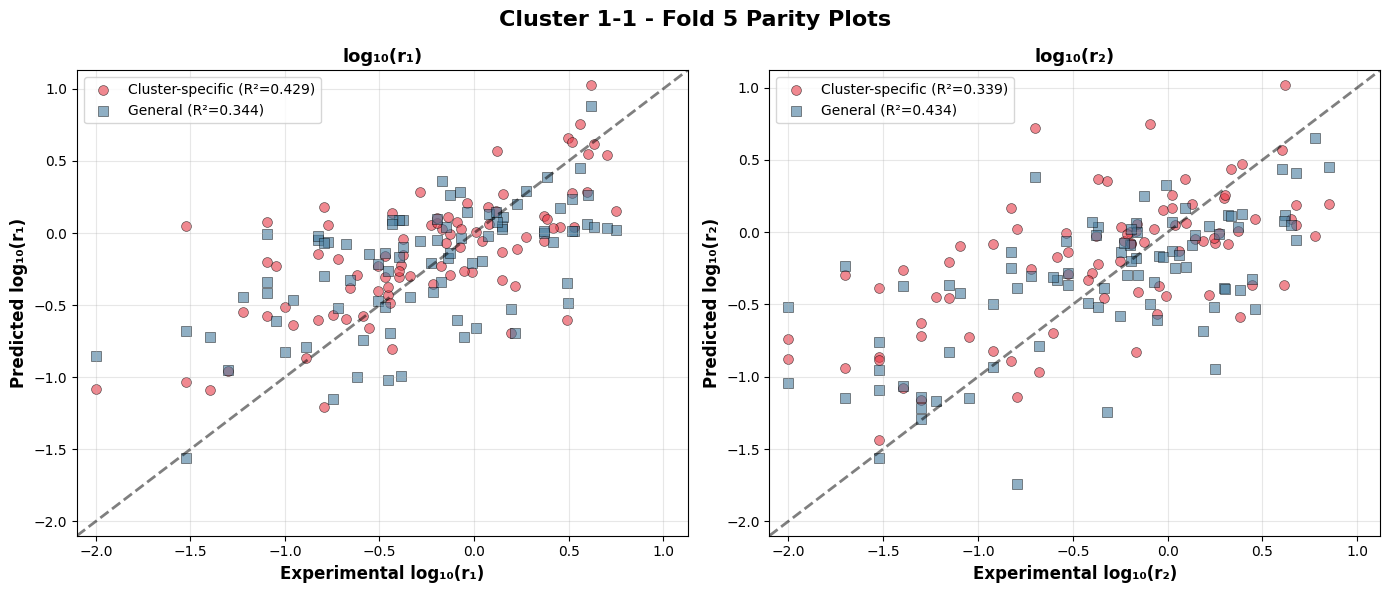

  Saved: Cluster_1_1_fold_06_parity.png


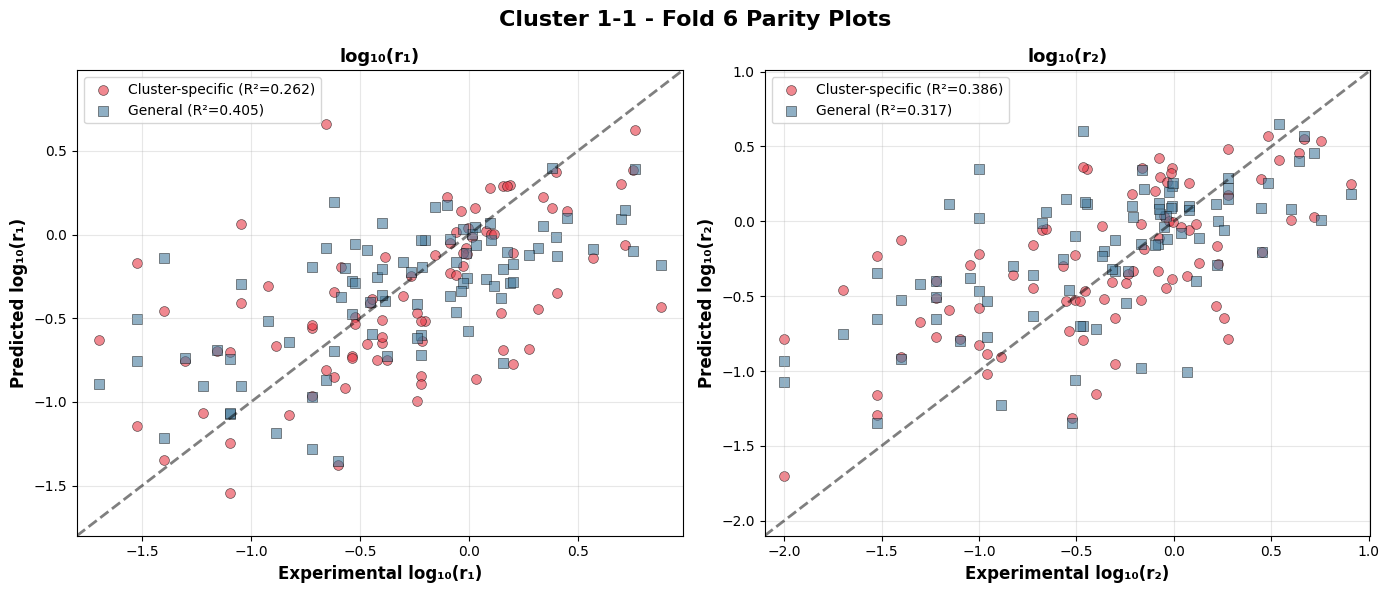

  Saved: Cluster_1_1_fold_07_parity.png


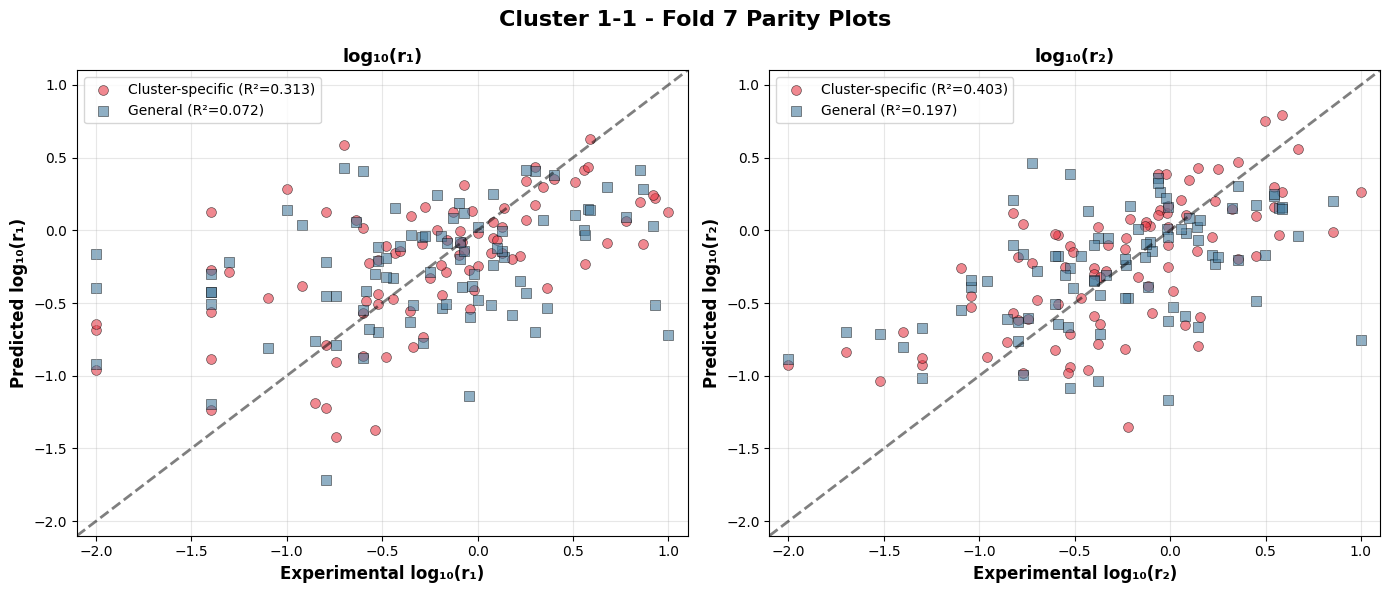

  Saved: Cluster_1_1_fold_08_parity.png


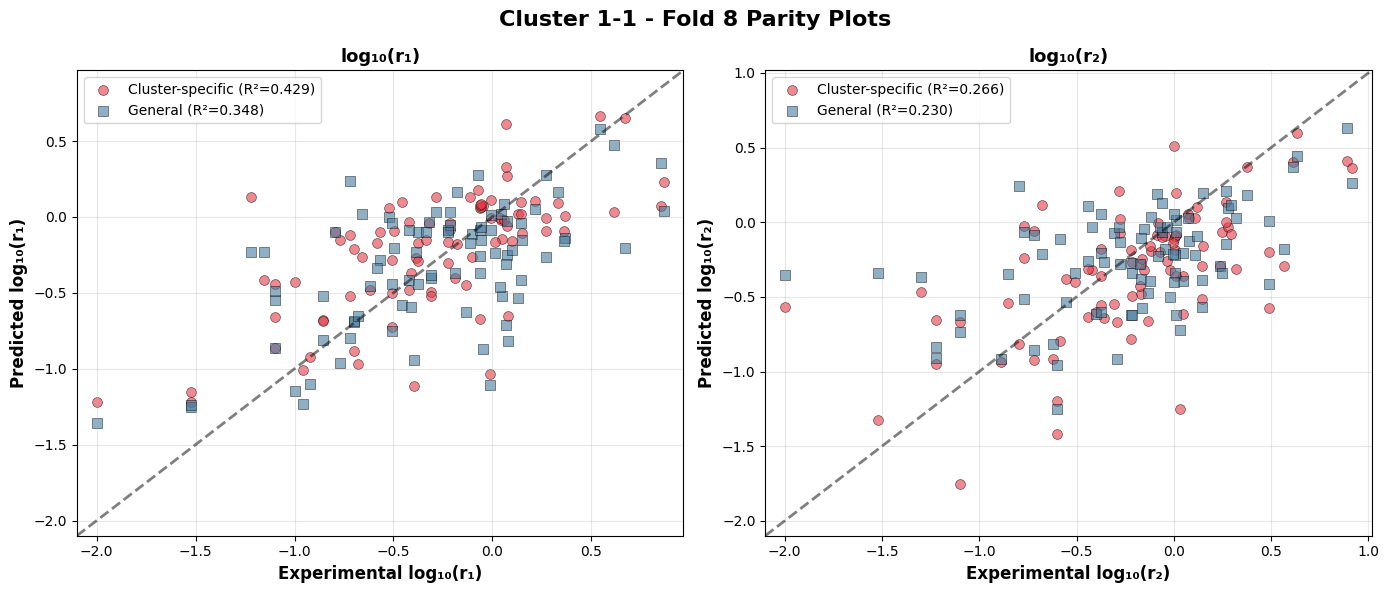

  Saved: Cluster_1_1_fold_09_parity.png


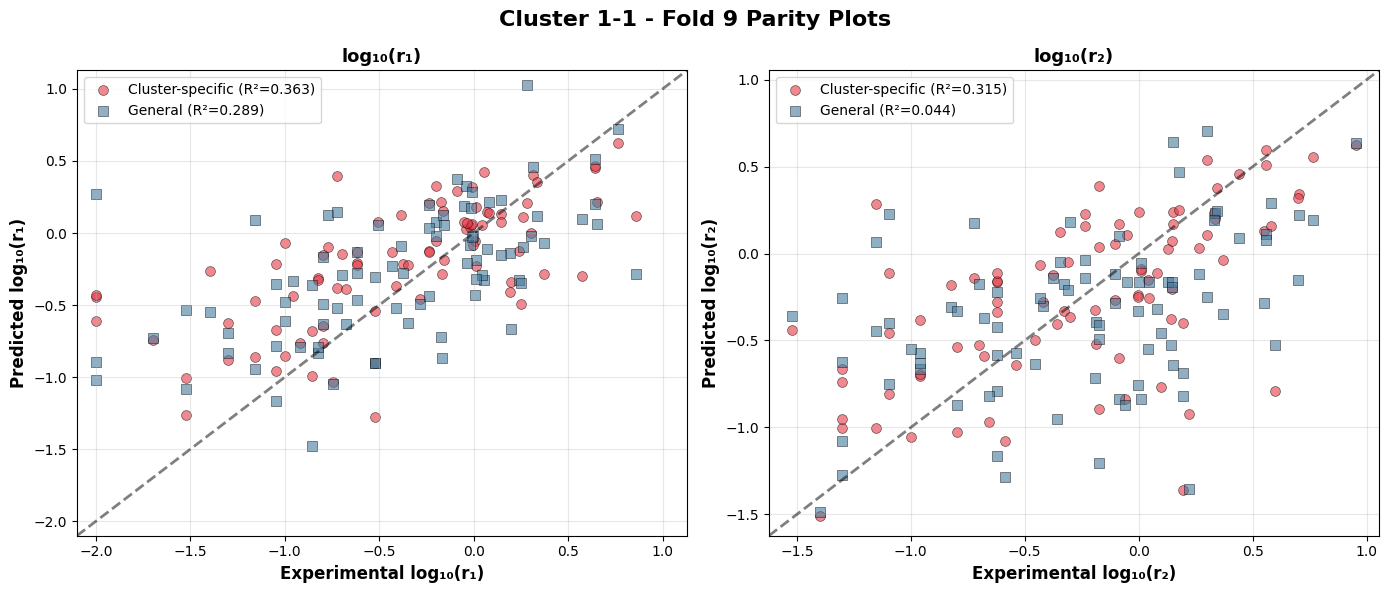

  Saved: Cluster_1_1_fold_10_parity.png


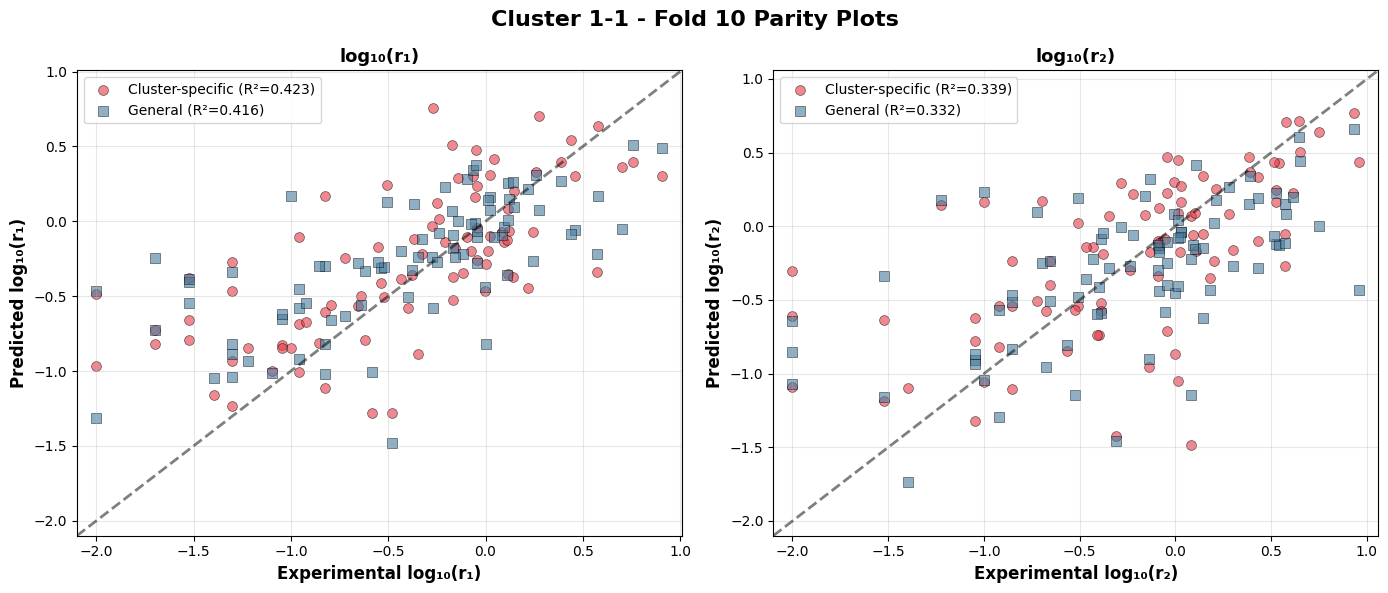


Saved R² trends: Cluster_1_1_r2_trends.png


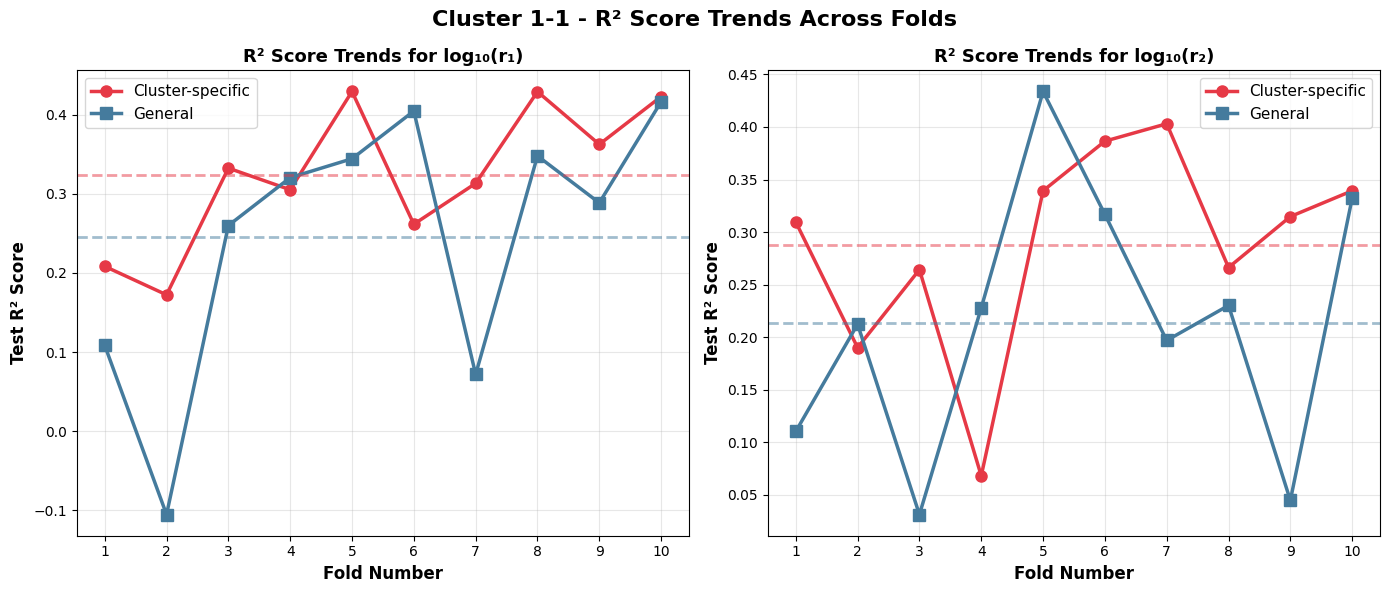

Saved MSE trends: Cluster_1_1_mse_trends.png


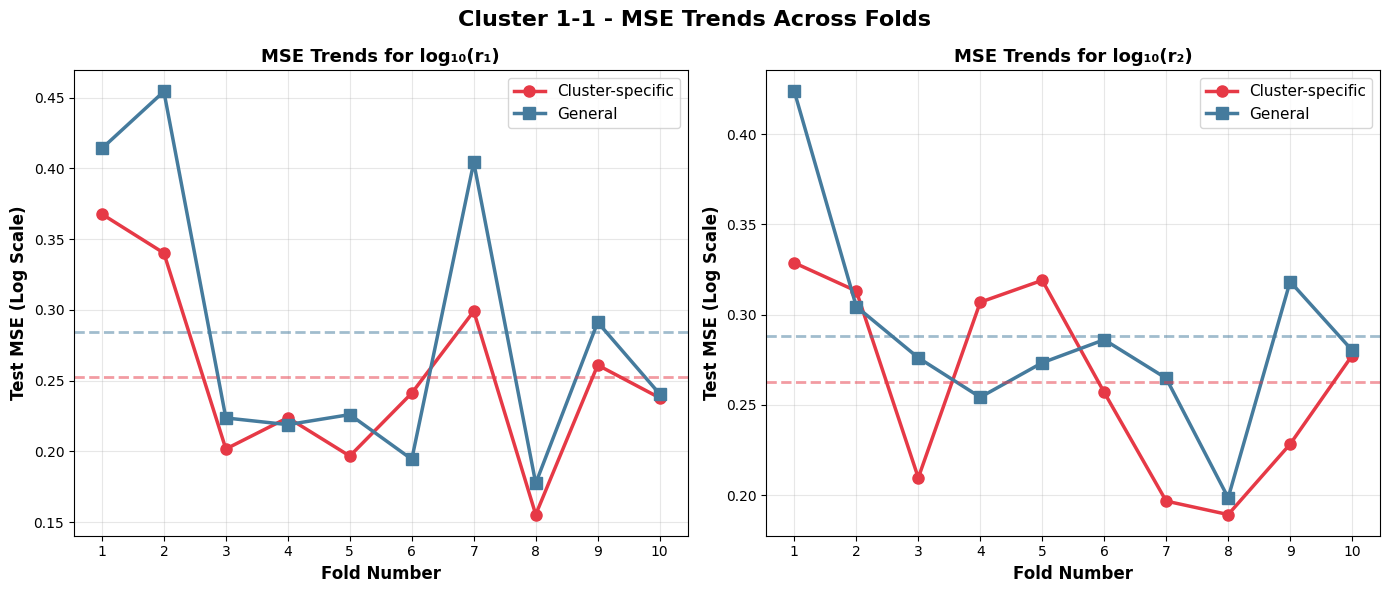


COMPREHENSIVE TRAINING STATISTICS - Cluster 1-1

────────────────────────────────────────────────────────────────────────────────
CLUSTER-SPECIFIC MODEL
────────────────────────────────────────────────────────────────────────────────

LOG SCALE RESULTS:
──────────────────────────────────────────────────
Train MSE Log R1: 0.0459 ± 0.0158
Train MSE Log R2: 0.0440 ± 0.0111
Test MSE Log R1: 0.2525 ± 0.0629
Test MSE Log R2: 0.2626 ± 0.0510

Train R² Log R1: 0.8773 ± 0.0433
Train R² Log R2: 0.8823 ± 0.0304
Test R² Log R1: 0.3238 ± 0.0862
Test R² Log R2: 0.2880 ± 0.0941

ACTUAL SCALE RESULTS:
──────────────────────────────────────────────────
Train MSE Actual R1: 0.4416 ± 0.1574
Train MSE Actual R2: 0.4224 ± 0.1660
Test MSE Actual R1: 1.7840 ± 0.7611
Test MSE Actual R2: 1.7348 ± 0.5425

Train R² Actual R1: 0.7998 ± 0.0711
Train R² Actual R2: 0.8072 ± 0.0777
Test R² Actual R1: 0.1933 ± 0.0967
Test R² Actual R2: 0.1890 ± 0.2265

─────────────────────────────────────────────────────────────────

In [6]:
"""
Enhanced Cluster-Specific Training Analysis with Separate Figure Saving
=======================================================================
Each fold parity plot and trend analysis saved as individual figures
"""

import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from rdkit import Chem
from rdkit.Chem import rdMolDescriptors
import matplotlib.pyplot as plt

# Set random seeds
np.random.seed(42)
tf.random.set_seed(42)

CONFIG = {
    'morgan_radius': 3,
    'morgan_bits': 2048,
    'neurons_l1': 80,
    'neurons_l2': 40,
    'learning_rate': 0.001,
    'batch_size': 32,
    'max_epochs': 200,
    'validation_split': 0.1,
    'patience': 30,
    'cv_folds': 10
}

def generate_morgan_fingerprint(smiles):
    """Generate Morgan fingerprint from SMILES string"""
    try:
        mol = Chem.MolFromSmiles(smiles)
        if mol is None:
            return np.zeros(CONFIG['morgan_bits'], dtype=np.float32)
        fp = rdMolDescriptors.GetMorganFingerprintAsBitVect(
            mol, CONFIG['morgan_radius'], nBits=CONFIG['morgan_bits']
        )
        return np.array(fp, dtype=np.float32)
    except:
        return np.zeros(CONFIG['morgan_bits'], dtype=np.float32)

def prepare_features_and_targets(data_subset):
    """Prepare Morgan fingerprint features and log-transformed targets"""
    fp_A = np.array([generate_morgan_fingerprint(smiles) for smiles in data_subset['SMILES_A']])
    fp_B = np.array([generate_morgan_fingerprint(smiles) for smiles in data_subset['SMILES_B']])
    X = np.concatenate([fp_A, fp_B], axis=1)
    
    y_log = np.column_stack([
        np.log10(data_subset['r1'].values),
        np.log10(data_subset['r2'].values)
    ])
    
    return X.astype(np.float32), y_log.astype(np.float32)

def create_neural_network(input_dim):
    """Create neural network architecture"""
    model = Sequential([
        Dense(CONFIG['neurons_l1'], activation='relu', input_shape=(input_dim,)),
        Dense(CONFIG['neurons_l2'], activation='relu'), 
        Dense(2, activation='linear')
    ])
    
    model.compile(
        optimizer=Adam(learning_rate=CONFIG['learning_rate']),
        loss='mse',
        metrics=['mae']
    )
    
    return model

def train_and_predict(X_train, y_train_log, X_test, y_test_log):
    """Train model and return predictions and metrics for both train and test"""
    tf.keras.backend.clear_session()
    
    model = create_neural_network(X_train.shape[1])
    
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=CONFIG['patience'],
        restore_best_weights=True,
        verbose=0
    )
    
    model.fit(
        X_train, y_train_log,
        epochs=CONFIG['max_epochs'],
        batch_size=CONFIG['batch_size'],
        validation_split=CONFIG['validation_split'],
        callbacks=[early_stopping],
        verbose=0
    )
    
    # Predictions on test set
    y_test_pred_log = model.predict(X_test, verbose=0)
    
    # Predictions on train set
    y_train_pred_log = model.predict(X_train, verbose=0)
    
    # Test metrics - LOG SCALE
    test_mse_r1_log = mean_squared_error(y_test_log[:, 0], y_test_pred_log[:, 0])
    test_mse_r2_log = mean_squared_error(y_test_log[:, 1], y_test_pred_log[:, 1])
    test_r2_r1_log = r2_score(y_test_log[:, 0], y_test_pred_log[:, 0])
    test_r2_r2_log = r2_score(y_test_log[:, 1], y_test_pred_log[:, 1])
    
    # Train metrics - LOG SCALE
    train_mse_r1_log = mean_squared_error(y_train_log[:, 0], y_train_pred_log[:, 0])
    train_mse_r2_log = mean_squared_error(y_train_log[:, 1], y_train_pred_log[:, 1])
    train_r2_r1_log = r2_score(y_train_log[:, 0], y_train_pred_log[:, 0])
    train_r2_r2_log = r2_score(y_train_log[:, 1], y_train_pred_log[:, 1])
    
    # ACTUAL SCALE - Test
    y_test_actual = 10**y_test_log
    y_test_pred_actual = 10**y_test_pred_log
    test_mse_r1_actual = mean_squared_error(y_test_actual[:, 0], y_test_pred_actual[:, 0])
    test_mse_r2_actual = mean_squared_error(y_test_actual[:, 1], y_test_pred_actual[:, 1])
    test_r2_r1_actual = r2_score(y_test_actual[:, 0], y_test_pred_actual[:, 0])
    test_r2_r2_actual = r2_score(y_test_actual[:, 1], y_test_pred_actual[:, 1])
    
    # ACTUAL SCALE - Train
    y_train_actual = 10**y_train_log
    y_train_pred_actual = 10**y_train_pred_log
    train_mse_r1_actual = mean_squared_error(y_train_actual[:, 0], y_train_pred_actual[:, 0])
    train_mse_r2_actual = mean_squared_error(y_train_actual[:, 1], y_train_pred_actual[:, 1])
    train_r2_r1_actual = r2_score(y_train_actual[:, 0], y_train_pred_actual[:, 0])
    train_r2_r2_actual = r2_score(y_train_actual[:, 1], y_train_pred_actual[:, 1])
    
    metrics = {
        # Test - Log scale
        'test_mse_r1_log': test_mse_r1_log,
        'test_mse_r2_log': test_mse_r2_log,
        'test_r2_r1_log': test_r2_r1_log,
        'test_r2_r2_log': test_r2_r2_log,
        # Train - Log scale
        'train_mse_r1_log': train_mse_r1_log,
        'train_mse_r2_log': train_mse_r2_log,
        'train_r2_r1_log': train_r2_r1_log,
        'train_r2_r2_log': train_r2_r2_log,
        # Test - Actual scale
        'test_mse_r1_actual': test_mse_r1_actual,
        'test_mse_r2_actual': test_mse_r2_actual,
        'test_r2_r1_actual': test_r2_r1_actual,
        'test_r2_r2_actual': test_r2_r2_actual,
        # Train - Actual scale
        'train_mse_r1_actual': train_mse_r1_actual,
        'train_mse_r2_actual': train_mse_r2_actual,
        'train_r2_r1_actual': train_r2_r1_actual,
        'train_r2_r2_actual': train_r2_r2_actual,
        # Legacy keys for backward compatibility (test only)
        'mse_r1': test_mse_r1_log,
        'mse_r2': test_mse_r2_log,
        'r2_r1': test_r2_r1_log,
        'r2_r2': test_r2_r2_log
    }
    
    return y_test_pred_log, metrics

def run_cluster_analysis_with_predictions(df, cluster_a, cluster_b):
    """Run analysis and store predictions for visualization"""
    cluster_name = f"Cluster {cluster_a}-{cluster_b}"
    print(f"\n{'='*80}")
    print(f"ANALYZING {cluster_name} INTERACTIONS")
    print(f"{'='*80}\n")
    
    data = df.copy()
    data = data[
        (data['r1'] > 0) & (data['r2'] > 0) &
        data['SMILES_A'].notna() & data['SMILES_B'].notna()
    ].reset_index(drop=True)
    
    # Capture bidirectional interactions
    if cluster_a == cluster_b:
        cluster_mask = (data['Cluster_A'] == cluster_a) & (data['Cluster_B'] == cluster_b)
    else:
        cluster_mask = ((data['Cluster_A'] == cluster_a) & (data['Cluster_B'] == cluster_b)) | \
                       ((data['Cluster_A'] == cluster_b) & (data['Cluster_B'] == cluster_a))
    
    cluster_indices = data.index[cluster_mask].tolist()
    
    print(f"Total samples: {len(cluster_indices)}")
    
    if len(cluster_indices) < 100:
        print(f"\nWARNING: Insufficient samples for 10-fold CV (need at least 100)")
        return None, None
    
    X_all, y_log_all = prepare_features_and_targets(data)
    
    kfold = KFold(n_splits=CONFIG['cv_folds'], shuffle=True, random_state=42)
    
    # Storage for all fold results
    fold_data = []
    
    # Cross-validation loop
    for fold, (train_idx, test_idx) in enumerate(kfold.split(cluster_indices)):
        print(f"Processing Fold {fold + 1}...")
        
        cluster_train_indices = [cluster_indices[i] for i in train_idx]
        cluster_test_indices = [cluster_indices[i] for i in test_idx]
        
        X_test = X_all[cluster_test_indices]
        y_test_log = y_log_all[cluster_test_indices]
        
        # Cluster-specific training
        X_cluster_train = X_all[cluster_train_indices]
        y_cluster_train_log = y_log_all[cluster_train_indices]
        
        y_pred_cluster, metrics_cluster = train_and_predict(
            X_cluster_train, y_cluster_train_log, X_test, y_test_log
        )
        
        # General training
        available_indices = [i for i in range(len(data)) if i not in cluster_test_indices]
        general_train_indices = np.random.choice(
            available_indices, 
            size=len(cluster_train_indices), 
            replace=False
        )
        
        X_general_train = X_all[general_train_indices]
        y_general_train_log = y_log_all[general_train_indices]
        
        y_pred_general, metrics_general = train_and_predict(
            X_general_train, y_general_train_log, X_test, y_test_log
        )
        
        # Store results
        fold_data.append({
            'fold': fold + 1,
            'y_test': y_test_log,
            'y_pred_cluster': y_pred_cluster,
            'y_pred_general': y_pred_general,
            'metrics_cluster': metrics_cluster,
            'metrics_general': metrics_general
        })
    
    return fold_data, cluster_name

def save_individual_fold_parity_plots(fold_data, cluster_name):
    """Save each fold's parity plot as a separate figure"""
    colors = {'cluster': '#E63946', 'general': '#457B9D'}
    
    cluster_filename = cluster_name.replace(" ", "_").replace("-", "_")
    
    print(f"\nSaving individual fold parity plots...")
    
    for i, fold_info in enumerate(fold_data):
        fold_num = fold_info['fold']
        y_test = fold_info['y_test']
        y_pred_cluster = fold_info['y_pred_cluster']
        y_pred_general = fold_info['y_pred_general']
        
        # Get R² scores
        r2_cluster_r1 = fold_info['metrics_cluster']['r2_r1']
        r2_cluster_r2 = fold_info['metrics_cluster']['r2_r2']
        r2_general_r1 = fold_info['metrics_general']['r2_r1']
        r2_general_r2 = fold_info['metrics_general']['r2_r2']
        
        # Find global min/max for consistent axes
        all_values_r1 = np.concatenate([y_test[:, 0], y_pred_cluster[:, 0], y_pred_general[:, 0]])
        all_values_r2 = np.concatenate([y_test[:, 1], y_pred_cluster[:, 1], y_pred_general[:, 1]])
        
        min_r1, max_r1 = all_values_r1.min() - 0.1, all_values_r1.max() + 0.1
        min_r2, max_r2 = all_values_r2.min() - 0.1, all_values_r2.max() + 0.1
        
        # Create 1x2 subplot for this fold
        fig, axes = plt.subplots(1, 2, figsize=(14, 6))
        fig.suptitle(f'{cluster_name} - Fold {fold_num} Parity Plots', 
                     fontsize=16, fontweight='bold')
        
        # Left: r1 parity plot
        ax_r1 = axes[0]
        ax_r1.scatter(y_test[:, 0], y_pred_cluster[:, 0], 
                     alpha=0.6, s=50, color=colors['cluster'], 
                     label=f'Cluster-specific (R²={r2_cluster_r1:.3f})', 
                     edgecolors='black', linewidth=0.5)
        ax_r1.scatter(y_test[:, 0], y_pred_general[:, 0], 
                     alpha=0.6, s=50, color=colors['general'], 
                     label=f'General (R²={r2_general_r1:.3f})', 
                     marker='s', edgecolors='black', linewidth=0.5)
        ax_r1.plot([min_r1, max_r1], [min_r1, max_r1], 'k--', linewidth=2, alpha=0.5)
        ax_r1.set_xlim(min_r1, max_r1)
        ax_r1.set_ylim(min_r1, max_r1)
        ax_r1.set_xlabel('Experimental log₁₀(r₁)', fontsize=12, fontweight='bold')
        ax_r1.set_ylabel('Predicted log₁₀(r₁)', fontsize=12, fontweight='bold')
        ax_r1.set_title(f'log₁₀(r₁)', fontsize=13, fontweight='bold')
        ax_r1.legend(fontsize=10, loc='upper left')
        ax_r1.grid(True, alpha=0.3)
        
        # Right: r2 parity plot
        ax_r2 = axes[1]
        ax_r2.scatter(y_test[:, 1], y_pred_cluster[:, 1], 
                     alpha=0.6, s=50, color=colors['cluster'], 
                     label=f'Cluster-specific (R²={r2_cluster_r2:.3f})', 
                     edgecolors='black', linewidth=0.5)
        ax_r2.scatter(y_test[:, 1], y_pred_general[:, 1], 
                     alpha=0.6, s=50, color=colors['general'], 
                     label=f'General (R²={r2_general_r2:.3f})', 
                     marker='s', edgecolors='black', linewidth=0.5)
        ax_r2.plot([min_r2, max_r2], [min_r2, max_r2], 'k--', linewidth=2, alpha=0.5)
        ax_r2.set_xlim(min_r2, max_r2)
        ax_r2.set_ylim(min_r2, max_r2)
        ax_r2.set_xlabel('Experimental log₁₀(r₂)', fontsize=12, fontweight='bold')
        ax_r2.set_ylabel('Predicted log₁₀(r₂)', fontsize=12, fontweight='bold')
        ax_r2.set_title(f'log₁₀(r₂)', fontsize=13, fontweight='bold')
        ax_r2.legend(fontsize=10, loc='upper left')
        ax_r2.grid(True, alpha=0.3)
        
        plt.tight_layout()
        
        filename = f'{cluster_filename}_fold_{fold_num:02d}_parity.png'
        plt.savefig(filename, dpi=300, bbox_inches='tight', facecolor='white')
        print(f"  Saved: {filename}")
        plt.show()
        plt.close()

def save_r2_trend_plot(fold_data, cluster_name):
    """Save R² trends as a separate figure"""
    colors = {'cluster': '#E63946', 'general': '#457B9D'}
    cluster_filename = cluster_name.replace(" ", "_").replace("-", "_")
    
    # Extract metrics
    folds = [f['fold'] for f in fold_data]
    r2_cluster_r1 = [f['metrics_cluster']['r2_r1'] for f in fold_data]
    r2_general_r1 = [f['metrics_general']['r2_r1'] for f in fold_data]
    r2_cluster_r2 = [f['metrics_cluster']['r2_r2'] for f in fold_data]
    r2_general_r2 = [f['metrics_general']['r2_r2'] for f in fold_data]
    
    # Create 1x2 subplot
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    fig.suptitle(f'{cluster_name} - R² Score Trends Across Folds', 
                 fontsize=16, fontweight='bold')
    
    # Left: R² for r1
    ax_r1 = axes[0]
    ax_r1.plot(folds, r2_cluster_r1, 'o-', color=colors['cluster'], 
               label='Cluster-specific', linewidth=2.5, markersize=8)
    ax_r1.plot(folds, r2_general_r1, 's-', color=colors['general'], 
               label='General', linewidth=2.5, markersize=8)
    ax_r1.axhline(y=np.mean(r2_cluster_r1), color=colors['cluster'], 
                  linestyle='--', alpha=0.5, linewidth=2)
    ax_r1.axhline(y=np.mean(r2_general_r1), color=colors['general'], 
                  linestyle='--', alpha=0.5, linewidth=2)
    ax_r1.set_xlabel('Fold Number', fontsize=12, fontweight='bold')
    ax_r1.set_ylabel('Test R² Score', fontsize=12, fontweight='bold')
    ax_r1.set_title('R² Score Trends for log₁₀(r₁)', fontsize=13, fontweight='bold')
    ax_r1.legend(fontsize=11)
    ax_r1.grid(True, alpha=0.3)
    ax_r1.set_xticks(folds)
    
    # Right: R² for r2
    ax_r2 = axes[1]
    ax_r2.plot(folds, r2_cluster_r2, 'o-', color=colors['cluster'], 
               label='Cluster-specific', linewidth=2.5, markersize=8)
    ax_r2.plot(folds, r2_general_r2, 's-', color=colors['general'], 
               label='General', linewidth=2.5, markersize=8)
    ax_r2.axhline(y=np.mean(r2_cluster_r2), color=colors['cluster'], 
                  linestyle='--', alpha=0.5, linewidth=2)
    ax_r2.axhline(y=np.mean(r2_general_r2), color=colors['general'], 
                  linestyle='--', alpha=0.5, linewidth=2)
    ax_r2.set_xlabel('Fold Number', fontsize=12, fontweight='bold')
    ax_r2.set_ylabel('Test R² Score', fontsize=12, fontweight='bold')
    ax_r2.set_title('R² Score Trends for log₁₀(r₂)', fontsize=13, fontweight='bold')
    ax_r2.legend(fontsize=11)
    ax_r2.grid(True, alpha=0.3)
    ax_r2.set_xticks(folds)
    
    plt.tight_layout()
    
    filename = f'{cluster_filename}_r2_trends.png'
    plt.savefig(filename, dpi=300, bbox_inches='tight', facecolor='white')
    print(f"\nSaved R² trends: {filename}")
    plt.show()
    plt.close()

def save_mse_trend_plot(fold_data, cluster_name):
    """Save MSE trends as a separate figure"""
    colors = {'cluster': '#E63946', 'general': '#457B9D'}
    cluster_filename = cluster_name.replace(" ", "_").replace("-", "_")
    
    # Extract metrics
    folds = [f['fold'] for f in fold_data]
    mse_cluster_r1 = [f['metrics_cluster']['mse_r1'] for f in fold_data]
    mse_general_r1 = [f['metrics_general']['mse_r1'] for f in fold_data]
    mse_cluster_r2 = [f['metrics_cluster']['mse_r2'] for f in fold_data]
    mse_general_r2 = [f['metrics_general']['mse_r2'] for f in fold_data]
    
    # Create 1x2 subplot
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    fig.suptitle(f'{cluster_name} - MSE Trends Across Folds', 
                 fontsize=16, fontweight='bold')
    
    # Left: MSE for r1
    ax_r1 = axes[0]
    ax_r1.plot(folds, mse_cluster_r1, 'o-', color=colors['cluster'], 
               label='Cluster-specific', linewidth=2.5, markersize=8)
    ax_r1.plot(folds, mse_general_r1, 's-', color=colors['general'], 
               label='General', linewidth=2.5, markersize=8)
    ax_r1.axhline(y=np.mean(mse_cluster_r1), color=colors['cluster'], 
                  linestyle='--', alpha=0.5, linewidth=2)
    ax_r1.axhline(y=np.mean(mse_general_r1), color=colors['general'], 
                  linestyle='--', alpha=0.5, linewidth=2)
    ax_r1.set_xlabel('Fold Number', fontsize=12, fontweight='bold')
    ax_r1.set_ylabel('Test MSE (Log Scale)', fontsize=12, fontweight='bold')
    ax_r1.set_title('MSE Trends for log₁₀(r₁)', fontsize=13, fontweight='bold')
    ax_r1.legend(fontsize=11)
    ax_r1.grid(True, alpha=0.3)
    ax_r1.set_xticks(folds)
    
    # Right: MSE for r2
    ax_r2 = axes[1]
    ax_r2.plot(folds, mse_cluster_r2, 'o-', color=colors['cluster'], 
               label='Cluster-specific', linewidth=2.5, markersize=8)
    ax_r2.plot(folds, mse_general_r2, 's-', color=colors['general'], 
               label='General', linewidth=2.5, markersize=8)
    ax_r2.axhline(y=np.mean(mse_cluster_r2), color=colors['cluster'], 
                  linestyle='--', alpha=0.5, linewidth=2)
    ax_r2.axhline(y=np.mean(mse_general_r2), color=colors['general'], 
                  linestyle='--', alpha=0.5, linewidth=2)
    ax_r2.set_xlabel('Fold Number', fontsize=12, fontweight='bold')
    ax_r2.set_ylabel('Test MSE (Log Scale)', fontsize=12, fontweight='bold')
    ax_r2.set_title('MSE Trends for log₁₀(r₂)', fontsize=13, fontweight='bold')
    ax_r2.legend(fontsize=11)
    ax_r2.grid(True, alpha=0.3)
    ax_r2.set_xticks(folds)
    
    plt.tight_layout()
    
    filename = f'{cluster_filename}_mse_trends.png'
    plt.savefig(filename, dpi=300, bbox_inches='tight', facecolor='white')
    print(f"Saved MSE trends: {filename}")
    plt.show()
    plt.close()

def main_analysis(df, cluster_a, cluster_b):
    """Main function to run analysis and create separate visualizations"""
    fold_data, cluster_name = run_cluster_analysis_with_predictions(df, cluster_a, cluster_b)
    
    if fold_data is None:
        print(f"\nSkipping {cluster_name} - insufficient data")
        return
    
    # Save each fold's parity plot separately
    save_individual_fold_parity_plots(fold_data, cluster_name)
    
    # Save R² trends
    save_r2_trend_plot(fold_data, cluster_name)
    
    # Save MSE trends
    save_mse_trend_plot(fold_data, cluster_name)
    
    # Print comprehensive statistics
    print(f"\n{'='*80}")
    print(f"COMPREHENSIVE TRAINING STATISTICS - {cluster_name}")
    print(f"{'='*80}")
    
    # Extract all metrics from fold_data
    cluster_metrics = {
        'train_mse_r1_log': [f['metrics_cluster']['train_mse_r1_log'] for f in fold_data],
        'train_mse_r2_log': [f['metrics_cluster']['train_mse_r2_log'] for f in fold_data],
        'test_mse_r1_log': [f['metrics_cluster']['test_mse_r1_log'] for f in fold_data],
        'test_mse_r2_log': [f['metrics_cluster']['test_mse_r2_log'] for f in fold_data],
        'train_r2_r1_log': [f['metrics_cluster']['train_r2_r1_log'] for f in fold_data],
        'train_r2_r2_log': [f['metrics_cluster']['train_r2_r2_log'] for f in fold_data],
        'test_r2_r1_log': [f['metrics_cluster']['test_r2_r1_log'] for f in fold_data],
        'test_r2_r2_log': [f['metrics_cluster']['test_r2_r2_log'] for f in fold_data],
        'train_mse_r1_actual': [f['metrics_cluster']['train_mse_r1_actual'] for f in fold_data],
        'train_mse_r2_actual': [f['metrics_cluster']['train_mse_r2_actual'] for f in fold_data],
        'test_mse_r1_actual': [f['metrics_cluster']['test_mse_r1_actual'] for f in fold_data],
        'test_mse_r2_actual': [f['metrics_cluster']['test_mse_r2_actual'] for f in fold_data],
        'train_r2_r1_actual': [f['metrics_cluster']['train_r2_r1_actual'] for f in fold_data],
        'train_r2_r2_actual': [f['metrics_cluster']['train_r2_r2_actual'] for f in fold_data],
        'test_r2_r1_actual': [f['metrics_cluster']['test_r2_r1_actual'] for f in fold_data],
        'test_r2_r2_actual': [f['metrics_cluster']['test_r2_r2_actual'] for f in fold_data],
    }
    
    general_metrics = {
        'train_mse_r1_log': [f['metrics_general']['train_mse_r1_log'] for f in fold_data],
        'train_mse_r2_log': [f['metrics_general']['train_mse_r2_log'] for f in fold_data],
        'test_mse_r1_log': [f['metrics_general']['test_mse_r1_log'] for f in fold_data],
        'test_mse_r2_log': [f['metrics_general']['test_mse_r2_log'] for f in fold_data],
        'train_r2_r1_log': [f['metrics_general']['train_r2_r1_log'] for f in fold_data],
        'train_r2_r2_log': [f['metrics_general']['train_r2_r2_log'] for f in fold_data],
        'test_r2_r1_log': [f['metrics_general']['test_r2_r1_log'] for f in fold_data],
        'test_r2_r2_log': [f['metrics_general']['test_r2_r2_log'] for f in fold_data],
        'train_mse_r1_actual': [f['metrics_general']['train_mse_r1_actual'] for f in fold_data],
        'train_mse_r2_actual': [f['metrics_general']['train_mse_r2_actual'] for f in fold_data],
        'test_mse_r1_actual': [f['metrics_general']['test_mse_r1_actual'] for f in fold_data],
        'test_mse_r2_actual': [f['metrics_general']['test_mse_r2_actual'] for f in fold_data],
        'train_r2_r1_actual': [f['metrics_general']['train_r2_r1_actual'] for f in fold_data],
        'train_r2_r2_actual': [f['metrics_general']['train_r2_r2_actual'] for f in fold_data],
        'test_r2_r1_actual': [f['metrics_general']['test_r2_r1_actual'] for f in fold_data],
        'test_r2_r2_actual': [f['metrics_general']['test_r2_r2_actual'] for f in fold_data],
    }
    
    # CLUSTER-SPECIFIC MODEL RESULTS
    print(f"\n{'─'*80}")
    print("CLUSTER-SPECIFIC MODEL")
    print(f"{'─'*80}")
    
    print(f"\nLOG SCALE RESULTS:")
    print(f"{'─'*50}")
    print(f"Train MSE Log R1: {np.mean(cluster_metrics['train_mse_r1_log']):.4f} ± {np.std(cluster_metrics['train_mse_r1_log']):.4f}")
    print(f"Train MSE Log R2: {np.mean(cluster_metrics['train_mse_r2_log']):.4f} ± {np.std(cluster_metrics['train_mse_r2_log']):.4f}")
    print(f"Test MSE Log R1: {np.mean(cluster_metrics['test_mse_r1_log']):.4f} ± {np.std(cluster_metrics['test_mse_r1_log']):.4f}")
    print(f"Test MSE Log R2: {np.mean(cluster_metrics['test_mse_r2_log']):.4f} ± {np.std(cluster_metrics['test_mse_r2_log']):.4f}")
    print()
    print(f"Train R² Log R1: {np.mean(cluster_metrics['train_r2_r1_log']):.4f} ± {np.std(cluster_metrics['train_r2_r1_log']):.4f}")
    print(f"Train R² Log R2: {np.mean(cluster_metrics['train_r2_r2_log']):.4f} ± {np.std(cluster_metrics['train_r2_r2_log']):.4f}")
    print(f"Test R² Log R1: {np.mean(cluster_metrics['test_r2_r1_log']):.4f} ± {np.std(cluster_metrics['test_r2_r1_log']):.4f}")
    print(f"Test R² Log R2: {np.mean(cluster_metrics['test_r2_r2_log']):.4f} ± {np.std(cluster_metrics['test_r2_r2_log']):.4f}")
    
    print(f"\nACTUAL SCALE RESULTS:")
    print(f"{'─'*50}")
    print(f"Train MSE Actual R1: {np.mean(cluster_metrics['train_mse_r1_actual']):.4f} ± {np.std(cluster_metrics['train_mse_r1_actual']):.4f}")
    print(f"Train MSE Actual R2: {np.mean(cluster_metrics['train_mse_r2_actual']):.4f} ± {np.std(cluster_metrics['train_mse_r2_actual']):.4f}")
    print(f"Test MSE Actual R1: {np.mean(cluster_metrics['test_mse_r1_actual']):.4f} ± {np.std(cluster_metrics['test_mse_r1_actual']):.4f}")
    print(f"Test MSE Actual R2: {np.mean(cluster_metrics['test_mse_r2_actual']):.4f} ± {np.std(cluster_metrics['test_mse_r2_actual']):.4f}")
    print()
    print(f"Train R² Actual R1: {np.mean(cluster_metrics['train_r2_r1_actual']):.4f} ± {np.std(cluster_metrics['train_r2_r1_actual']):.4f}")
    print(f"Train R² Actual R2: {np.mean(cluster_metrics['train_r2_r2_actual']):.4f} ± {np.std(cluster_metrics['train_r2_r2_actual']):.4f}")
    print(f"Test R² Actual R1: {np.mean(cluster_metrics['test_r2_r1_actual']):.4f} ± {np.std(cluster_metrics['test_r2_r1_actual']):.4f}")
    print(f"Test R² Actual R2: {np.mean(cluster_metrics['test_r2_r2_actual']):.4f} ± {np.std(cluster_metrics['test_r2_r2_actual']):.4f}")
    
    # GENERAL MODEL RESULTS
    print(f"\n{'─'*80}")
    print("GENERAL MODEL")
    print(f"{'─'*80}")
    
    print(f"\nLOG SCALE RESULTS:")
    print(f"{'─'*50}")
    print(f"Train MSE Log R1: {np.mean(general_metrics['train_mse_r1_log']):.4f} ± {np.std(general_metrics['train_mse_r1_log']):.4f}")
    print(f"Train MSE Log R2: {np.mean(general_metrics['train_mse_r2_log']):.4f} ± {np.std(general_metrics['train_mse_r2_log']):.4f}")
    print(f"Test MSE Log R1: {np.mean(general_metrics['test_mse_r1_log']):.4f} ± {np.std(general_metrics['test_mse_r1_log']):.4f}")
    print(f"Test MSE Log R2: {np.mean(general_metrics['test_mse_r2_log']):.4f} ± {np.std(general_metrics['test_mse_r2_log']):.4f}")
    print()
    print(f"Train R² Log R1: {np.mean(general_metrics['train_r2_r1_log']):.4f} ± {np.std(general_metrics['train_r2_r1_log']):.4f}")
    print(f"Train R² Log R2: {np.mean(general_metrics['train_r2_r2_log']):.4f} ± {np.std(general_metrics['train_r2_r2_log']):.4f}")
    print(f"Test R² Log R1: {np.mean(general_metrics['test_r2_r1_log']):.4f} ± {np.std(general_metrics['test_r2_r1_log']):.4f}")
    print(f"Test R² Log R2: {np.mean(general_metrics['test_r2_r2_log']):.4f} ± {np.std(general_metrics['test_r2_r2_log']):.4f}")
    
    print(f"\nACTUAL SCALE RESULTS:")
    print(f"{'─'*50}")
    print(f"Train MSE Actual R1: {np.mean(general_metrics['train_mse_r1_actual']):.4f} ± {np.std(general_metrics['train_mse_r1_actual']):.4f}")
    print(f"Train MSE Actual R2: {np.mean(general_metrics['train_mse_r2_actual']):.4f} ± {np.std(general_metrics['train_mse_r2_actual']):.4f}")
    print(f"Test MSE Actual R1: {np.mean(general_metrics['test_mse_r1_actual']):.4f} ± {np.std(general_metrics['test_mse_r1_actual']):.4f}")
    print(f"Test MSE Actual R2: {np.mean(general_metrics['test_mse_r2_actual']):.4f} ± {np.std(general_metrics['test_mse_r2_actual']):.4f}")
    print()
    print(f"Train R² Actual R1: {np.mean(general_metrics['train_r2_r1_actual']):.4f} ± {np.std(general_metrics['train_r2_r1_actual']):.4f}")
    print(f"Train R² Actual R2: {np.mean(general_metrics['train_r2_r2_actual']):.4f} ± {np.std(general_metrics['train_r2_r2_actual']):.4f}")
    print(f"Test R² Actual R1: {np.mean(general_metrics['test_r2_r1_actual']):.4f} ± {np.std(general_metrics['test_r2_r1_actual']):.4f}")
    print(f"Test R² Actual R2: {np.mean(general_metrics['test_r2_r2_actual']):.4f} ± {np.std(general_metrics['test_r2_r2_actual']):.4f}")
    
    print(f"\n{'='*80}")
    print(f"ANALYSIS COMPLETE!")
    print(f"{'='*80}")

# Usage
if __name__ == "__main__":
    # Check data distribution before running
    print("="*80)
    print("DATA DISTRIBUTION CHECK")
    print("="*80)
    
    data_check = df.copy()
    data_check = data_check[
        (data_check['r1'] > 0) & (data_check['r2'] > 0) &
        data_check['SMILES_A'].notna() & data_check['SMILES_B'].notna()
    ]
    
    print(f"\nTotal valid samples: {len(data_check)}")
    print("\nCluster Interaction Counts:")
    
    for i in [1, 2, 3]:
        for j in [1, 2, 3]:
            if j >= i:
                if i == j:
                    mask = (data_check['Cluster_A'] == i) & (data_check['Cluster_B'] == j)
                else:
                    mask = ((data_check['Cluster_A'] == i) & (data_check['Cluster_B'] == j)) | \
                           ((data_check['Cluster_A'] == j) & (data_check['Cluster_B'] == i))
                count = mask.sum()
                print(f"  Cluster {i}-{j}: {count} samples")
    
    print("\n" + "="*80)
    print("STARTING ANALYSIS")
    print("="*80)
    
    # Run analyses
    main_analysis(df, cluster_a=1, cluster_b=1)
    #main_analysis(df, cluster_a=1, cluster_b=2)
    #main_analysis(df, cluster_a=1, cluster_b=3)
    #main_analysis(df, cluster_a=2, cluster_b=2)
    #main_analysis(df, cluster_a=2, cluster_b=3)
    #main_analysis(df, cluster_a=3, cluster_b=3)

DATA DISTRIBUTION CHECK

Total valid samples: 2304

Cluster Interaction Counts:
  Cluster 1-1: 870 samples
  Cluster 1-2: 858 samples
  Cluster 1-3: 154 samples
  Cluster 2-2: 360 samples
  Cluster 2-3: 52 samples
  Cluster 3-3: 10 samples

STARTING ANALYSIS

ANALYZING Cluster 1-2 INTERACTIONS

Total samples: 858
Processing Fold 1...


/home/bavarian/hsafari2/.conda/envs/myVEnv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/bavarian/hsafari2/.conda/envs/myVEnv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Processing Fold 2...


/home/bavarian/hsafari2/.conda/envs/myVEnv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/bavarian/hsafari2/.conda/envs/myVEnv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Processing Fold 3...


/home/bavarian/hsafari2/.conda/envs/myVEnv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/bavarian/hsafari2/.conda/envs/myVEnv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Processing Fold 4...


/home/bavarian/hsafari2/.conda/envs/myVEnv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/bavarian/hsafari2/.conda/envs/myVEnv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Processing Fold 5...


/home/bavarian/hsafari2/.conda/envs/myVEnv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/bavarian/hsafari2/.conda/envs/myVEnv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Processing Fold 6...


/home/bavarian/hsafari2/.conda/envs/myVEnv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/bavarian/hsafari2/.conda/envs/myVEnv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Processing Fold 7...


/home/bavarian/hsafari2/.conda/envs/myVEnv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/bavarian/hsafari2/.conda/envs/myVEnv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Processing Fold 8...


/home/bavarian/hsafari2/.conda/envs/myVEnv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/bavarian/hsafari2/.conda/envs/myVEnv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Processing Fold 9...


/home/bavarian/hsafari2/.conda/envs/myVEnv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/bavarian/hsafari2/.conda/envs/myVEnv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Processing Fold 10...


/home/bavarian/hsafari2/.conda/envs/myVEnv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/bavarian/hsafari2/.conda/envs/myVEnv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Saving individual fold parity plots...
  Saved: Cluster_1_2_fold_01_parity.png


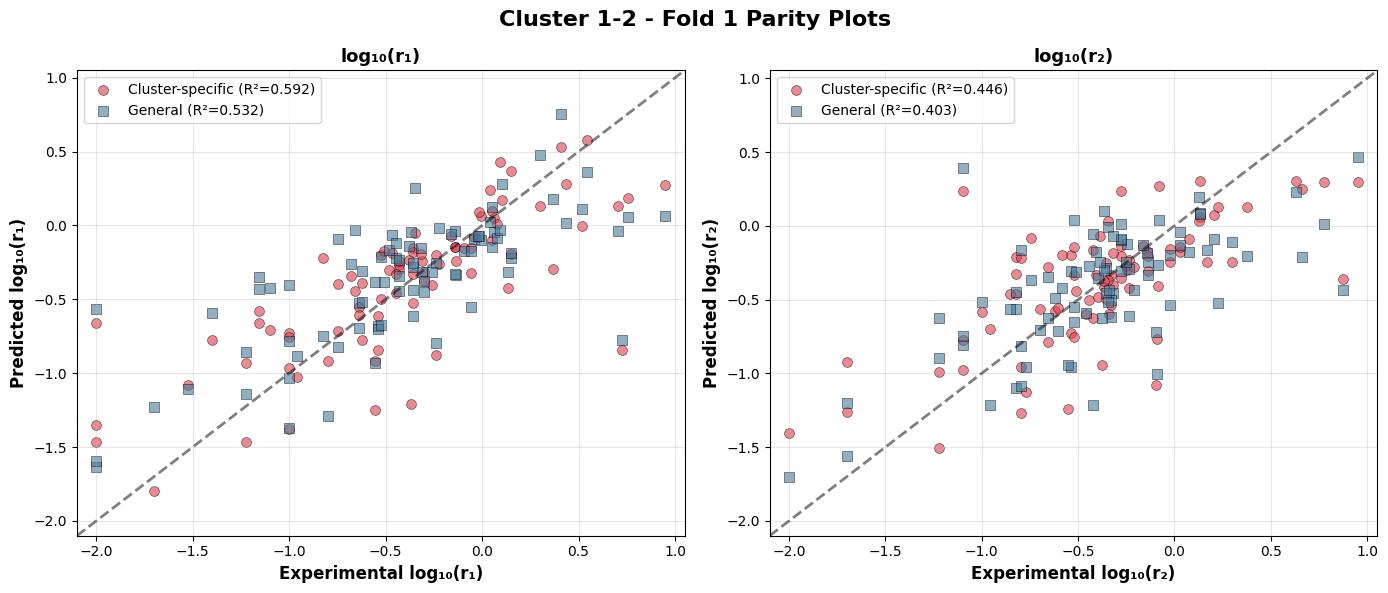

  Saved: Cluster_1_2_fold_02_parity.png


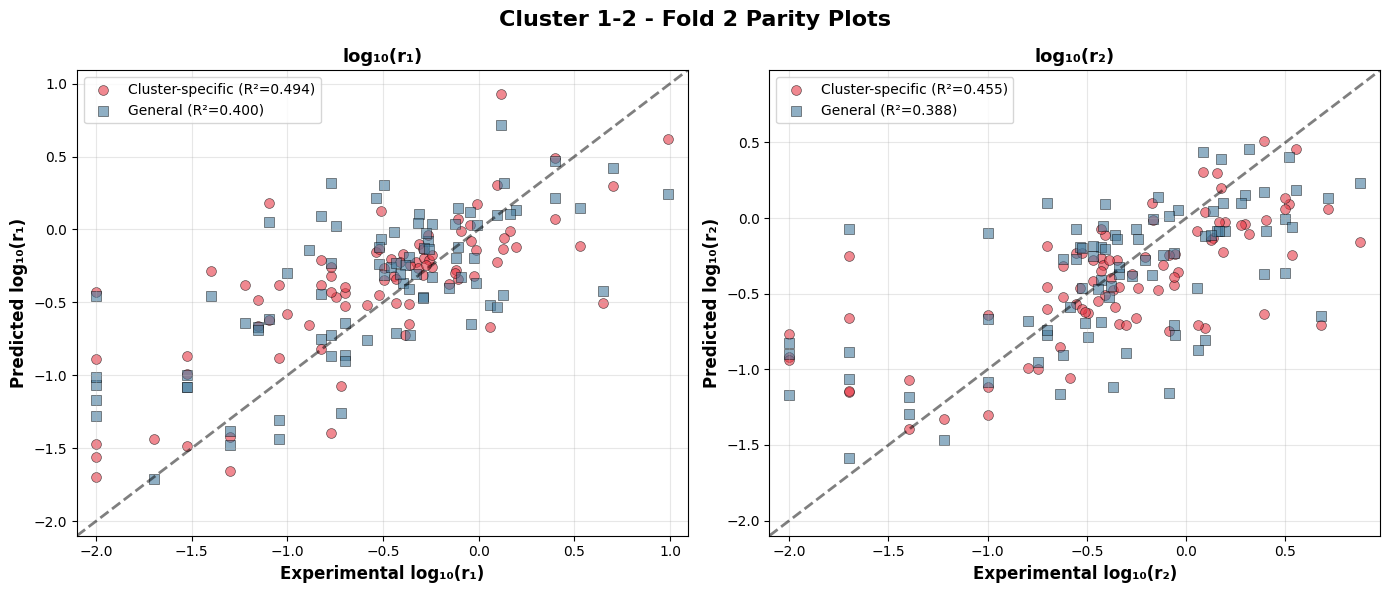

  Saved: Cluster_1_2_fold_03_parity.png


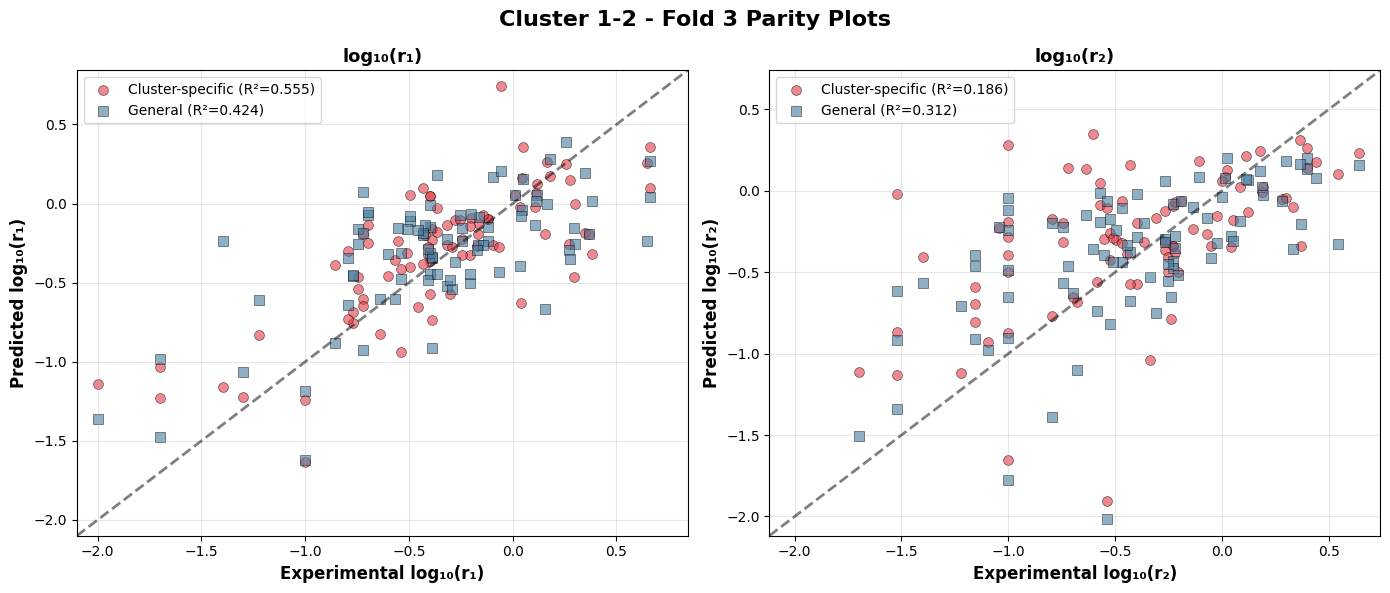

  Saved: Cluster_1_2_fold_04_parity.png


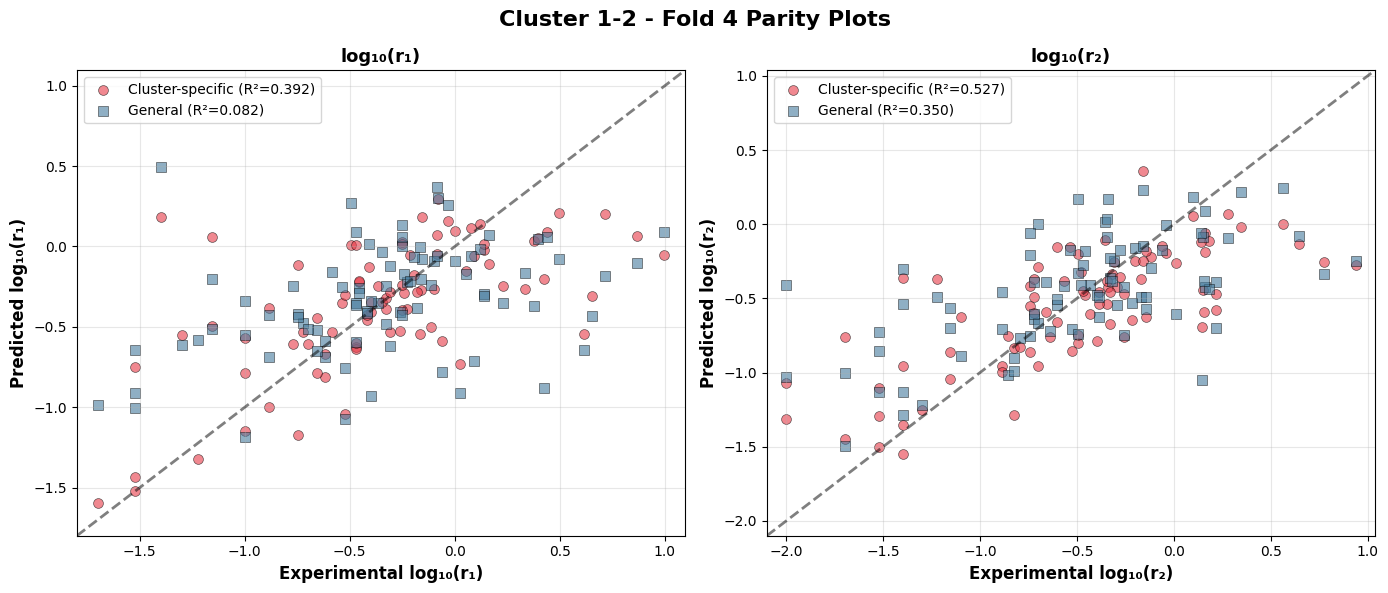

  Saved: Cluster_1_2_fold_05_parity.png


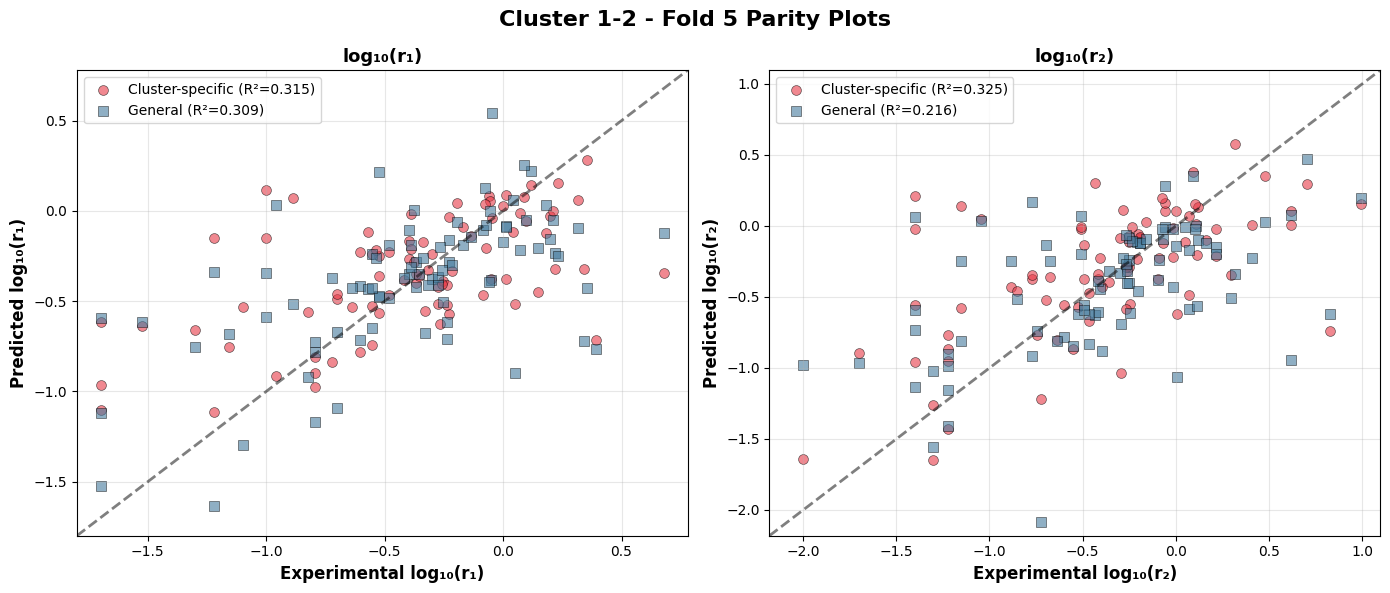

  Saved: Cluster_1_2_fold_06_parity.png


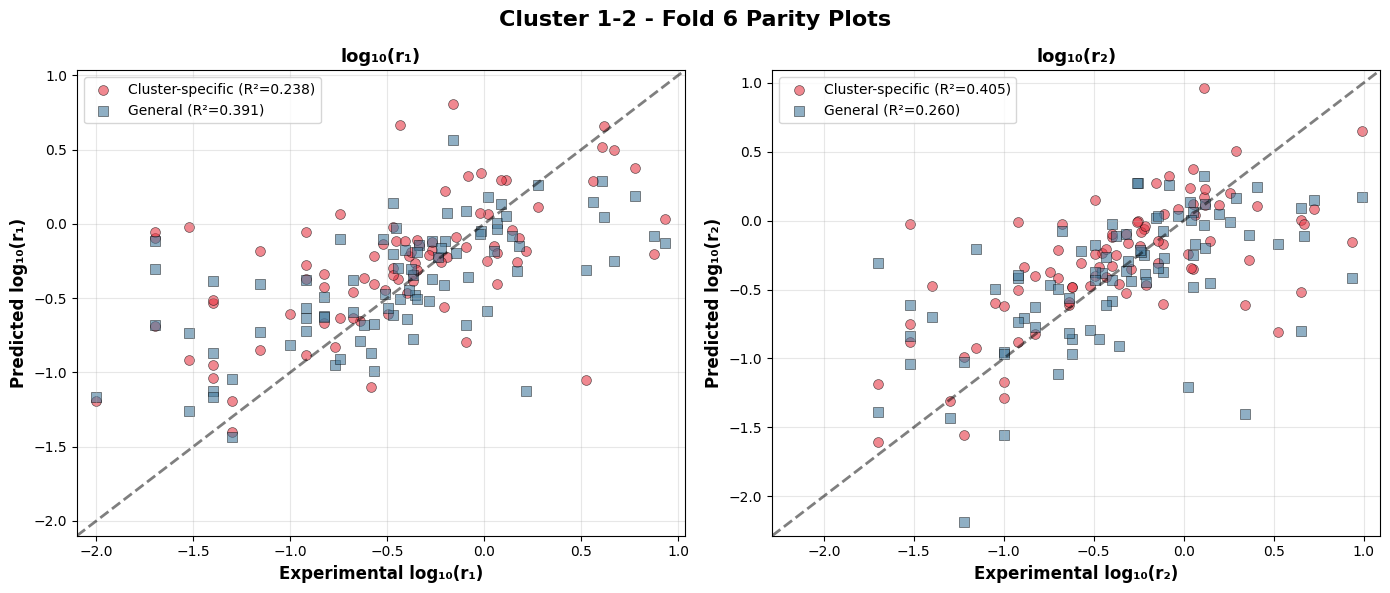

  Saved: Cluster_1_2_fold_07_parity.png


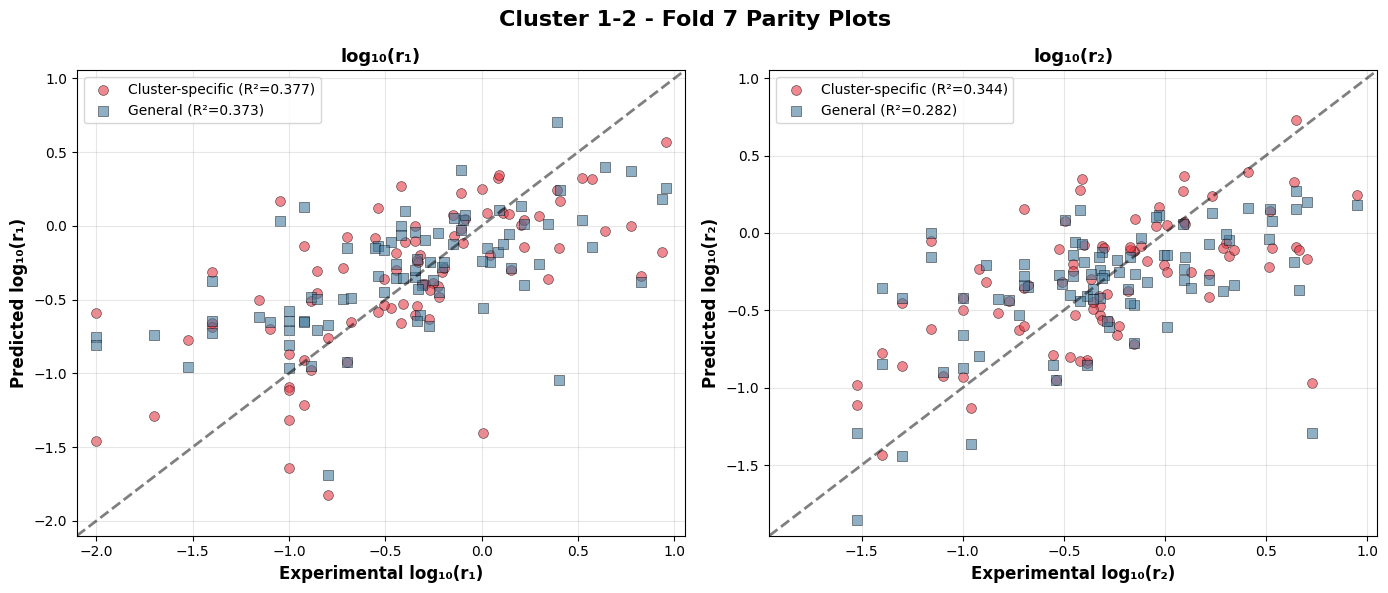

  Saved: Cluster_1_2_fold_08_parity.png


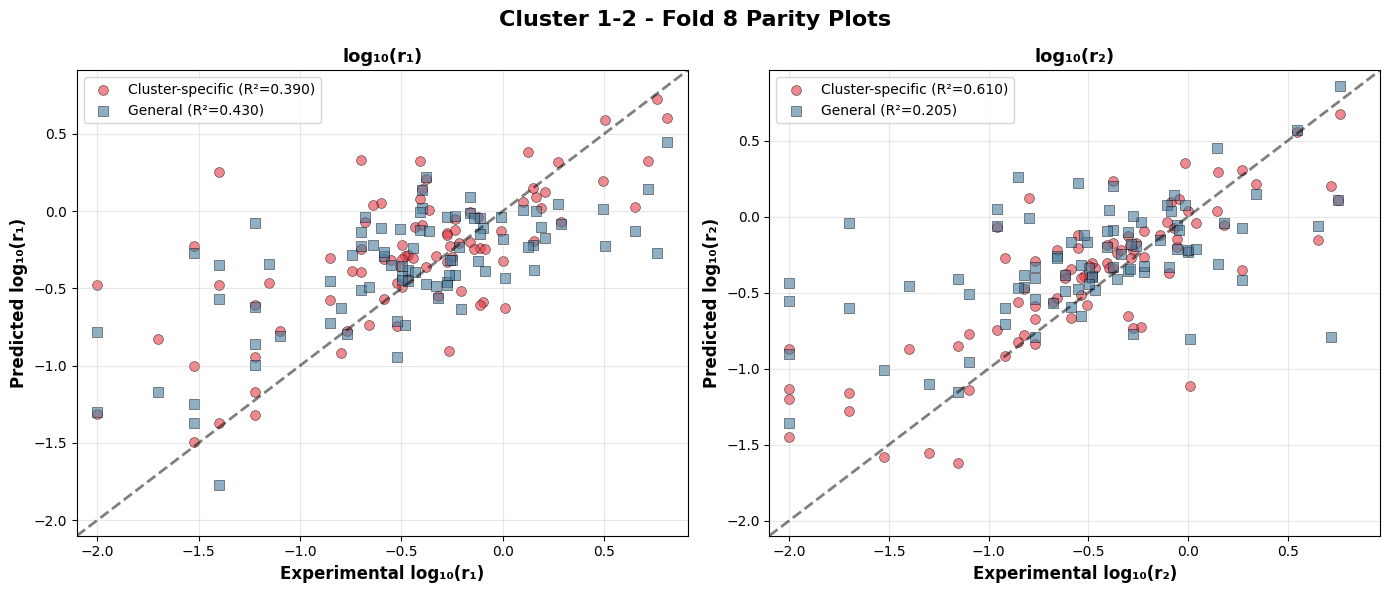

  Saved: Cluster_1_2_fold_09_parity.png


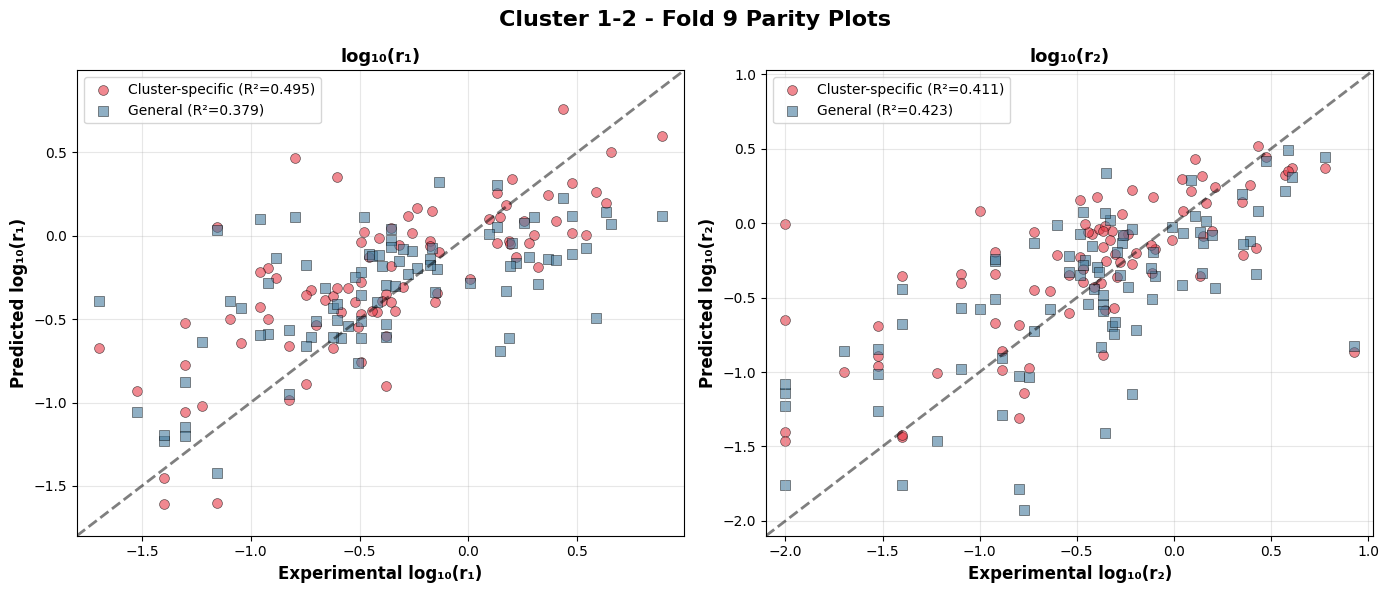

  Saved: Cluster_1_2_fold_10_parity.png


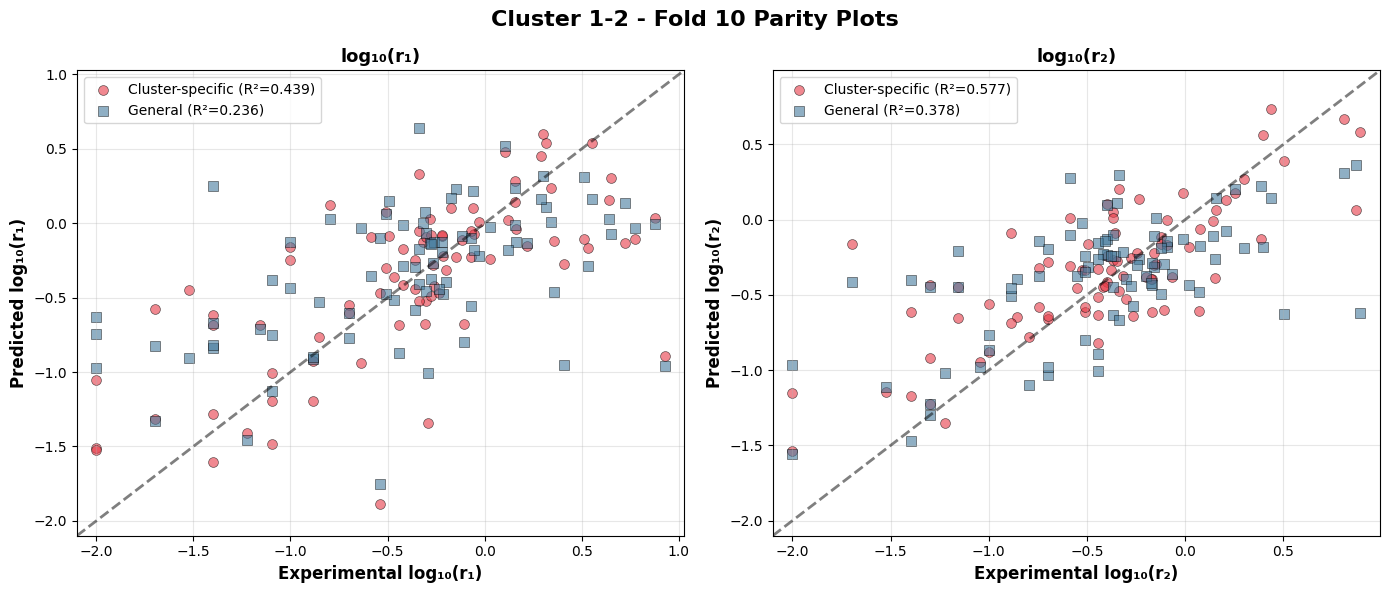


Saved R² trends: Cluster_1_2_r2_trends.png


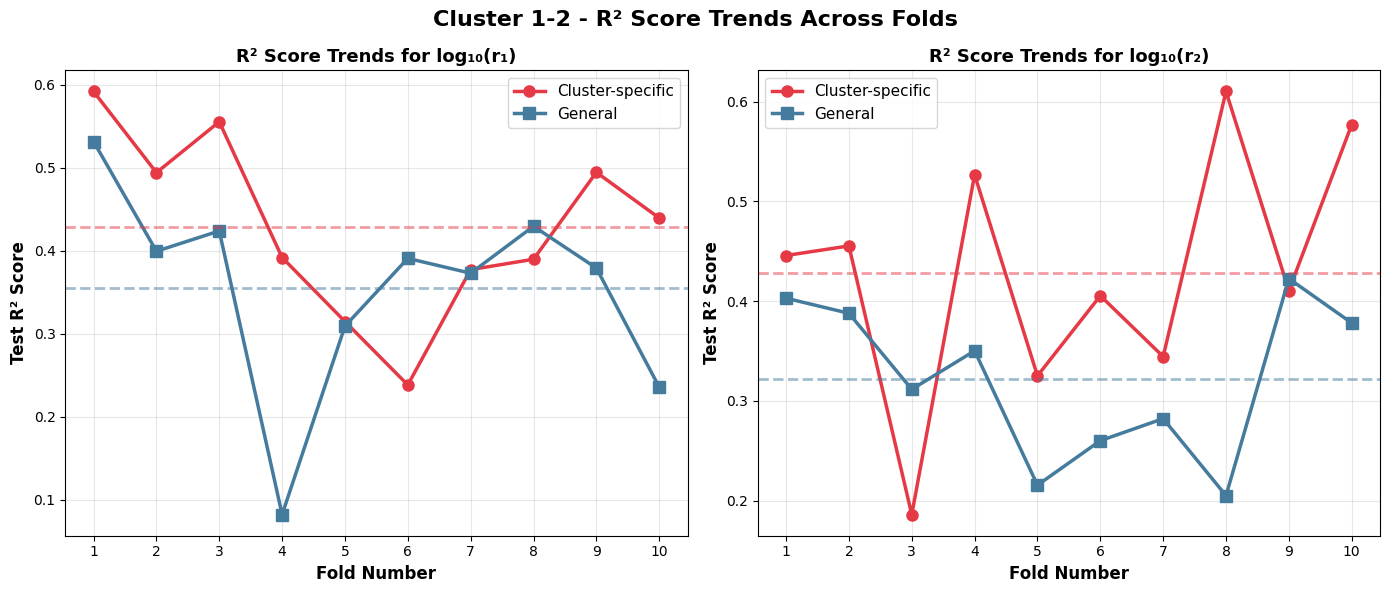

Saved MSE trends: Cluster_1_2_mse_trends.png


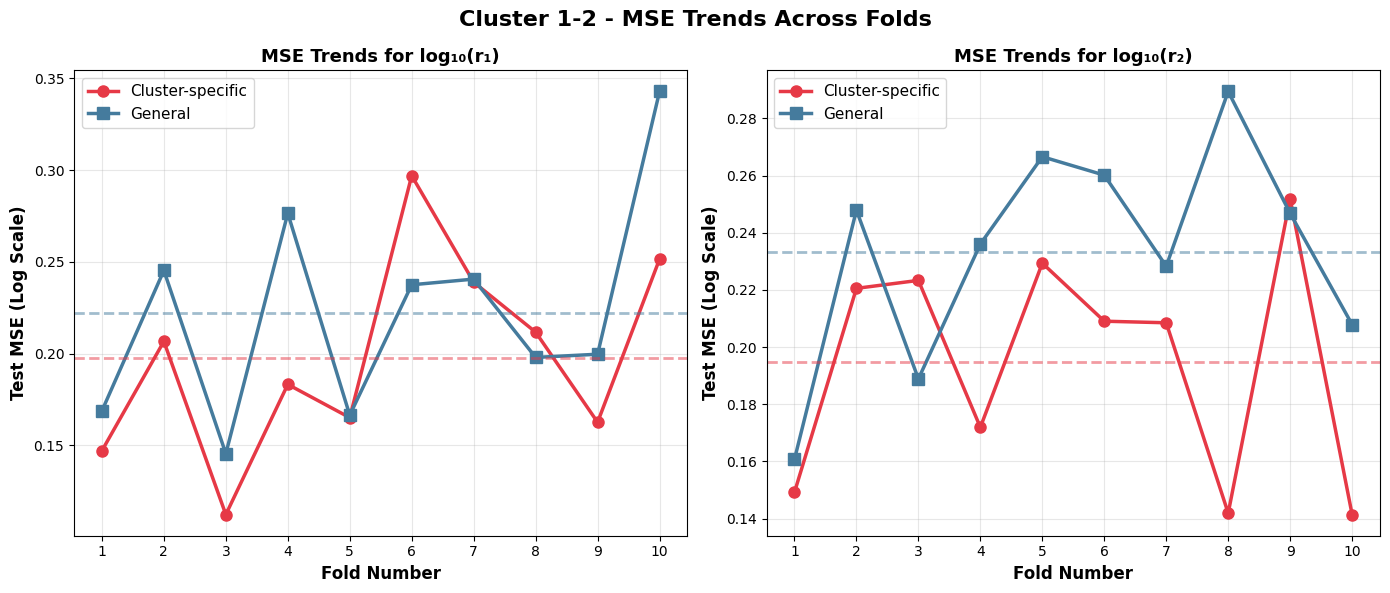


COMPREHENSIVE TRAINING STATISTICS - Cluster 1-2

────────────────────────────────────────────────────────────────────────────────
CLUSTER-SPECIFIC MODEL
────────────────────────────────────────────────────────────────────────────────

LOG SCALE RESULTS:
──────────────────────────────────────────────────
Train MSE Log R1: 0.0374 ± 0.0117
Train MSE Log R2: 0.0377 ± 0.0144
Test MSE Log R1: 0.1976 ± 0.0521
Test MSE Log R2: 0.1947 ± 0.0382

Train R² Log R1: 0.8929 ± 0.0322
Train R² Log R2: 0.8914 ± 0.0425
Test R² Log R1: 0.4288 ± 0.1030
Test R² Log R2: 0.4286 ± 0.1196

ACTUAL SCALE RESULTS:
──────────────────────────────────────────────────
Train MSE Actual R1: 0.4196 ± 0.1641
Train MSE Actual R2: 0.4398 ± 0.2525
Test MSE Actual R1: 1.5031 ± 0.7490
Test MSE Actual R2: 1.4952 ± 0.6609

Train R² Actual R1: 0.7715 ± 0.0952
Train R² Actual R2: 0.7623 ± 0.1348
Test R² Actual R1: 0.1917 ± 0.1784
Test R² Actual R2: 0.2088 ± 0.1708

─────────────────────────────────────────────────────────────────

In [7]:
"""
Enhanced Cluster-Specific Training Analysis with Separate Figure Saving
=======================================================================
Each fold parity plot and trend analysis saved as individual figures
"""

import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from rdkit import Chem
from rdkit.Chem import rdMolDescriptors
import matplotlib.pyplot as plt

# Set random seeds
np.random.seed(42)
tf.random.set_seed(42)

CONFIG = {
    'morgan_radius': 3,
    'morgan_bits': 2048,
    'neurons_l1': 80,
    'neurons_l2': 40,
    'learning_rate': 0.001,
    'batch_size': 32,
    'max_epochs': 200,
    'validation_split': 0.1,
    'patience': 30,
    'cv_folds': 10
}

def generate_morgan_fingerprint(smiles):
    """Generate Morgan fingerprint from SMILES string"""
    try:
        mol = Chem.MolFromSmiles(smiles)
        if mol is None:
            return np.zeros(CONFIG['morgan_bits'], dtype=np.float32)
        fp = rdMolDescriptors.GetMorganFingerprintAsBitVect(
            mol, CONFIG['morgan_radius'], nBits=CONFIG['morgan_bits']
        )
        return np.array(fp, dtype=np.float32)
    except:
        return np.zeros(CONFIG['morgan_bits'], dtype=np.float32)

def prepare_features_and_targets(data_subset):
    """Prepare Morgan fingerprint features and log-transformed targets"""
    fp_A = np.array([generate_morgan_fingerprint(smiles) for smiles in data_subset['SMILES_A']])
    fp_B = np.array([generate_morgan_fingerprint(smiles) for smiles in data_subset['SMILES_B']])
    X = np.concatenate([fp_A, fp_B], axis=1)
    
    y_log = np.column_stack([
        np.log10(data_subset['r1'].values),
        np.log10(data_subset['r2'].values)
    ])
    
    return X.astype(np.float32), y_log.astype(np.float32)

def create_neural_network(input_dim):
    """Create neural network architecture"""
    model = Sequential([
        Dense(CONFIG['neurons_l1'], activation='relu', input_shape=(input_dim,)),
        Dense(CONFIG['neurons_l2'], activation='relu'), 
        Dense(2, activation='linear')
    ])
    
    model.compile(
        optimizer=Adam(learning_rate=CONFIG['learning_rate']),
        loss='mse',
        metrics=['mae']
    )
    
    return model

def train_and_predict(X_train, y_train_log, X_test, y_test_log):
    """Train model and return predictions and metrics for both train and test"""
    tf.keras.backend.clear_session()
    
    model = create_neural_network(X_train.shape[1])
    
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=CONFIG['patience'],
        restore_best_weights=True,
        verbose=0
    )
    
    model.fit(
        X_train, y_train_log,
        epochs=CONFIG['max_epochs'],
        batch_size=CONFIG['batch_size'],
        validation_split=CONFIG['validation_split'],
        callbacks=[early_stopping],
        verbose=0
    )
    
    # Predictions on test set
    y_test_pred_log = model.predict(X_test, verbose=0)
    
    # Predictions on train set
    y_train_pred_log = model.predict(X_train, verbose=0)
    
    # Test metrics - LOG SCALE
    test_mse_r1_log = mean_squared_error(y_test_log[:, 0], y_test_pred_log[:, 0])
    test_mse_r2_log = mean_squared_error(y_test_log[:, 1], y_test_pred_log[:, 1])
    test_r2_r1_log = r2_score(y_test_log[:, 0], y_test_pred_log[:, 0])
    test_r2_r2_log = r2_score(y_test_log[:, 1], y_test_pred_log[:, 1])
    
    # Train metrics - LOG SCALE
    train_mse_r1_log = mean_squared_error(y_train_log[:, 0], y_train_pred_log[:, 0])
    train_mse_r2_log = mean_squared_error(y_train_log[:, 1], y_train_pred_log[:, 1])
    train_r2_r1_log = r2_score(y_train_log[:, 0], y_train_pred_log[:, 0])
    train_r2_r2_log = r2_score(y_train_log[:, 1], y_train_pred_log[:, 1])
    
    # ACTUAL SCALE - Test
    y_test_actual = 10**y_test_log
    y_test_pred_actual = 10**y_test_pred_log
    test_mse_r1_actual = mean_squared_error(y_test_actual[:, 0], y_test_pred_actual[:, 0])
    test_mse_r2_actual = mean_squared_error(y_test_actual[:, 1], y_test_pred_actual[:, 1])
    test_r2_r1_actual = r2_score(y_test_actual[:, 0], y_test_pred_actual[:, 0])
    test_r2_r2_actual = r2_score(y_test_actual[:, 1], y_test_pred_actual[:, 1])
    
    # ACTUAL SCALE - Train
    y_train_actual = 10**y_train_log
    y_train_pred_actual = 10**y_train_pred_log
    train_mse_r1_actual = mean_squared_error(y_train_actual[:, 0], y_train_pred_actual[:, 0])
    train_mse_r2_actual = mean_squared_error(y_train_actual[:, 1], y_train_pred_actual[:, 1])
    train_r2_r1_actual = r2_score(y_train_actual[:, 0], y_train_pred_actual[:, 0])
    train_r2_r2_actual = r2_score(y_train_actual[:, 1], y_train_pred_actual[:, 1])
    
    metrics = {
        # Test - Log scale
        'test_mse_r1_log': test_mse_r1_log,
        'test_mse_r2_log': test_mse_r2_log,
        'test_r2_r1_log': test_r2_r1_log,
        'test_r2_r2_log': test_r2_r2_log,
        # Train - Log scale
        'train_mse_r1_log': train_mse_r1_log,
        'train_mse_r2_log': train_mse_r2_log,
        'train_r2_r1_log': train_r2_r1_log,
        'train_r2_r2_log': train_r2_r2_log,
        # Test - Actual scale
        'test_mse_r1_actual': test_mse_r1_actual,
        'test_mse_r2_actual': test_mse_r2_actual,
        'test_r2_r1_actual': test_r2_r1_actual,
        'test_r2_r2_actual': test_r2_r2_actual,
        # Train - Actual scale
        'train_mse_r1_actual': train_mse_r1_actual,
        'train_mse_r2_actual': train_mse_r2_actual,
        'train_r2_r1_actual': train_r2_r1_actual,
        'train_r2_r2_actual': train_r2_r2_actual,
        # Legacy keys for backward compatibility (test only)
        'mse_r1': test_mse_r1_log,
        'mse_r2': test_mse_r2_log,
        'r2_r1': test_r2_r1_log,
        'r2_r2': test_r2_r2_log
    }
    
    return y_test_pred_log, metrics

def run_cluster_analysis_with_predictions(df, cluster_a, cluster_b):
    """Run analysis and store predictions for visualization"""
    cluster_name = f"Cluster {cluster_a}-{cluster_b}"
    print(f"\n{'='*80}")
    print(f"ANALYZING {cluster_name} INTERACTIONS")
    print(f"{'='*80}\n")
    
    data = df.copy()
    data = data[
        (data['r1'] > 0) & (data['r2'] > 0) &
        data['SMILES_A'].notna() & data['SMILES_B'].notna()
    ].reset_index(drop=True)
    
    # Capture bidirectional interactions
    if cluster_a == cluster_b:
        cluster_mask = (data['Cluster_A'] == cluster_a) & (data['Cluster_B'] == cluster_b)
    else:
        cluster_mask = ((data['Cluster_A'] == cluster_a) & (data['Cluster_B'] == cluster_b)) | \
                       ((data['Cluster_A'] == cluster_b) & (data['Cluster_B'] == cluster_a))
    
    cluster_indices = data.index[cluster_mask].tolist()
    
    print(f"Total samples: {len(cluster_indices)}")
    
    if len(cluster_indices) < 100:
        print(f"\nWARNING: Insufficient samples for 10-fold CV (need at least 100)")
        return None, None
    
    X_all, y_log_all = prepare_features_and_targets(data)
    
    kfold = KFold(n_splits=CONFIG['cv_folds'], shuffle=True, random_state=42)
    
    # Storage for all fold results
    fold_data = []
    
    # Cross-validation loop
    for fold, (train_idx, test_idx) in enumerate(kfold.split(cluster_indices)):
        print(f"Processing Fold {fold + 1}...")
        
        cluster_train_indices = [cluster_indices[i] for i in train_idx]
        cluster_test_indices = [cluster_indices[i] for i in test_idx]
        
        X_test = X_all[cluster_test_indices]
        y_test_log = y_log_all[cluster_test_indices]
        
        # Cluster-specific training
        X_cluster_train = X_all[cluster_train_indices]
        y_cluster_train_log = y_log_all[cluster_train_indices]
        
        y_pred_cluster, metrics_cluster = train_and_predict(
            X_cluster_train, y_cluster_train_log, X_test, y_test_log
        )
        
        # General training
        available_indices = [i for i in range(len(data)) if i not in cluster_test_indices]
        general_train_indices = np.random.choice(
            available_indices, 
            size=len(cluster_train_indices), 
            replace=False
        )
        
        X_general_train = X_all[general_train_indices]
        y_general_train_log = y_log_all[general_train_indices]
        
        y_pred_general, metrics_general = train_and_predict(
            X_general_train, y_general_train_log, X_test, y_test_log
        )
        
        # Store results
        fold_data.append({
            'fold': fold + 1,
            'y_test': y_test_log,
            'y_pred_cluster': y_pred_cluster,
            'y_pred_general': y_pred_general,
            'metrics_cluster': metrics_cluster,
            'metrics_general': metrics_general
        })
    
    return fold_data, cluster_name

def save_individual_fold_parity_plots(fold_data, cluster_name):
    """Save each fold's parity plot as a separate figure"""
    colors = {'cluster': '#E63946', 'general': '#457B9D'}
    
    cluster_filename = cluster_name.replace(" ", "_").replace("-", "_")
    
    print(f"\nSaving individual fold parity plots...")
    
    for i, fold_info in enumerate(fold_data):
        fold_num = fold_info['fold']
        y_test = fold_info['y_test']
        y_pred_cluster = fold_info['y_pred_cluster']
        y_pred_general = fold_info['y_pred_general']
        
        # Get R² scores
        r2_cluster_r1 = fold_info['metrics_cluster']['r2_r1']
        r2_cluster_r2 = fold_info['metrics_cluster']['r2_r2']
        r2_general_r1 = fold_info['metrics_general']['r2_r1']
        r2_general_r2 = fold_info['metrics_general']['r2_r2']
        
        # Find global min/max for consistent axes
        all_values_r1 = np.concatenate([y_test[:, 0], y_pred_cluster[:, 0], y_pred_general[:, 0]])
        all_values_r2 = np.concatenate([y_test[:, 1], y_pred_cluster[:, 1], y_pred_general[:, 1]])
        
        min_r1, max_r1 = all_values_r1.min() - 0.1, all_values_r1.max() + 0.1
        min_r2, max_r2 = all_values_r2.min() - 0.1, all_values_r2.max() + 0.1
        
        # Create 1x2 subplot for this fold
        fig, axes = plt.subplots(1, 2, figsize=(14, 6))
        fig.suptitle(f'{cluster_name} - Fold {fold_num} Parity Plots', 
                     fontsize=16, fontweight='bold')
        
        # Left: r1 parity plot
        ax_r1 = axes[0]
        ax_r1.scatter(y_test[:, 0], y_pred_cluster[:, 0], 
                     alpha=0.6, s=50, color=colors['cluster'], 
                     label=f'Cluster-specific (R²={r2_cluster_r1:.3f})', 
                     edgecolors='black', linewidth=0.5)
        ax_r1.scatter(y_test[:, 0], y_pred_general[:, 0], 
                     alpha=0.6, s=50, color=colors['general'], 
                     label=f'General (R²={r2_general_r1:.3f})', 
                     marker='s', edgecolors='black', linewidth=0.5)
        ax_r1.plot([min_r1, max_r1], [min_r1, max_r1], 'k--', linewidth=2, alpha=0.5)
        ax_r1.set_xlim(min_r1, max_r1)
        ax_r1.set_ylim(min_r1, max_r1)
        ax_r1.set_xlabel('Experimental log₁₀(r₁)', fontsize=12, fontweight='bold')
        ax_r1.set_ylabel('Predicted log₁₀(r₁)', fontsize=12, fontweight='bold')
        ax_r1.set_title(f'log₁₀(r₁)', fontsize=13, fontweight='bold')
        ax_r1.legend(fontsize=10, loc='upper left')
        ax_r1.grid(True, alpha=0.3)
        
        # Right: r2 parity plot
        ax_r2 = axes[1]
        ax_r2.scatter(y_test[:, 1], y_pred_cluster[:, 1], 
                     alpha=0.6, s=50, color=colors['cluster'], 
                     label=f'Cluster-specific (R²={r2_cluster_r2:.3f})', 
                     edgecolors='black', linewidth=0.5)
        ax_r2.scatter(y_test[:, 1], y_pred_general[:, 1], 
                     alpha=0.6, s=50, color=colors['general'], 
                     label=f'General (R²={r2_general_r2:.3f})', 
                     marker='s', edgecolors='black', linewidth=0.5)
        ax_r2.plot([min_r2, max_r2], [min_r2, max_r2], 'k--', linewidth=2, alpha=0.5)
        ax_r2.set_xlim(min_r2, max_r2)
        ax_r2.set_ylim(min_r2, max_r2)
        ax_r2.set_xlabel('Experimental log₁₀(r₂)', fontsize=12, fontweight='bold')
        ax_r2.set_ylabel('Predicted log₁₀(r₂)', fontsize=12, fontweight='bold')
        ax_r2.set_title(f'log₁₀(r₂)', fontsize=13, fontweight='bold')
        ax_r2.legend(fontsize=10, loc='upper left')
        ax_r2.grid(True, alpha=0.3)
        
        plt.tight_layout()
        
        filename = f'{cluster_filename}_fold_{fold_num:02d}_parity.png'
        plt.savefig(filename, dpi=300, bbox_inches='tight', facecolor='white')
        print(f"  Saved: {filename}")
        plt.show()
        plt.close()

def save_r2_trend_plot(fold_data, cluster_name):
    """Save R² trends as a separate figure"""
    colors = {'cluster': '#E63946', 'general': '#457B9D'}
    cluster_filename = cluster_name.replace(" ", "_").replace("-", "_")
    
    # Extract metrics
    folds = [f['fold'] for f in fold_data]
    r2_cluster_r1 = [f['metrics_cluster']['r2_r1'] for f in fold_data]
    r2_general_r1 = [f['metrics_general']['r2_r1'] for f in fold_data]
    r2_cluster_r2 = [f['metrics_cluster']['r2_r2'] for f in fold_data]
    r2_general_r2 = [f['metrics_general']['r2_r2'] for f in fold_data]
    
    # Create 1x2 subplot
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    fig.suptitle(f'{cluster_name} - R² Score Trends Across Folds', 
                 fontsize=16, fontweight='bold')
    
    # Left: R² for r1
    ax_r1 = axes[0]
    ax_r1.plot(folds, r2_cluster_r1, 'o-', color=colors['cluster'], 
               label='Cluster-specific', linewidth=2.5, markersize=8)
    ax_r1.plot(folds, r2_general_r1, 's-', color=colors['general'], 
               label='General', linewidth=2.5, markersize=8)
    ax_r1.axhline(y=np.mean(r2_cluster_r1), color=colors['cluster'], 
                  linestyle='--', alpha=0.5, linewidth=2)
    ax_r1.axhline(y=np.mean(r2_general_r1), color=colors['general'], 
                  linestyle='--', alpha=0.5, linewidth=2)
    ax_r1.set_xlabel('Fold Number', fontsize=12, fontweight='bold')
    ax_r1.set_ylabel('Test R² Score', fontsize=12, fontweight='bold')
    ax_r1.set_title('R² Score Trends for log₁₀(r₁)', fontsize=13, fontweight='bold')
    ax_r1.legend(fontsize=11)
    ax_r1.grid(True, alpha=0.3)
    ax_r1.set_xticks(folds)
    
    # Right: R² for r2
    ax_r2 = axes[1]
    ax_r2.plot(folds, r2_cluster_r2, 'o-', color=colors['cluster'], 
               label='Cluster-specific', linewidth=2.5, markersize=8)
    ax_r2.plot(folds, r2_general_r2, 's-', color=colors['general'], 
               label='General', linewidth=2.5, markersize=8)
    ax_r2.axhline(y=np.mean(r2_cluster_r2), color=colors['cluster'], 
                  linestyle='--', alpha=0.5, linewidth=2)
    ax_r2.axhline(y=np.mean(r2_general_r2), color=colors['general'], 
                  linestyle='--', alpha=0.5, linewidth=2)
    ax_r2.set_xlabel('Fold Number', fontsize=12, fontweight='bold')
    ax_r2.set_ylabel('Test R² Score', fontsize=12, fontweight='bold')
    ax_r2.set_title('R² Score Trends for log₁₀(r₂)', fontsize=13, fontweight='bold')
    ax_r2.legend(fontsize=11)
    ax_r2.grid(True, alpha=0.3)
    ax_r2.set_xticks(folds)
    
    plt.tight_layout()
    
    filename = f'{cluster_filename}_r2_trends.png'
    plt.savefig(filename, dpi=300, bbox_inches='tight', facecolor='white')
    print(f"\nSaved R² trends: {filename}")
    plt.show()
    plt.close()

def save_mse_trend_plot(fold_data, cluster_name):
    """Save MSE trends as a separate figure"""
    colors = {'cluster': '#E63946', 'general': '#457B9D'}
    cluster_filename = cluster_name.replace(" ", "_").replace("-", "_")
    
    # Extract metrics
    folds = [f['fold'] for f in fold_data]
    mse_cluster_r1 = [f['metrics_cluster']['mse_r1'] for f in fold_data]
    mse_general_r1 = [f['metrics_general']['mse_r1'] for f in fold_data]
    mse_cluster_r2 = [f['metrics_cluster']['mse_r2'] for f in fold_data]
    mse_general_r2 = [f['metrics_general']['mse_r2'] for f in fold_data]
    
    # Create 1x2 subplot
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    fig.suptitle(f'{cluster_name} - MSE Trends Across Folds', 
                 fontsize=16, fontweight='bold')
    
    # Left: MSE for r1
    ax_r1 = axes[0]
    ax_r1.plot(folds, mse_cluster_r1, 'o-', color=colors['cluster'], 
               label='Cluster-specific', linewidth=2.5, markersize=8)
    ax_r1.plot(folds, mse_general_r1, 's-', color=colors['general'], 
               label='General', linewidth=2.5, markersize=8)
    ax_r1.axhline(y=np.mean(mse_cluster_r1), color=colors['cluster'], 
                  linestyle='--', alpha=0.5, linewidth=2)
    ax_r1.axhline(y=np.mean(mse_general_r1), color=colors['general'], 
                  linestyle='--', alpha=0.5, linewidth=2)
    ax_r1.set_xlabel('Fold Number', fontsize=12, fontweight='bold')
    ax_r1.set_ylabel('Test MSE (Log Scale)', fontsize=12, fontweight='bold')
    ax_r1.set_title('MSE Trends for log₁₀(r₁)', fontsize=13, fontweight='bold')
    ax_r1.legend(fontsize=11)
    ax_r1.grid(True, alpha=0.3)
    ax_r1.set_xticks(folds)
    
    # Right: MSE for r2
    ax_r2 = axes[1]
    ax_r2.plot(folds, mse_cluster_r2, 'o-', color=colors['cluster'], 
               label='Cluster-specific', linewidth=2.5, markersize=8)
    ax_r2.plot(folds, mse_general_r2, 's-', color=colors['general'], 
               label='General', linewidth=2.5, markersize=8)
    ax_r2.axhline(y=np.mean(mse_cluster_r2), color=colors['cluster'], 
                  linestyle='--', alpha=0.5, linewidth=2)
    ax_r2.axhline(y=np.mean(mse_general_r2), color=colors['general'], 
                  linestyle='--', alpha=0.5, linewidth=2)
    ax_r2.set_xlabel('Fold Number', fontsize=12, fontweight='bold')
    ax_r2.set_ylabel('Test MSE (Log Scale)', fontsize=12, fontweight='bold')
    ax_r2.set_title('MSE Trends for log₁₀(r₂)', fontsize=13, fontweight='bold')
    ax_r2.legend(fontsize=11)
    ax_r2.grid(True, alpha=0.3)
    ax_r2.set_xticks(folds)
    
    plt.tight_layout()
    
    filename = f'{cluster_filename}_mse_trends.png'
    plt.savefig(filename, dpi=300, bbox_inches='tight', facecolor='white')
    print(f"Saved MSE trends: {filename}")
    plt.show()
    plt.close()

def main_analysis(df, cluster_a, cluster_b):
    """Main function to run analysis and create separate visualizations"""
    fold_data, cluster_name = run_cluster_analysis_with_predictions(df, cluster_a, cluster_b)
    
    if fold_data is None:
        print(f"\nSkipping {cluster_name} - insufficient data")
        return
    
    # Save each fold's parity plot separately
    save_individual_fold_parity_plots(fold_data, cluster_name)
    
    # Save R² trends
    save_r2_trend_plot(fold_data, cluster_name)
    
    # Save MSE trends
    save_mse_trend_plot(fold_data, cluster_name)
    
    # Print comprehensive statistics
    print(f"\n{'='*80}")
    print(f"COMPREHENSIVE TRAINING STATISTICS - {cluster_name}")
    print(f"{'='*80}")
    
    # Extract all metrics from fold_data
    cluster_metrics = {
        'train_mse_r1_log': [f['metrics_cluster']['train_mse_r1_log'] for f in fold_data],
        'train_mse_r2_log': [f['metrics_cluster']['train_mse_r2_log'] for f in fold_data],
        'test_mse_r1_log': [f['metrics_cluster']['test_mse_r1_log'] for f in fold_data],
        'test_mse_r2_log': [f['metrics_cluster']['test_mse_r2_log'] for f in fold_data],
        'train_r2_r1_log': [f['metrics_cluster']['train_r2_r1_log'] for f in fold_data],
        'train_r2_r2_log': [f['metrics_cluster']['train_r2_r2_log'] for f in fold_data],
        'test_r2_r1_log': [f['metrics_cluster']['test_r2_r1_log'] for f in fold_data],
        'test_r2_r2_log': [f['metrics_cluster']['test_r2_r2_log'] for f in fold_data],
        'train_mse_r1_actual': [f['metrics_cluster']['train_mse_r1_actual'] for f in fold_data],
        'train_mse_r2_actual': [f['metrics_cluster']['train_mse_r2_actual'] for f in fold_data],
        'test_mse_r1_actual': [f['metrics_cluster']['test_mse_r1_actual'] for f in fold_data],
        'test_mse_r2_actual': [f['metrics_cluster']['test_mse_r2_actual'] for f in fold_data],
        'train_r2_r1_actual': [f['metrics_cluster']['train_r2_r1_actual'] for f in fold_data],
        'train_r2_r2_actual': [f['metrics_cluster']['train_r2_r2_actual'] for f in fold_data],
        'test_r2_r1_actual': [f['metrics_cluster']['test_r2_r1_actual'] for f in fold_data],
        'test_r2_r2_actual': [f['metrics_cluster']['test_r2_r2_actual'] for f in fold_data],
    }
    
    general_metrics = {
        'train_mse_r1_log': [f['metrics_general']['train_mse_r1_log'] for f in fold_data],
        'train_mse_r2_log': [f['metrics_general']['train_mse_r2_log'] for f in fold_data],
        'test_mse_r1_log': [f['metrics_general']['test_mse_r1_log'] for f in fold_data],
        'test_mse_r2_log': [f['metrics_general']['test_mse_r2_log'] for f in fold_data],
        'train_r2_r1_log': [f['metrics_general']['train_r2_r1_log'] for f in fold_data],
        'train_r2_r2_log': [f['metrics_general']['train_r2_r2_log'] for f in fold_data],
        'test_r2_r1_log': [f['metrics_general']['test_r2_r1_log'] for f in fold_data],
        'test_r2_r2_log': [f['metrics_general']['test_r2_r2_log'] for f in fold_data],
        'train_mse_r1_actual': [f['metrics_general']['train_mse_r1_actual'] for f in fold_data],
        'train_mse_r2_actual': [f['metrics_general']['train_mse_r2_actual'] for f in fold_data],
        'test_mse_r1_actual': [f['metrics_general']['test_mse_r1_actual'] for f in fold_data],
        'test_mse_r2_actual': [f['metrics_general']['test_mse_r2_actual'] for f in fold_data],
        'train_r2_r1_actual': [f['metrics_general']['train_r2_r1_actual'] for f in fold_data],
        'train_r2_r2_actual': [f['metrics_general']['train_r2_r2_actual'] for f in fold_data],
        'test_r2_r1_actual': [f['metrics_general']['test_r2_r1_actual'] for f in fold_data],
        'test_r2_r2_actual': [f['metrics_general']['test_r2_r2_actual'] for f in fold_data],
    }
    
    # CLUSTER-SPECIFIC MODEL RESULTS
    print(f"\n{'─'*80}")
    print("CLUSTER-SPECIFIC MODEL")
    print(f"{'─'*80}")
    
    print(f"\nLOG SCALE RESULTS:")
    print(f"{'─'*50}")
    print(f"Train MSE Log R1: {np.mean(cluster_metrics['train_mse_r1_log']):.4f} ± {np.std(cluster_metrics['train_mse_r1_log']):.4f}")
    print(f"Train MSE Log R2: {np.mean(cluster_metrics['train_mse_r2_log']):.4f} ± {np.std(cluster_metrics['train_mse_r2_log']):.4f}")
    print(f"Test MSE Log R1: {np.mean(cluster_metrics['test_mse_r1_log']):.4f} ± {np.std(cluster_metrics['test_mse_r1_log']):.4f}")
    print(f"Test MSE Log R2: {np.mean(cluster_metrics['test_mse_r2_log']):.4f} ± {np.std(cluster_metrics['test_mse_r2_log']):.4f}")
    print()
    print(f"Train R² Log R1: {np.mean(cluster_metrics['train_r2_r1_log']):.4f} ± {np.std(cluster_metrics['train_r2_r1_log']):.4f}")
    print(f"Train R² Log R2: {np.mean(cluster_metrics['train_r2_r2_log']):.4f} ± {np.std(cluster_metrics['train_r2_r2_log']):.4f}")
    print(f"Test R² Log R1: {np.mean(cluster_metrics['test_r2_r1_log']):.4f} ± {np.std(cluster_metrics['test_r2_r1_log']):.4f}")
    print(f"Test R² Log R2: {np.mean(cluster_metrics['test_r2_r2_log']):.4f} ± {np.std(cluster_metrics['test_r2_r2_log']):.4f}")
    
    print(f"\nACTUAL SCALE RESULTS:")
    print(f"{'─'*50}")
    print(f"Train MSE Actual R1: {np.mean(cluster_metrics['train_mse_r1_actual']):.4f} ± {np.std(cluster_metrics['train_mse_r1_actual']):.4f}")
    print(f"Train MSE Actual R2: {np.mean(cluster_metrics['train_mse_r2_actual']):.4f} ± {np.std(cluster_metrics['train_mse_r2_actual']):.4f}")
    print(f"Test MSE Actual R1: {np.mean(cluster_metrics['test_mse_r1_actual']):.4f} ± {np.std(cluster_metrics['test_mse_r1_actual']):.4f}")
    print(f"Test MSE Actual R2: {np.mean(cluster_metrics['test_mse_r2_actual']):.4f} ± {np.std(cluster_metrics['test_mse_r2_actual']):.4f}")
    print()
    print(f"Train R² Actual R1: {np.mean(cluster_metrics['train_r2_r1_actual']):.4f} ± {np.std(cluster_metrics['train_r2_r1_actual']):.4f}")
    print(f"Train R² Actual R2: {np.mean(cluster_metrics['train_r2_r2_actual']):.4f} ± {np.std(cluster_metrics['train_r2_r2_actual']):.4f}")
    print(f"Test R² Actual R1: {np.mean(cluster_metrics['test_r2_r1_actual']):.4f} ± {np.std(cluster_metrics['test_r2_r1_actual']):.4f}")
    print(f"Test R² Actual R2: {np.mean(cluster_metrics['test_r2_r2_actual']):.4f} ± {np.std(cluster_metrics['test_r2_r2_actual']):.4f}")
    
    # GENERAL MODEL RESULTS
    print(f"\n{'─'*80}")
    print("GENERAL MODEL")
    print(f"{'─'*80}")
    
    print(f"\nLOG SCALE RESULTS:")
    print(f"{'─'*50}")
    print(f"Train MSE Log R1: {np.mean(general_metrics['train_mse_r1_log']):.4f} ± {np.std(general_metrics['train_mse_r1_log']):.4f}")
    print(f"Train MSE Log R2: {np.mean(general_metrics['train_mse_r2_log']):.4f} ± {np.std(general_metrics['train_mse_r2_log']):.4f}")
    print(f"Test MSE Log R1: {np.mean(general_metrics['test_mse_r1_log']):.4f} ± {np.std(general_metrics['test_mse_r1_log']):.4f}")
    print(f"Test MSE Log R2: {np.mean(general_metrics['test_mse_r2_log']):.4f} ± {np.std(general_metrics['test_mse_r2_log']):.4f}")
    print()
    print(f"Train R² Log R1: {np.mean(general_metrics['train_r2_r1_log']):.4f} ± {np.std(general_metrics['train_r2_r1_log']):.4f}")
    print(f"Train R² Log R2: {np.mean(general_metrics['train_r2_r2_log']):.4f} ± {np.std(general_metrics['train_r2_r2_log']):.4f}")
    print(f"Test R² Log R1: {np.mean(general_metrics['test_r2_r1_log']):.4f} ± {np.std(general_metrics['test_r2_r1_log']):.4f}")
    print(f"Test R² Log R2: {np.mean(general_metrics['test_r2_r2_log']):.4f} ± {np.std(general_metrics['test_r2_r2_log']):.4f}")
    
    print(f"\nACTUAL SCALE RESULTS:")
    print(f"{'─'*50}")
    print(f"Train MSE Actual R1: {np.mean(general_metrics['train_mse_r1_actual']):.4f} ± {np.std(general_metrics['train_mse_r1_actual']):.4f}")
    print(f"Train MSE Actual R2: {np.mean(general_metrics['train_mse_r2_actual']):.4f} ± {np.std(general_metrics['train_mse_r2_actual']):.4f}")
    print(f"Test MSE Actual R1: {np.mean(general_metrics['test_mse_r1_actual']):.4f} ± {np.std(general_metrics['test_mse_r1_actual']):.4f}")
    print(f"Test MSE Actual R2: {np.mean(general_metrics['test_mse_r2_actual']):.4f} ± {np.std(general_metrics['test_mse_r2_actual']):.4f}")
    print()
    print(f"Train R² Actual R1: {np.mean(general_metrics['train_r2_r1_actual']):.4f} ± {np.std(general_metrics['train_r2_r1_actual']):.4f}")
    print(f"Train R² Actual R2: {np.mean(general_metrics['train_r2_r2_actual']):.4f} ± {np.std(general_metrics['train_r2_r2_actual']):.4f}")
    print(f"Test R² Actual R1: {np.mean(general_metrics['test_r2_r1_actual']):.4f} ± {np.std(general_metrics['test_r2_r1_actual']):.4f}")
    print(f"Test R² Actual R2: {np.mean(general_metrics['test_r2_r2_actual']):.4f} ± {np.std(general_metrics['test_r2_r2_actual']):.4f}")
    
    print(f"\n{'='*80}")
    print(f"ANALYSIS COMPLETE!")
    print(f"{'='*80}")

# Usage
if __name__ == "__main__":
    # Check data distribution before running
    print("="*80)
    print("DATA DISTRIBUTION CHECK")
    print("="*80)
    
    data_check = df.copy()
    data_check = data_check[
        (data_check['r1'] > 0) & (data_check['r2'] > 0) &
        data_check['SMILES_A'].notna() & data_check['SMILES_B'].notna()
    ]
    
    print(f"\nTotal valid samples: {len(data_check)}")
    print("\nCluster Interaction Counts:")
    
    for i in [1, 2, 3]:
        for j in [1, 2, 3]:
            if j >= i:
                if i == j:
                    mask = (data_check['Cluster_A'] == i) & (data_check['Cluster_B'] == j)
                else:
                    mask = ((data_check['Cluster_A'] == i) & (data_check['Cluster_B'] == j)) | \
                           ((data_check['Cluster_A'] == j) & (data_check['Cluster_B'] == i))
                count = mask.sum()
                print(f"  Cluster {i}-{j}: {count} samples")
    
    print("\n" + "="*80)
    print("STARTING ANALYSIS")
    print("="*80)
    
    # Run analyses
    #main_analysis(df, cluster_a=1, cluster_b=1)
    main_analysis(df, cluster_a=1, cluster_b=2)
    #main_analysis(df, cluster_a=1, cluster_b=3)
    #main_analysis(df, cluster_a=2, cluster_b=2)
    #main_analysis(df, cluster_a=2, cluster_b=3)
    #main_analysis(df, cluster_a=3, cluster_b=3)

In [3]:
print('fgf')

fgf
